# Проект: Определение стоимости автомобилей

## Данные

В наличии были следующие данные о комментариях в интернет-магазине:

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя
- Price — цена (евро)



## Задача

Разработка системы рекомендации стоимости автомобиля на основе его описания.

## Используемые библиотеки

pandas, numpy, os, matplotlib, sklearn, catboost, lightgbm

## Подготовка данных

### Обзор данных

In [454]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import lightgbm as lgb
import seaborn as sns
import os

from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [455]:
#data = pd.read_csv('DataFrames/autos.csv')
#data = pd.read_csv('/datasets/autos.csv')

path = '/datasets/autos.csv'
if not os.path.exists(path):
    path = 'DataFrames/autos.csv'
    
data = pd.read_csv(path)

In [456]:
data.head()

DateCrawled  Price VehicleType  RegistrationYear Gearbox  Power  \
0  2016-03-24 11:52:17    480         NaN              1993  manual      0   
1  2016-03-24 10:58:45  18300       coupe              2011  manual    190   
2  2016-03-14 12:52:21   9800         suv              2004    auto    163   
3  2016-03-17 16:54:04   1500       small              2001  manual     75   
4  2016-03-31 17:25:20   3600       small              2008  manual     69   

   Model  Kilometer  RegistrationMonth  FuelType       Brand Repaired  \
0   golf     150000                  0    petrol  volkswagen      NaN   
1    NaN     125000                  5  gasoline        audi      yes   
2  grand     125000                  8  gasoline        jeep      NaN   
3   golf     150000                  6    petrol  volkswagen       no   
4  fabia      90000                  7  gasoline       skoda       no   

           DateCreated  NumberOfPictures  PostalCode             LastSeen  
0  2016-03-24 00:00:00                 0       70435  2016-04-07 03:16:57  
1  2016-03-24 00:00:00                 0       66954  2016-04-07 01:46:50  
2  2016-03-14 00:00:00                 0       90480  2016-04-05 12:47:46  
3  2016-03-17 00:00:00                 0       91074  2016-03-17 17:40:17  
4  2016-03-31 00:00:00                 0       60437  2016-04-06 10:17:21

In [457]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

### Предобработка

In [458]:
data.columns = data.columns.str.lower() # Приведение к нижнему регистру названий столбцов

In [459]:
# Переименование названий столбцов
data = data.rename(columns={'datecrawled':'date_crawled',
                     'vehicletype':'vehicle_type',
                     'registrationyear':'registration_year',
                     'registrationmonth':'registration_month',
                     'fueltype': 'fuel_type',
                     'datecreated':'date_created',
                     'numberofpictures':'number_of_pictures',
                     'postalcode':'postal_code',
                     'lastseen':'last_seen'})

print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

In [460]:
data.duplicated().sum() # Проверка на явные дубликаты

4

In [461]:
data = data.drop_duplicates().reset_index(drop=True) # Удаление явных дубликатов

In [462]:
for column in data.columns: # Уникальные значения каждого столбца
    print(column)
    print(data[column].unique())
    print(len(data[column].unique()))
    print('-----------------------')
    print()

date_crawled
['2016-03-24 11:52:17' '2016-03-24 10:58:45' '2016-03-14 12:52:21' ...
 '2016-03-21 09:50:58' '2016-03-14 17:48:27' '2016-03-19 18:57:12']
271174
-----------------------

price
[  480 18300  9800 ... 12395 18429 10985]
3731
-----------------------

vehicle_type
[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
9
-----------------------

registration_year
[1993 2011 2004 2001 2008 1995 1980 2014 1998 2005 1910 2016 2007 2009
 2002 2018 1997 1990 2017 1981 2003 1994 1991 1984 2006 1999 2012 2010
 2000 1992 2013 1996 1985 1989 2015 1982 1976 1983 1973 1111 1969 1971
 1987 1986 1988 1970 1965 1945 1925 1974 1979 1955 1978 1972 1968 1977
 1961 1960 1966 1975 1963 1964 5000 1954 1958 1967 1959 9999 1956 3200
 1000 1941 8888 1500 2200 4100 1962 1929 1957 1940 3000 2066 1949 2019
 1937 1951 1800 1953 1234 8000 5300 9000 2900 6000 5900 5911 1933 1400
 1950 4000 1948 1952 1200 8500 1932 1255 3700 3800 4800 1942 7000 1935
 1936 6500 1923 2290 2500 1930 1001 9450

In [463]:
data['date_crawled'] = data['date_crawled'].astype('datetime64')
data['date_created'] = data['date_created'].astype('datetime64')
data['last_seen'] = data['last_seen'].astype('datetime64')

In [464]:
# Удаление неиформативных признаков
data = data.drop(labels=['last_seen',
                         'number_of_pictures', 
                         'date_crawled', 
                         'date_created'], axis=1) 

last_seen, date_crawled, date_created не влияют на стоимость автомобиля, number_of_pictures содержит одно уникальное значение 0.

In [465]:
data.loc[data['repaired'] == 'yes', 'repaired'] = 1
data.loc[data['repaired'] == 'no', 'repaired'] = 2

In [466]:
data.loc[data['gearbox'] == 'manual', 'gearbox'] = 0
data.loc[data['gearbox'] == 'auto', 'gearbox'] = 1

In [467]:
# Подсчет пропусков в процентах
pd.DataFrame(data.isna().mean()*100,).style.background_gradient('coolwarm')

In [468]:
# Замена пропусков в столбце model наиболее встречающимся значением для каждого бренда
for brand in data['brand'].dropna().unique():
    model_groupted = data.loc[data['brand'] == brand].groupby('model')['model'].count().sort_values(ascending=False)
    if model_groupted.shape[0] > 0:
        data.loc[(data['brand'] == brand)&(data['model'].isna()), 'model'] = model_groupted.index[0]
    else:
        print(brand)

sonstige_autos


In [469]:
print('Процент sonstige_autos в датафрейме:',data[data['brand'] == 'sonstige_autos'].shape[0]/data.shape[0] * 100, '%')

Процент sonstige_autos в датафрейме: 0.9521256331748339 %


Единственная информация о sonstige_autos в интернете - это бренд игрушечных авто. Эти данные можно удалить.

In [470]:
data = data[data['brand'] != 'sonstige_autos'] # Удаление данных о sonstige_autos

In [471]:
# Замена пропусков в столбце vehicle_type наиболее встречающимся значением для каждой модели
for model in data['model'].dropna().unique():
    vehicle_type = data.loc[data['model'] == model].groupby('vehicle_type')['vehicle_type'].count().sort_values(ascending=False)
    if vehicle_type.shape[0] > 0:
        data.loc[(data['model'] == model)&(data['vehicle_type'].isna()), 'vehicle_type'] = vehicle_type.index[0]
    else:
        print(model)
    

In [472]:
# Замена пропусков в столбце gearbox наиболее встречающимся значением для каждой модели
for model in data['model'].dropna().unique():
    gearbox = data.loc[data['model'] == model].groupby('gearbox')['gearbox'].count().sort_values(ascending=False)
    if gearbox.shape[0] > 0:
        data.loc[(data['model'] == model)&(data['gearbox'].isna()), 'gearbox'] = gearbox.index[0]
    else:
         print(model)

In [473]:
# Замена пропусков в столбце fuel_type наиболее встречающимся значением для каждой модели
for model in data['model'].dropna().unique():
    fuel_type = data.loc[data['model'] == model].groupby('fuel_type')['fuel_type'].count().sort_values(ascending=False)
    if fuel_type.shape[0] > 0:
        data.loc[(data['model'] == model)&(data['fuel_type'].isna()), 'fuel_type'] = fuel_type.index[0]
    else:
         print(model)

In [474]:
data['repaired'] = data['repaired'].fillna(0) # Заполнение пропусков нулями

In [475]:
# Подсчет пропусков в процентах
pd.DataFrame(data.isna().mean()*100,).style.background_gradient('coolwarm')

In [476]:
data['price'] = np.int64(data['price'])
data['repaired'] = np.int32(data['repaired'])
data['gearbox'] = np.int32(data['gearbox'])
data['registration_year'] = np.int64(data['registration_year'])

In [477]:
data.shape[1]

12

Названия столбцов приведены к нижнему регистру. Данные содержали неиформативные признаки: last_seen, number_of_pictures, date_crawled, date_created, явные дубликаты, выбросы и пропуски. Пропуски заполнены медианными значениями по моделям или бренду автомобиля, для repaired нулями. 

### Исследование данных

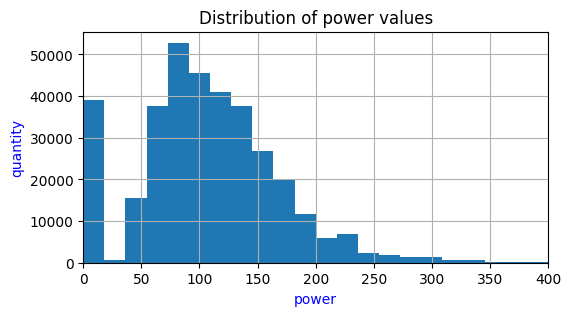

In [478]:
plt.figure(figsize=(6, 3))
plt.hist(data['power'], bins=1100)
plt.title('Distribution of power values')
plt.xlim(0,400)
plt.xlabel("power", color = 'blue')
plt.ylabel("quantity", color = 'blue')
plt.grid()

plt.show()

Аномально маленькие значения мощности автомобиля присутствуют

In [479]:
print(data[data['power'] < 30].shape[0]/data.shape[0]*100, '%')

11.261542318748914 %


In [480]:
# Замена аномальных значений мощности медианным значением для каждой модели 
for index in data.loc[data['power'] < 30].index:
    data.loc[index, 'power'] = data.loc[data['model'] == data.loc[index, 'model'], 'power'].median()
        


<div class="alert alert-block alert-success">
<b>✔️ Успех:</b>

Мощность ограничили 👍
</div>

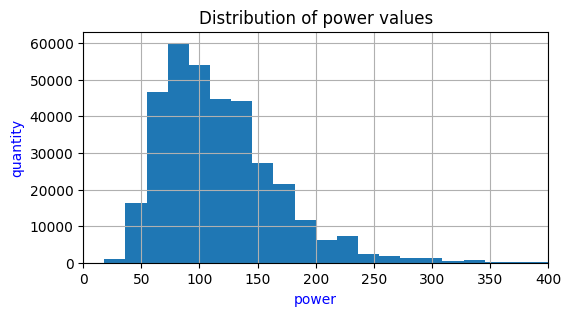

In [481]:
plt.figure(figsize=(6, 3))
plt.hist(data['power'], bins=1100)
plt.title('Distribution of power values')
plt.xlim(0,400)
plt.xlabel("power", color = 'blue')
plt.ylabel("quantity", color = 'blue')
plt.grid()

plt.show()

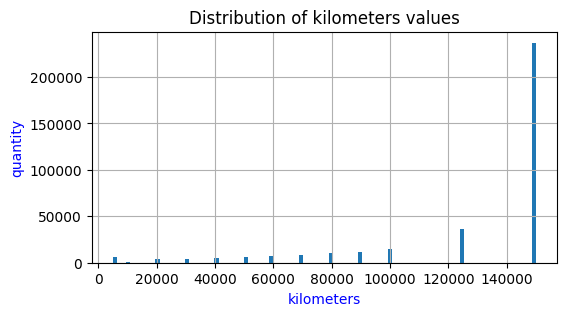

In [482]:
plt.figure(figsize=(6, 3))
data['kilometer'].hist(bins=100)
plt.title('Distribution of kilometers values')
plt.xlabel("kilometers", color = 'blue')
plt.ylabel("quantity", color = 'blue')
plt.show()

Большая часть автомобилей имеют огромный пробег, более 140000км.

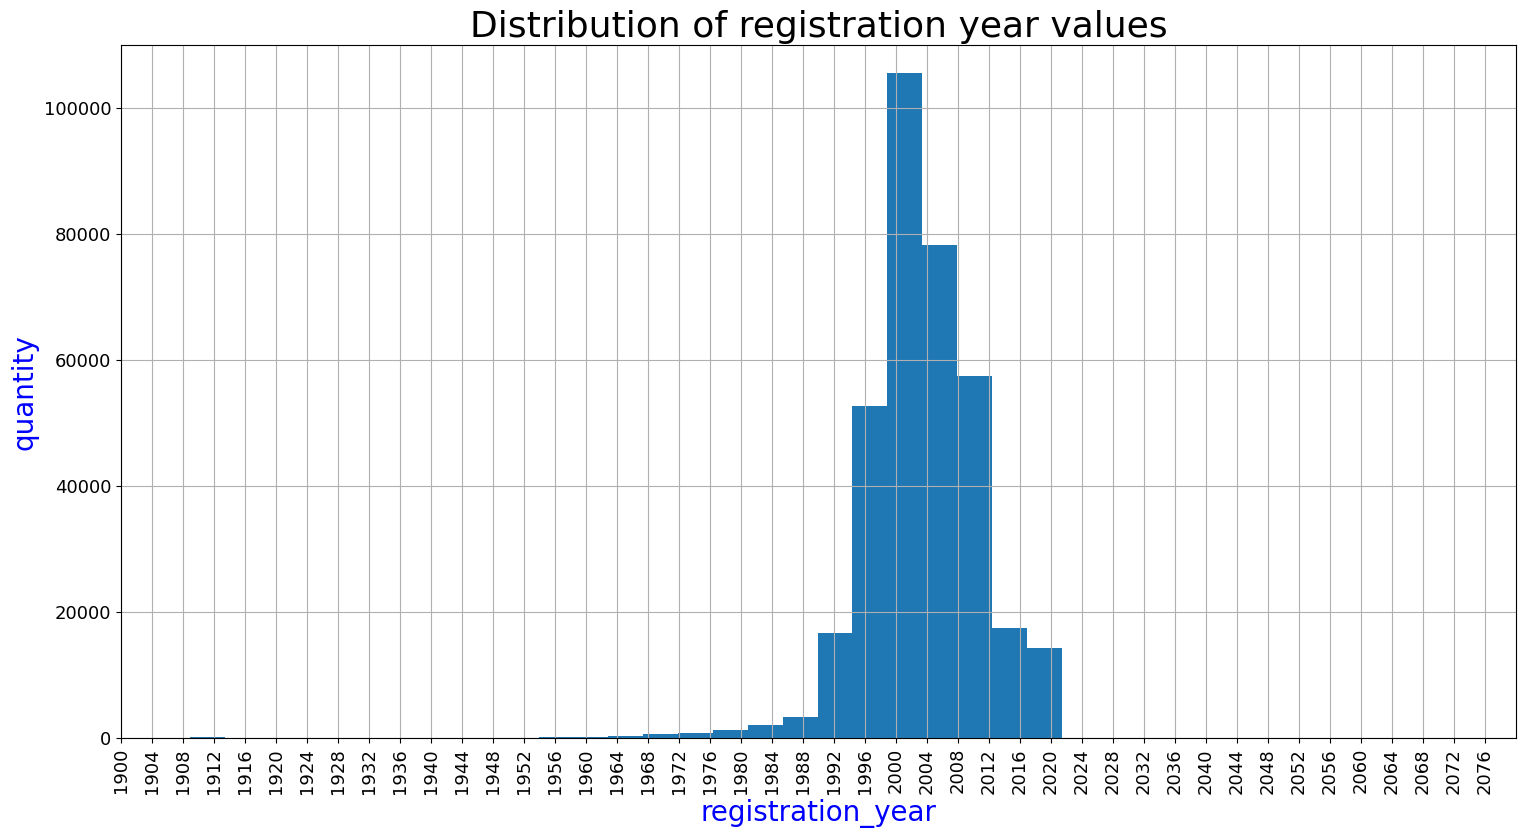

In [483]:
plt.figure(figsize=(18, 9))
data['registration_year'].hist(bins=2000)
plt.title('Distribution of registration year values', fontsize=26)
plt.ylim(0,110000)
plt.xlim(1900,2080)
plt.xlabel("registration_year", fontsize=20, color = 'blue')
plt.ylabel("quantity",  fontsize=20, color = 'blue')
plt.tick_params(axis='both', which='major', labelsize=13) # Размер шрифта значений по осям
plt.xticks(list(range(1900,2080,4)), rotation ='vertical')

plt.show()

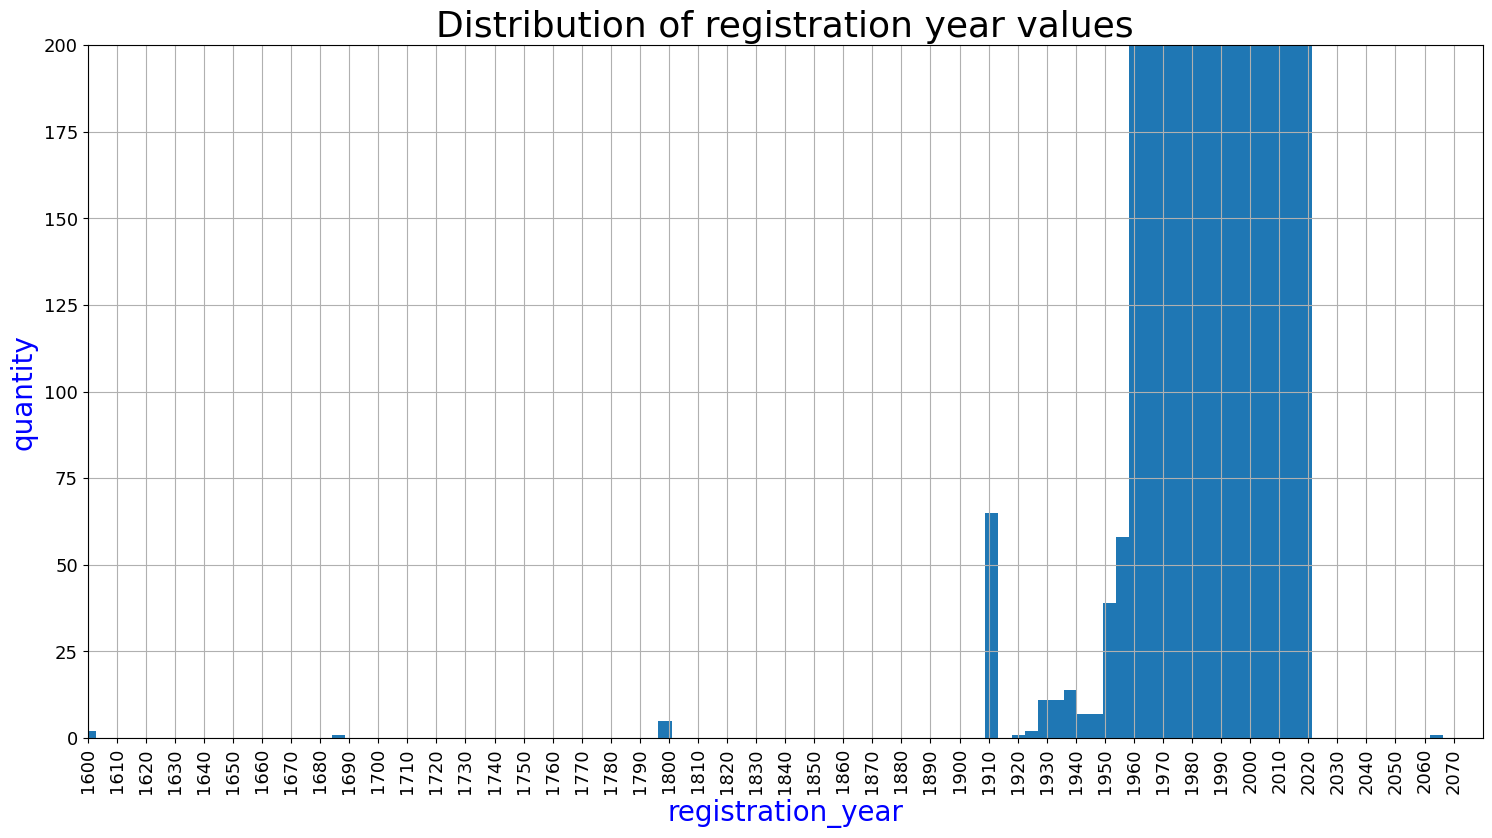

In [484]:
plt.figure(figsize=(18, 9))
data['registration_year'].hist(bins=2000)
plt.title('Distribution of registration year values', fontsize=26)
plt.ylim(0,200)
plt.xlim(1600,2080)
plt.xlabel("registration_year", fontsize=20, color = 'blue')
plt.ylabel("quantity",  fontsize=20, color = 'blue')
plt.tick_params(axis='both', which='major', labelsize=13) # Размер шрифта значений по осям
plt.xticks(list(range(1600,2080,10)), rotation ='vertical')

plt.show()

In [485]:
data.loc[((data['registration_year'] > 2022)|(data['registration_year'] < 1930))] # Выбросы

price vehicle_type  registration_year  gearbox   power   model  \
15        450        small               1910        0    60.0      ka   
622         0        small               1111        0    60.0   corsa   
6977      135        small               1910        0    60.0   corsa   
10183    1250        sedan               1910        0   109.0   other   
12946      49        sedan               5000        0    90.0    golf   
...       ...          ...                ...      ...     ...     ...   
338825     50        sedan               3000        0  3000.0    golf   
340755    700        sedan               1600        0  1600.0      a3   
341787      1          bus               3000        0   120.0  zafira   
343079      1        other               1910        0    90.0    golf   
351678  11500        sedan               1800        0   109.0   other   

        kilometer  registration_month fuel_type       brand  repaired  \
15           5000                   0    petrol        ford         0   
622          5000                   0    petrol        opel         0   
6977         5000                   0    petrol        opel         0   
10183        5000                   0    petrol        audi         0   
12946        5000                  12    petrol  volkswagen         0   
...           ...                 ...       ...         ...       ...   
338825     100000                   6    petrol  volkswagen         1   
340755     150000                   4    petrol        audi         2   
341787       5000                   0    petrol        opel         0   
343079       5000                   1     other  volkswagen         0   
351678       5000                   6    petrol        fiat         0   

        postal_code  
15            24148  
622           44628  
6977          19374  
10183         18445  
12946         74523  
...             ...  
338825        23992  
340755        86343  
341787        26624  
343079        18273  
351678        16515  

[210 rows x 12 columns]

In [486]:
data = data.loc[((data['registration_year'] <= 2022)&(data['registration_year'] >= 1930))] 

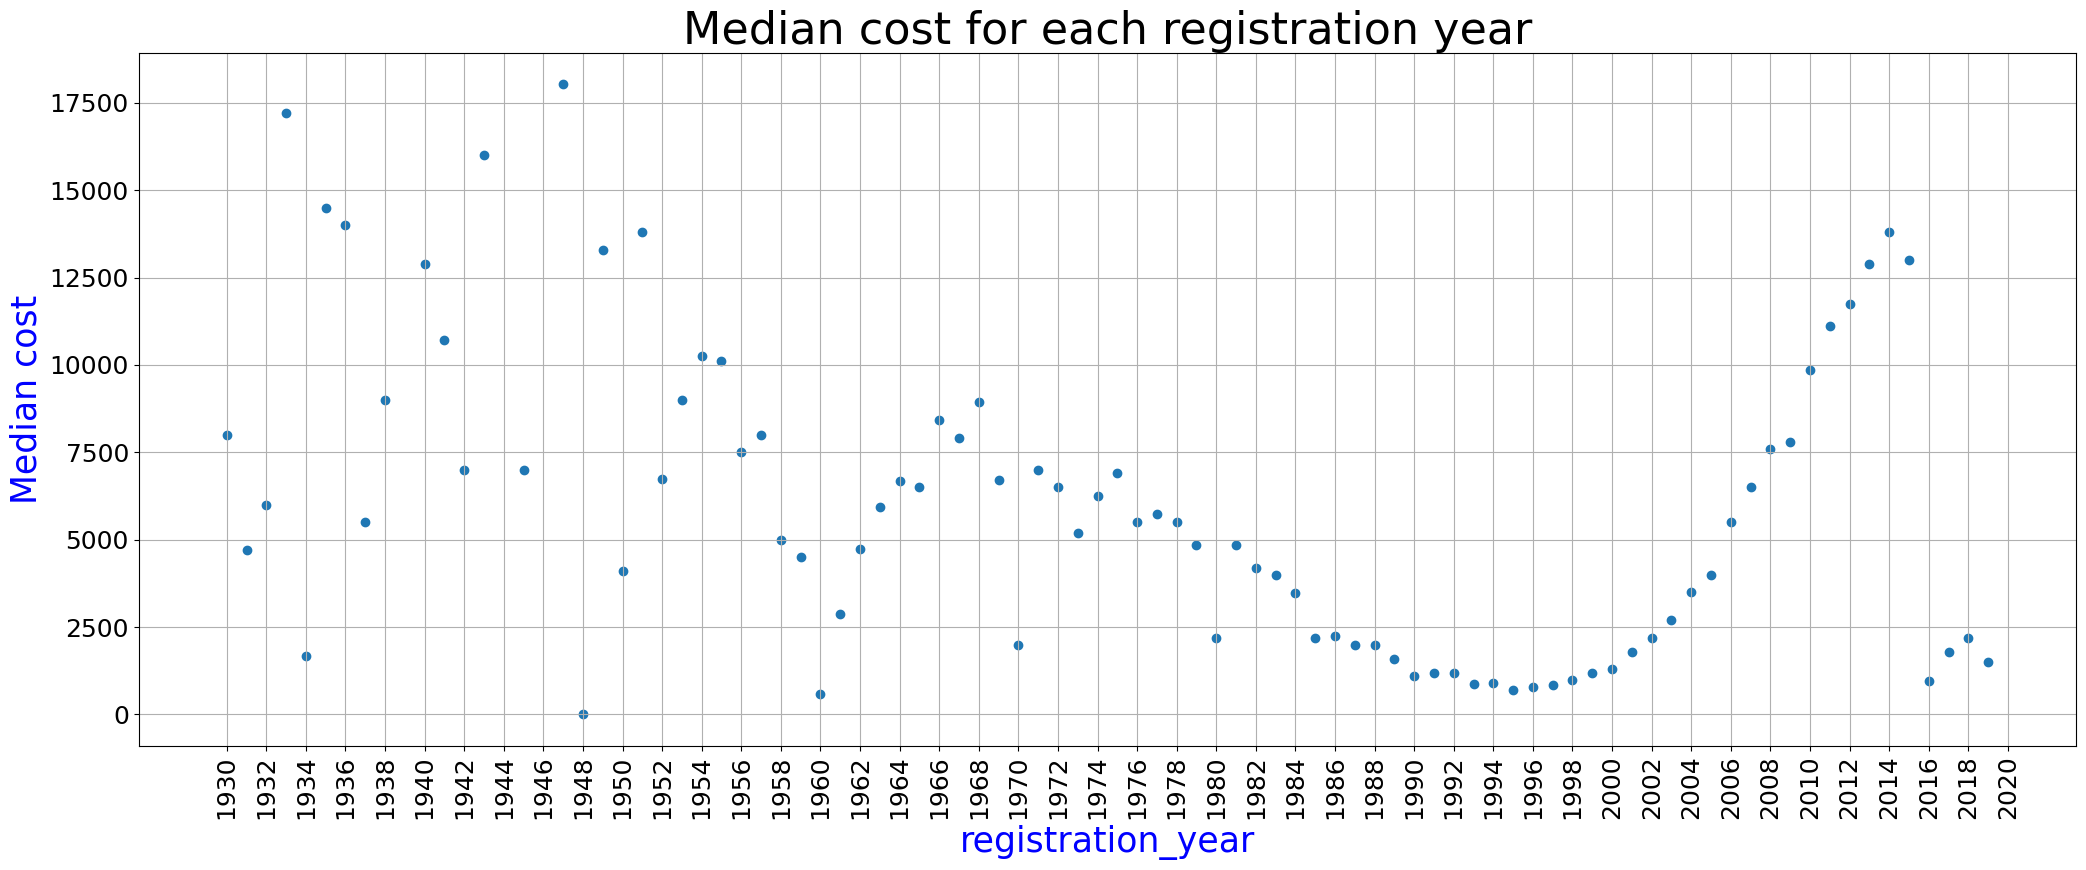

In [487]:
plt.figure(figsize=(25, 9))
plt.scatter(x=data.groupby('registration_year')['price'].median().index, y=data.groupby('registration_year')['price'].median())      
plt.xlabel("registration_year", fontsize=25, color = 'blue')
plt.ylabel("Median cost", fontsize=25, color = 'blue')
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=18)
plt.title('Median cost for each registration year', fontsize=32)
plt.xticks(list(range(1930,2022,2)), rotation ='vertical')

plt.show()

До 1970 хаотичная медианная цена, после наблюдается падение до 1995 и рост медианной цены начиная с 1995 года, затем падение после 2015.  

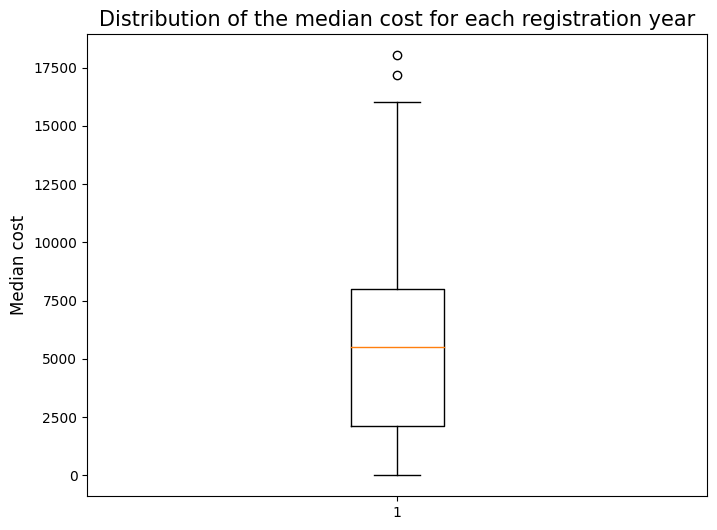

In [488]:
plt.rcParams["figure.figsize"] = (8,6) # Распределение медианной для каждого года цены
plt.boxplot(data.groupby('registration_year')['price'].median())
plt.title('Distribution of the median cost for each registration year', fontsize=15)
plt.ylabel("Median cost", fontsize=12)
plt.show()

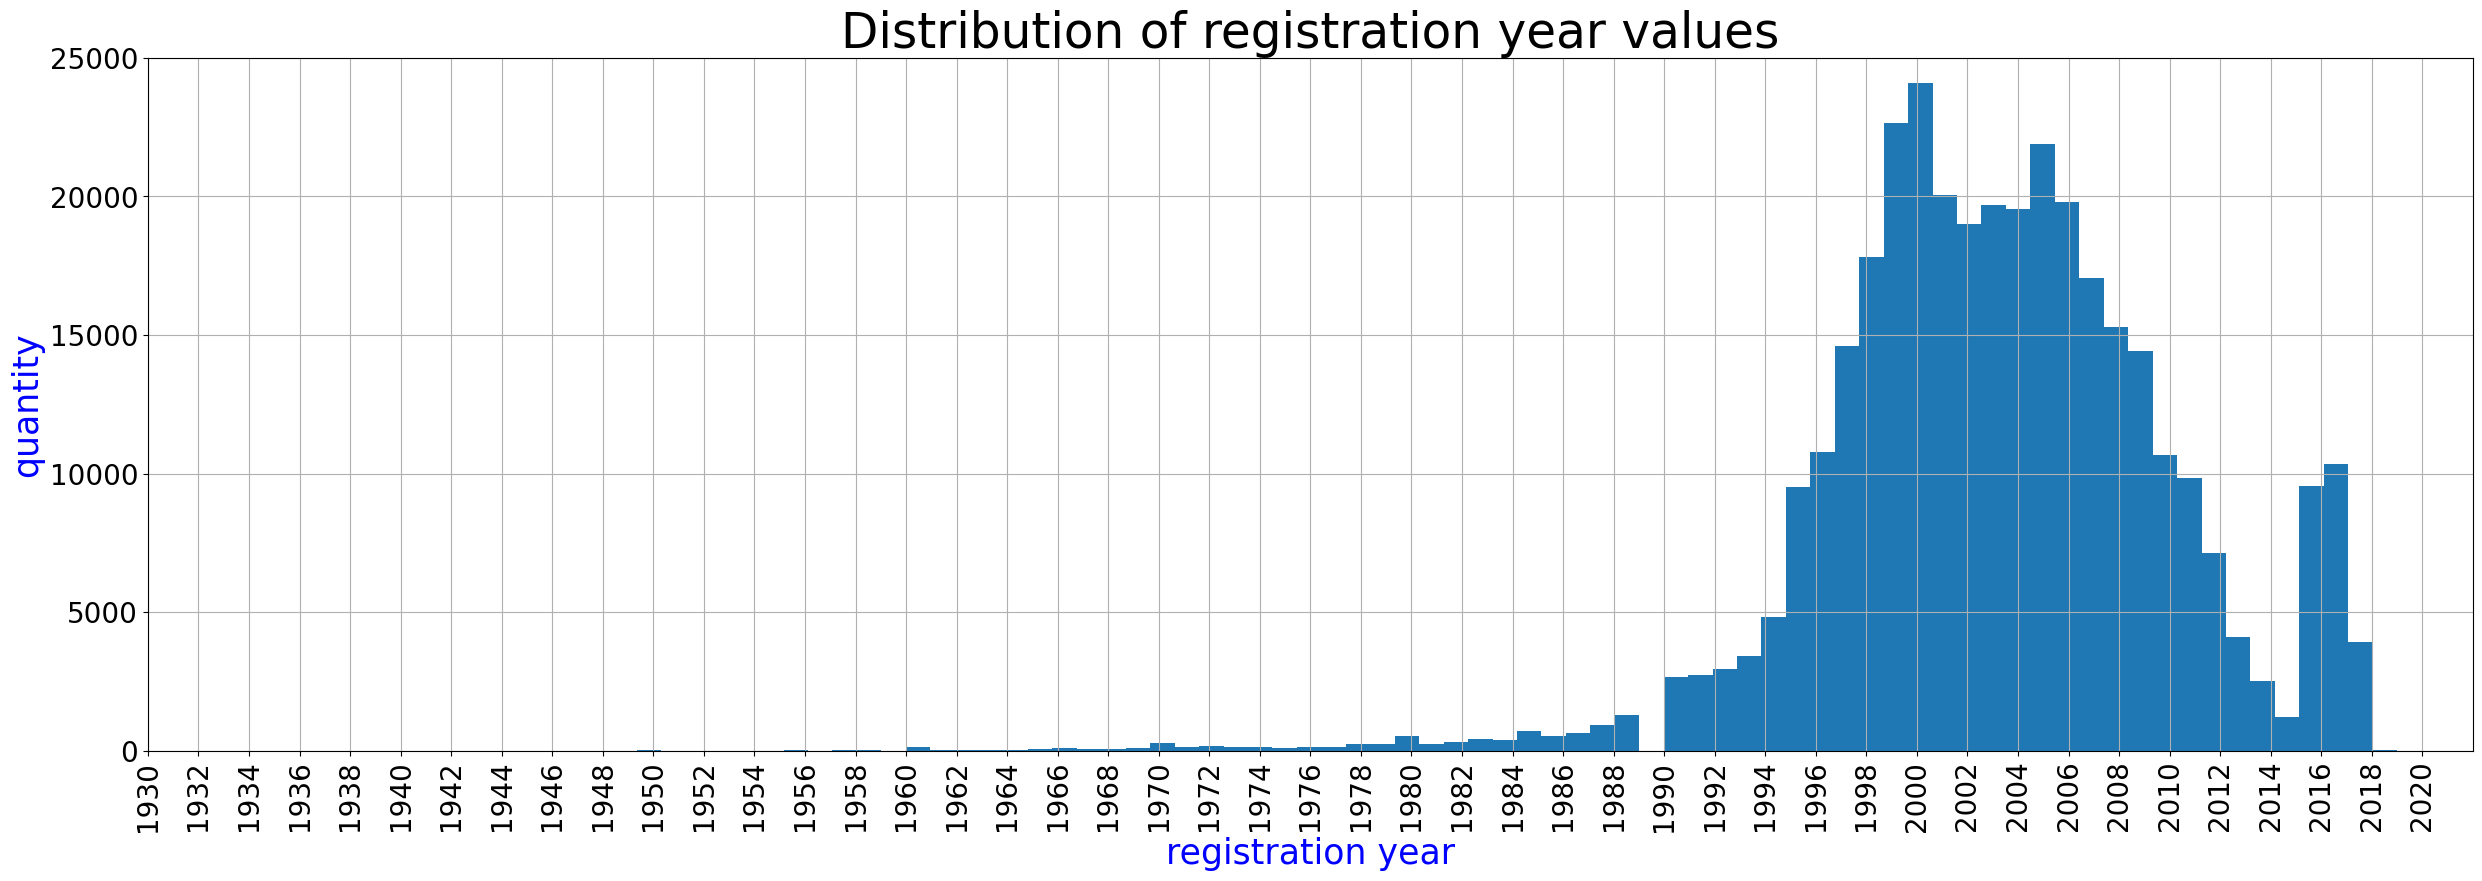

In [489]:
plt.figure(figsize=(30, 9))
data['registration_year'].hist(bins=92)
plt.title('Distribution of registration year values', fontsize=35)
plt.ylim(0,25000)
plt.xlim(1930,2022)
plt.xlabel("registration year", fontsize=25, color = 'blue')
plt.ylabel("quantity", fontsize=25, color = 'blue')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xticks(list(range(1930,2022,2)), rotation ='vertical')
plt.show()

Большая часть данных сосредоточена с 1980 по 2018 годы. Также до 1970 года медианная цена хаотична, поэтому далее будем рассматривать данные за 1980-2018 годы.

In [490]:
data = data.loc[((data['registration_year'] <= 2016)&(data['registration_year'] >= 1980))]

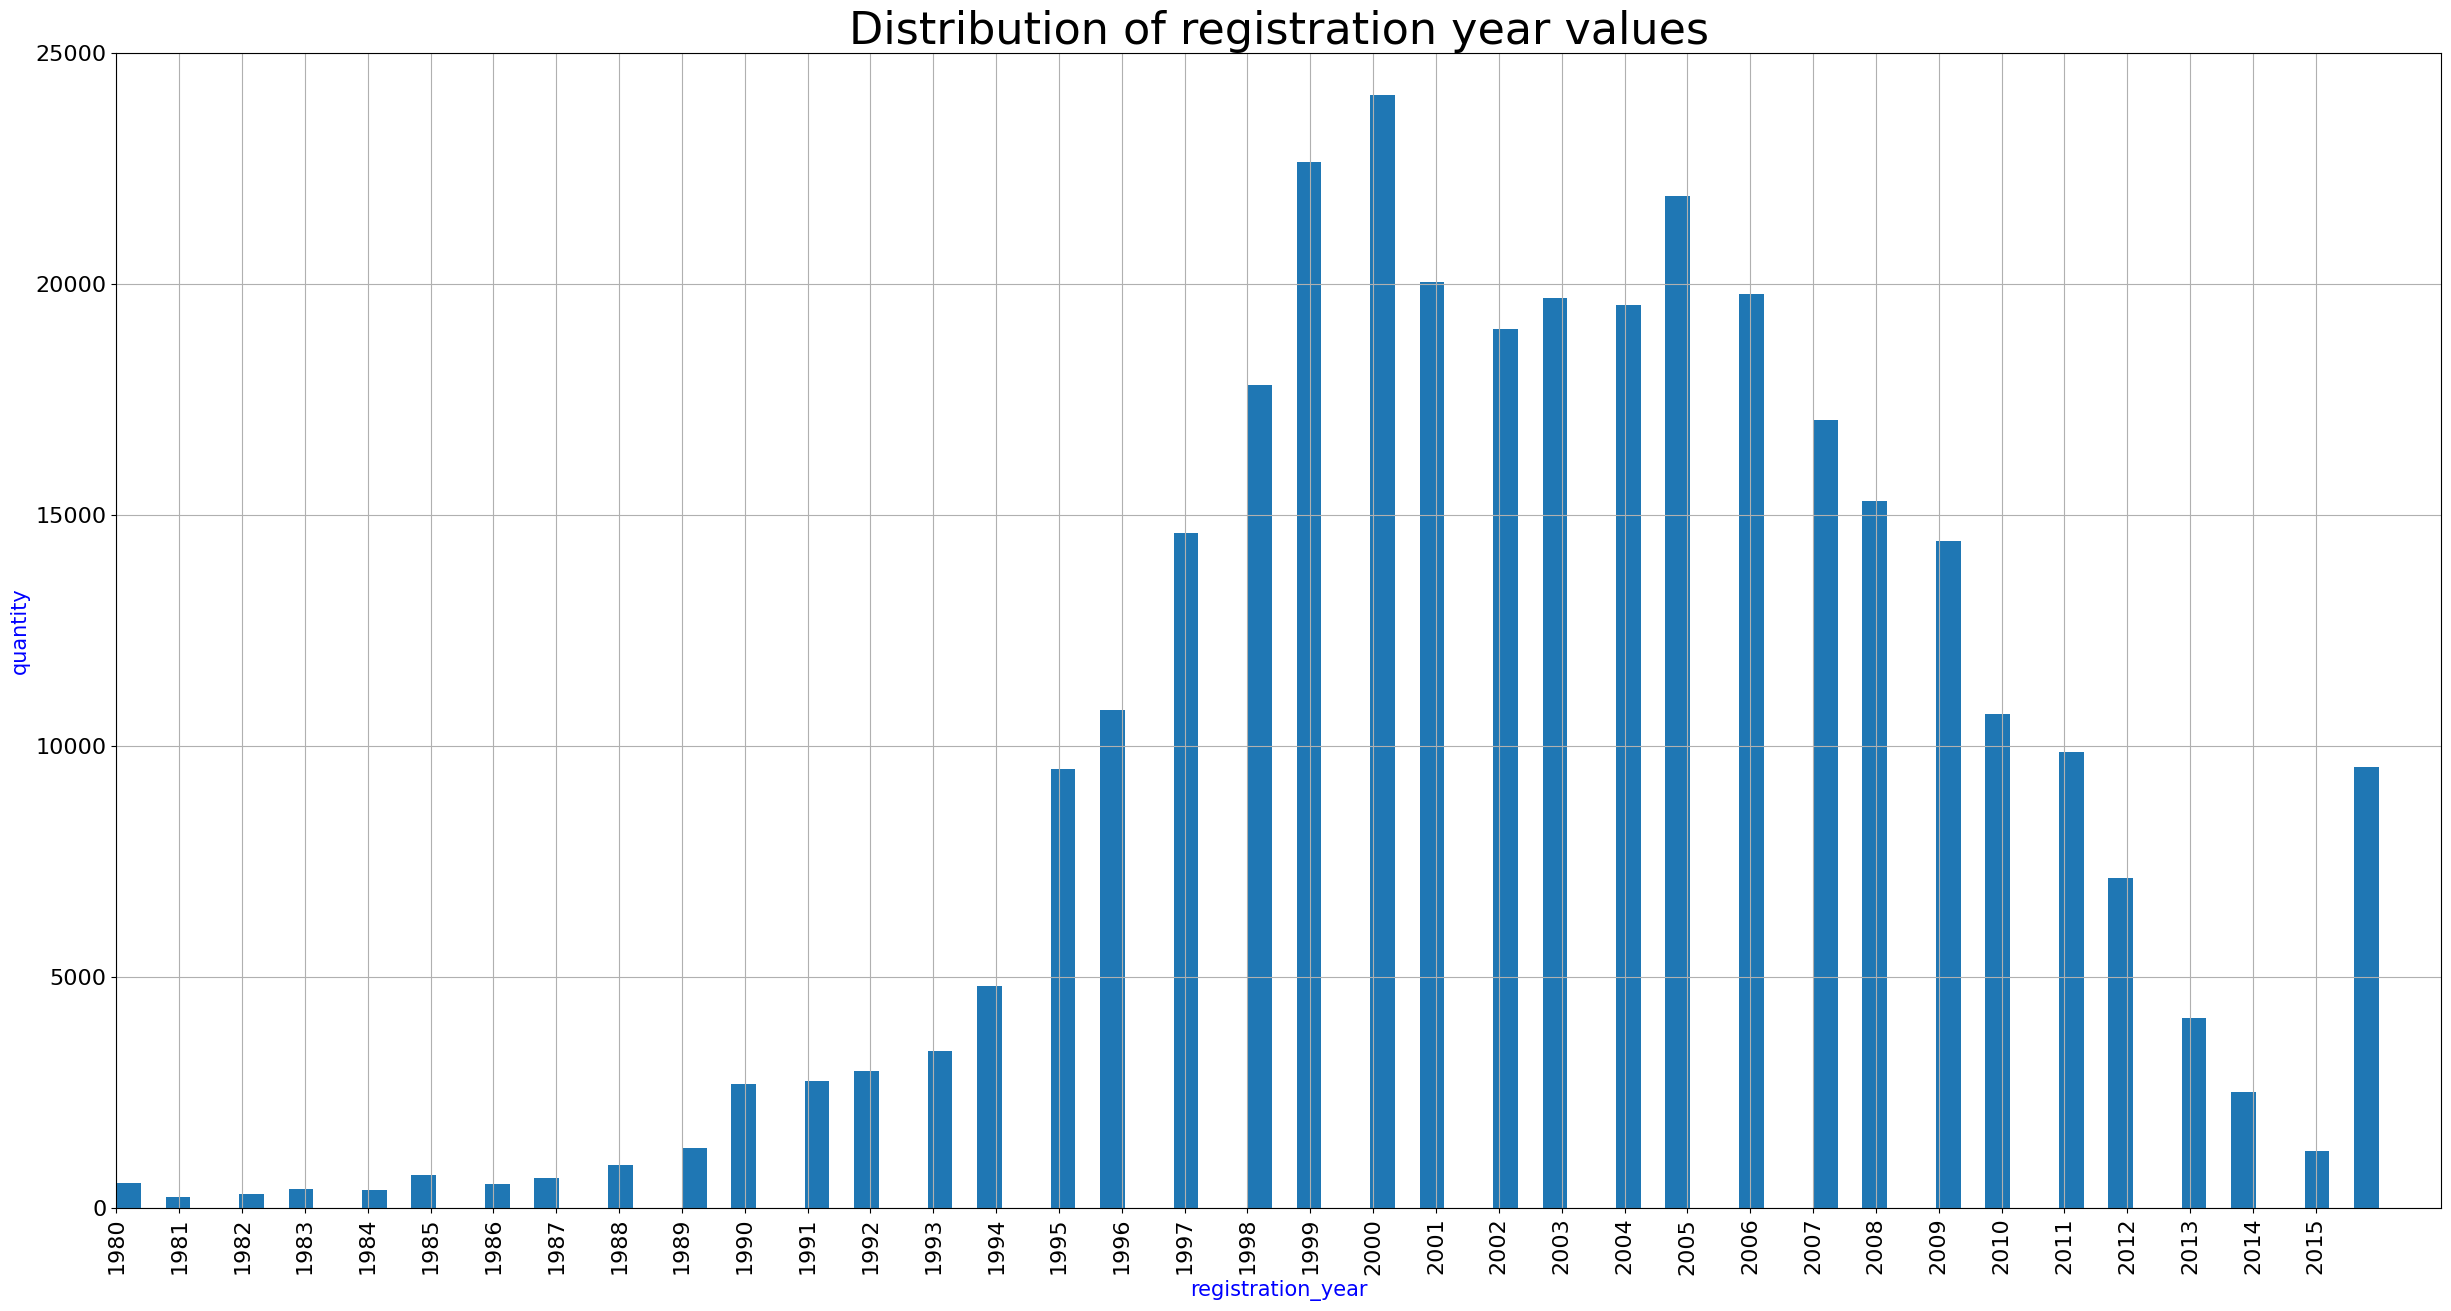

In [491]:
plt.figure(figsize=(30, 15))
data['registration_year'].hist(bins=92)
plt.title('Distribution of registration year values', fontsize=32)
plt.ylim(0,25000)
plt.xlim(1980,2017)
plt.xlabel("registration_year", fontsize=15, color = 'blue')
plt.ylabel("quantity", fontsize=15, color = 'blue')
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xticks(list(range(1980,2016,1)), rotation ='vertical')
plt.show()

In [492]:
print('Коэффициент корреляции Пирсона для registration_month и price:', data['registration_month'].corr(data['price']))

Коэффициент корреляции Пирсона для registration_month и price: 0.10615466396234567


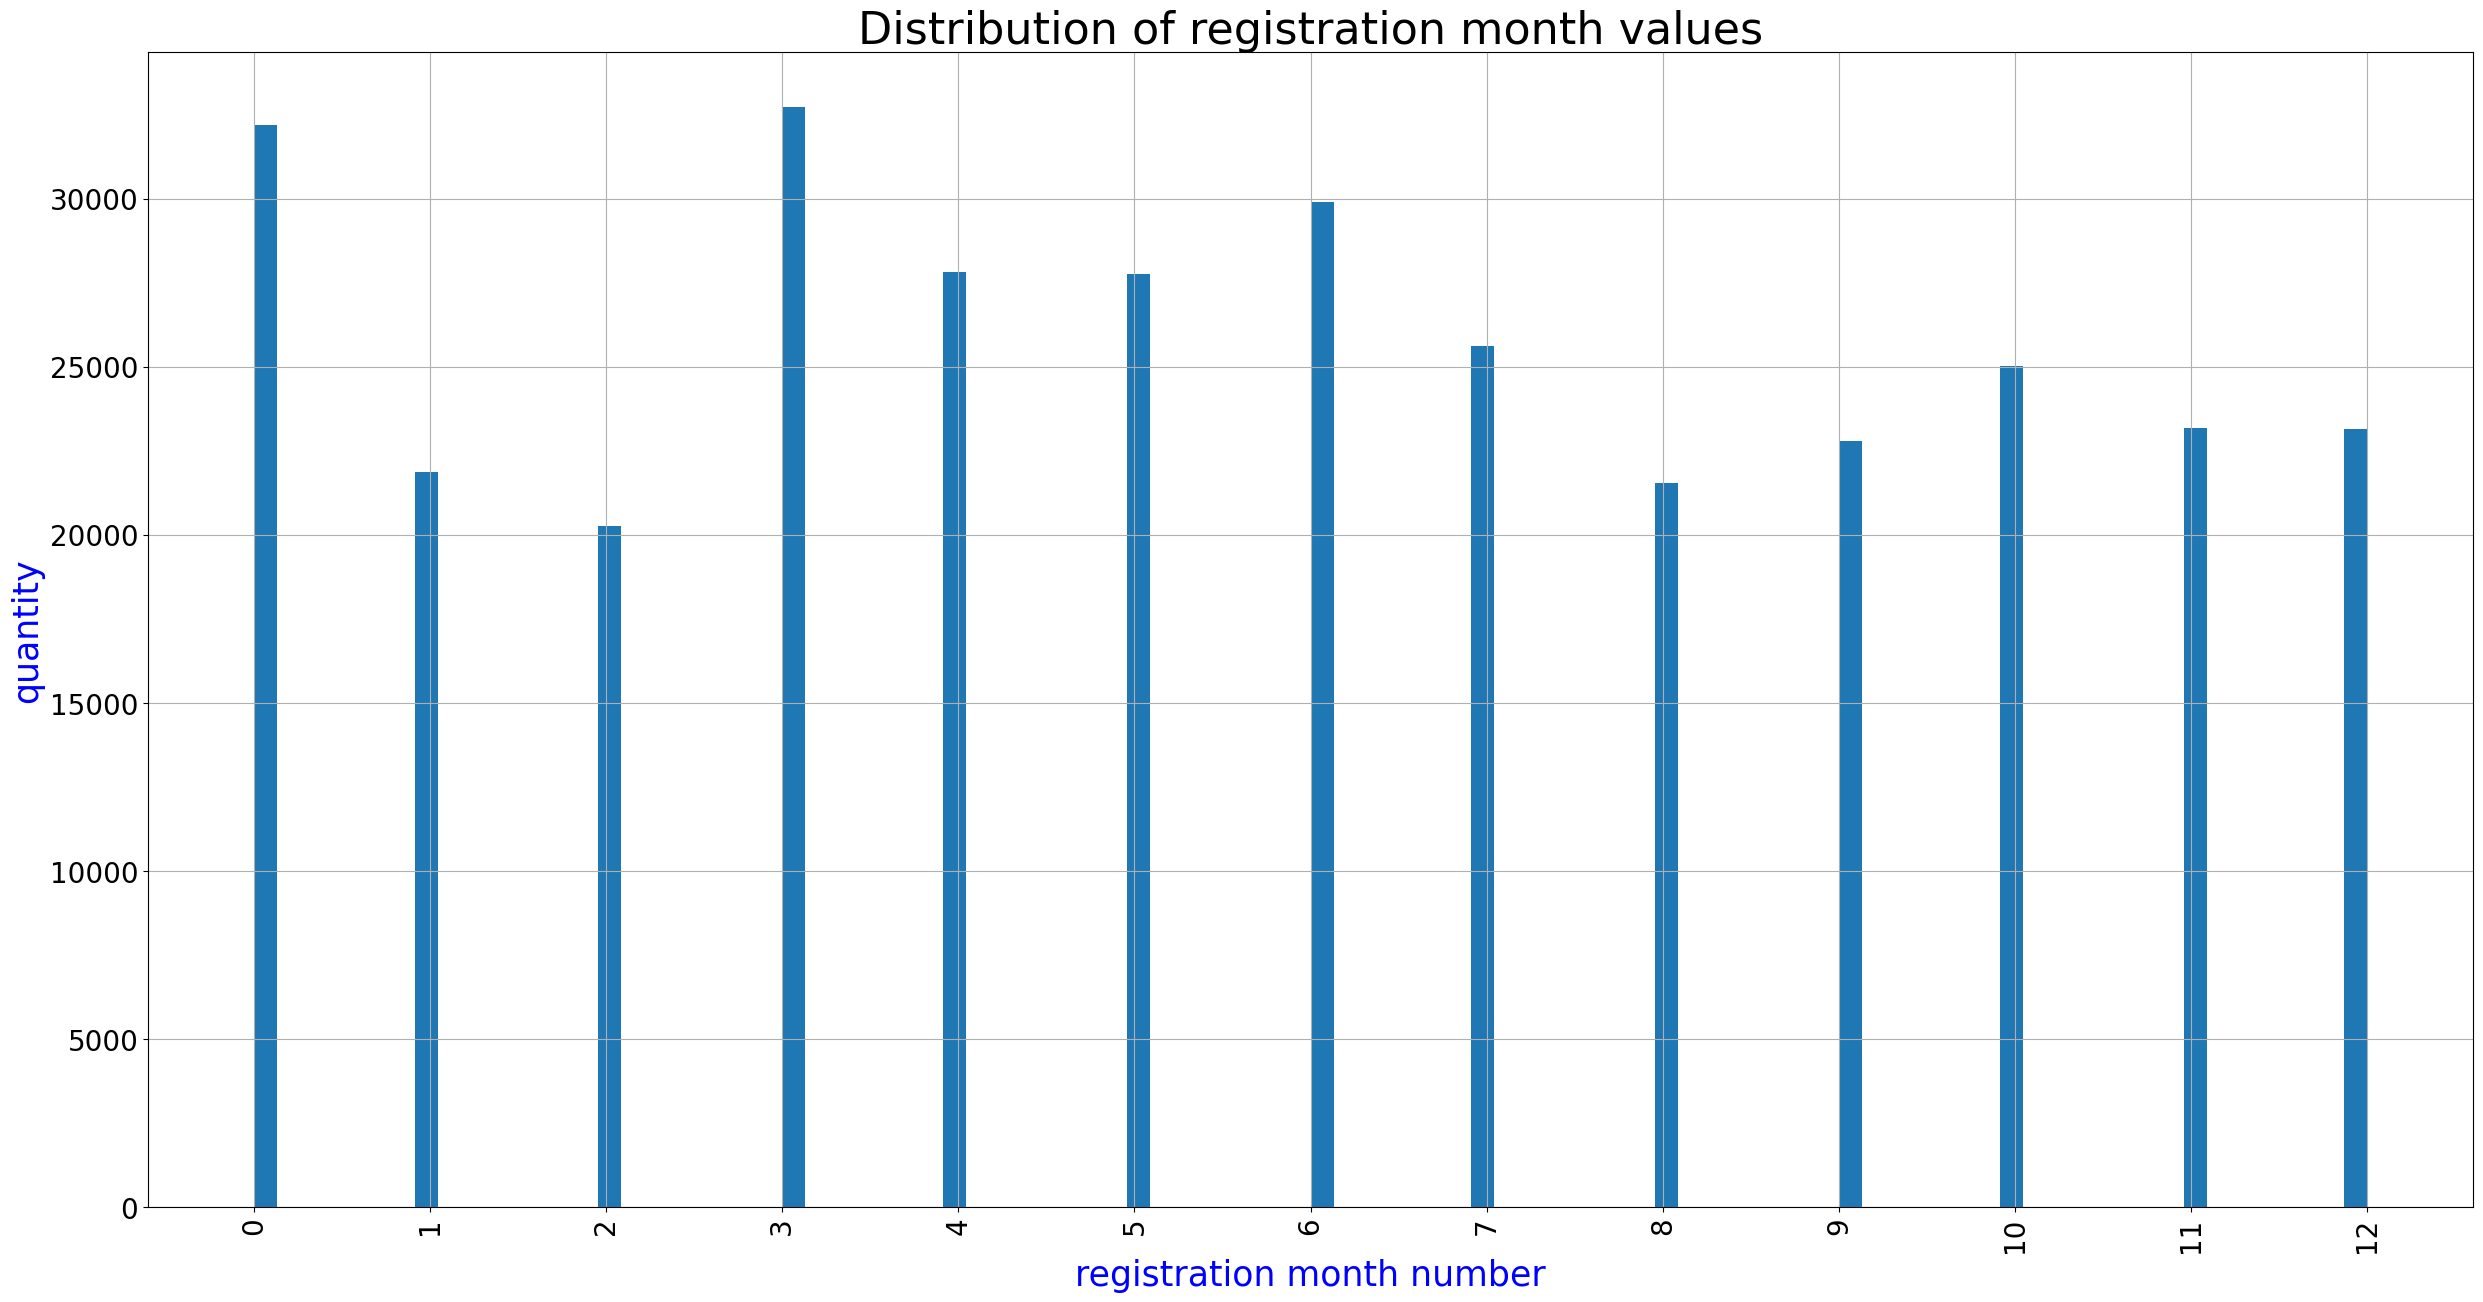

In [493]:
plt.figure(figsize=(30, 15))
data['registration_month'].hist(bins=92)
plt.title('Distribution of registration month values', fontsize=32)
#plt.ylim(0,25000)
#plt.xlim(1980,2019)
plt.xlabel("registration month number", fontsize=25, color = 'blue')
plt.ylabel("quantity", fontsize=25, color = 'blue')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xticks(list(range(0,13,1)), rotation ='vertical')

plt.show()

Значение месяца 0 - выброс.

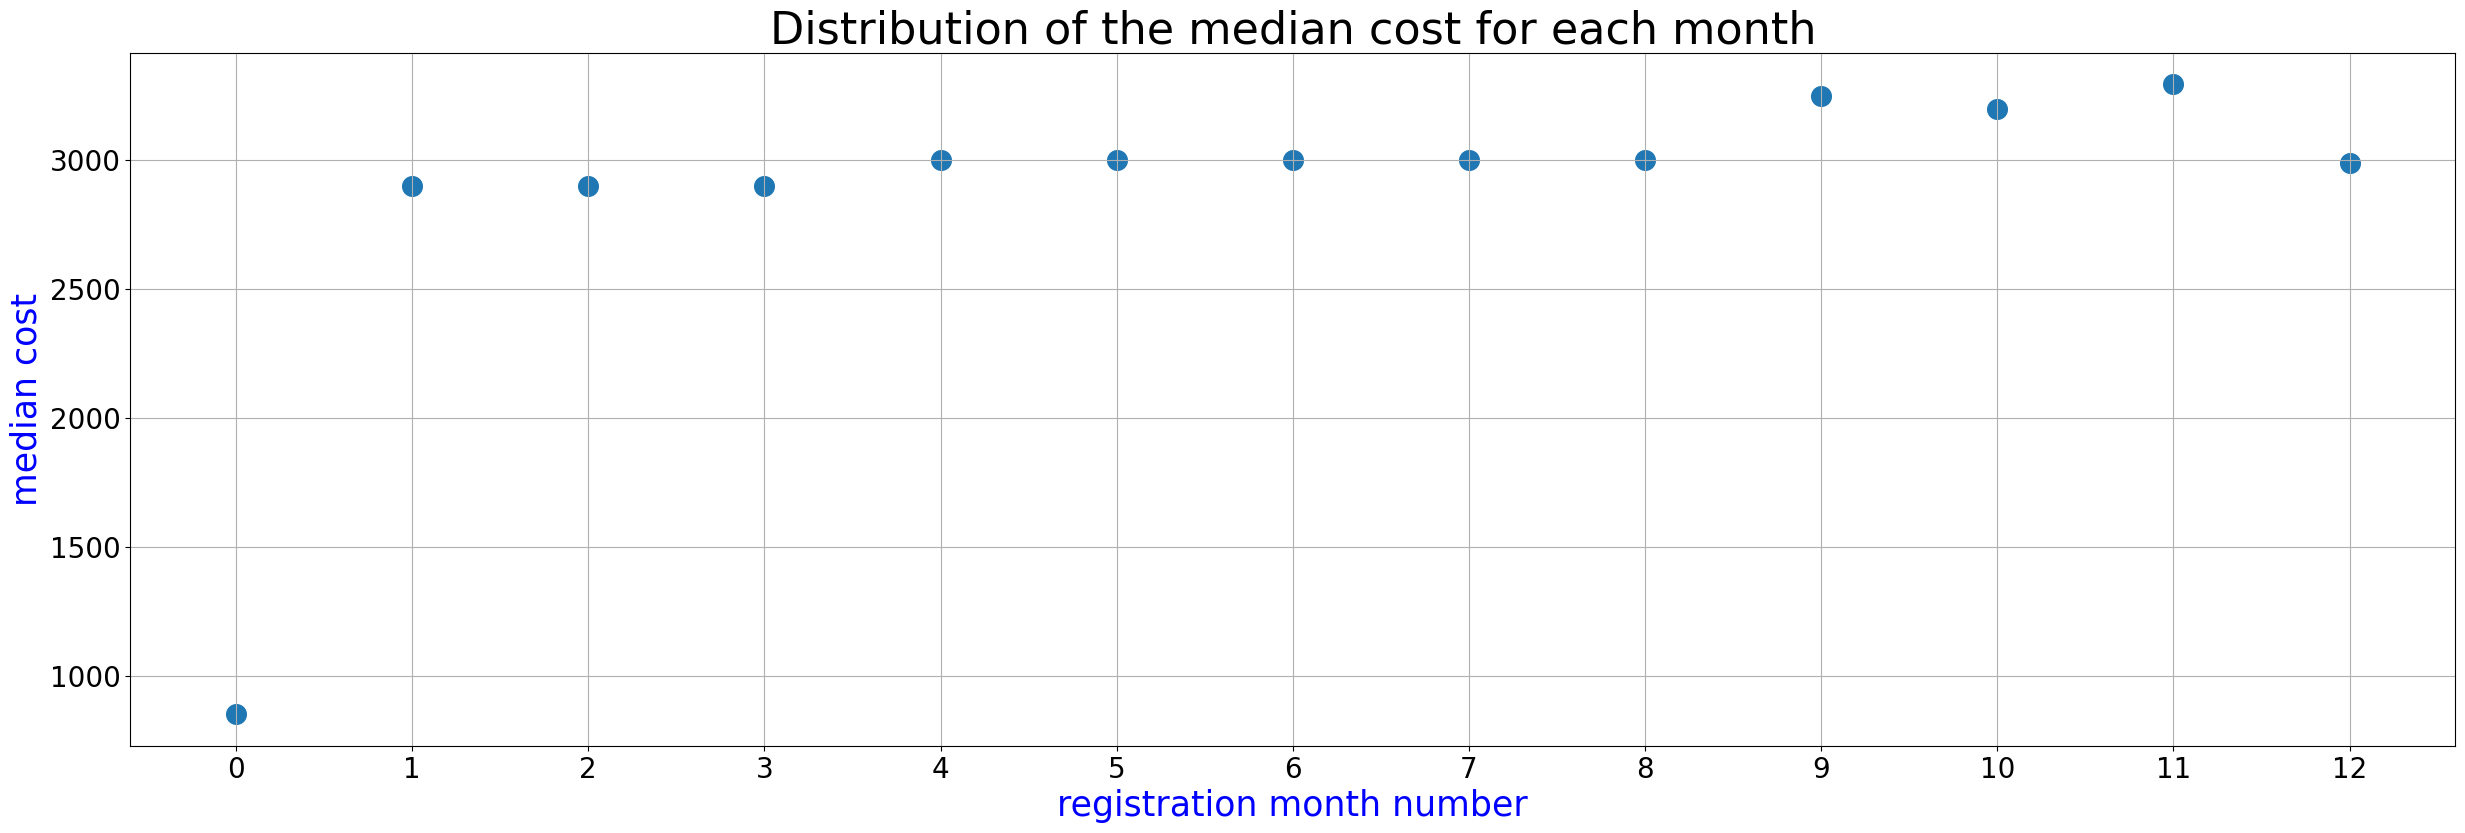

In [494]:
plt.figure(figsize=(30, 9))
plt.scatter(x=data.groupby('registration_month')['price'].median().index, y=data.groupby('registration_month')['price'].median(), s=200)      
plt.xlabel("registration month number", fontsize=25, color = 'blue')
plt.ylabel("median cost", fontsize=25, color = 'blue')
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title('Distribution of the median cost for each month', fontsize=32)
plt.xticks(list(range(0,13,1)))

plt.show()

Медианная цена примерно одинакова для каждого месяца, кроме нулевого (выброс).

In [495]:
data.loc[data['registration_month'] == 0]

price vehicle_type  registration_year  gearbox  power    model  \
0         480        sedan               1993        0   90.0     golf   
9         999        small               1998        0  101.0     golf   
16        300        small               2016        0   60.0     polo   
36       1600        other               1991        0   75.0   kadett   
54       4700        wagon               2005        0  155.0   signum   
...       ...          ...                ...      ...    ...      ...   
354301   3500        small               1995        0   60.0     polo   
354314    400        wagon               1991        0  125.0   legacy   
354322   1300        small               1999        0   75.0  2_reihe   
354325    350        small               1996        0   65.0    punto   
354333  11500        sedan               2004        1  445.0      7er   

        kilometer  registration_month fuel_type       brand  repaired  \
0          150000                   0    petrol  volkswagen         0   
9          150000                   0    petrol  volkswagen         0   
16         150000                   0    petrol  volkswagen         0   
36          70000                   0    petrol        opel         0   
54         150000                   0  gasoline        opel         2   
...           ...                 ...       ...         ...       ...   
354301     150000                   0    petrol  volkswagen         0   
354314     150000                   0    petrol      subaru         0   
354322     125000                   0    petrol     peugeot         0   
354325     150000                   0    petrol        fiat         0   
354333     125000                   0    petrol         bmw         0   

        postal_code  
0             70435  
9             27472  
16            38871  
36             2943  
54            88433  
...             ...  
354301        74579  
354314        24558  
354322        35102  
354325        25436  
354333         4107  

[32199 rows x 12 columns]

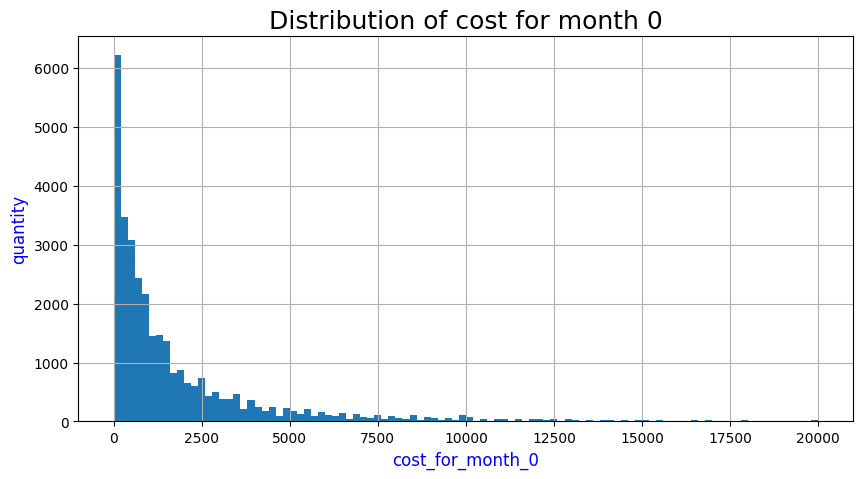

In [496]:
plt.figure(figsize=(10, 5))
plt.title('Distribution of cost for month 0', fontsize=18)
data.loc[data['registration_month'] == 0, 'price'].hist(bins=100)
plt.xlabel("cost_for_month_0", fontsize=12, color = 'blue')
plt.ylabel("quantity", fontsize=12, color = 'blue')

plt.show()

сложно предположить почему для нулевого месяца медианная цена низкая, этот признак не будем использовать при обучении, так как медианные цены в остальные месяцы примерно одинаковы

In [497]:
data = data.drop(labels=['registration_month'], axis=1) 

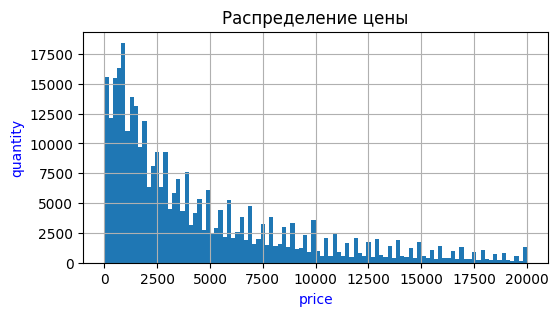

In [498]:
# Проверка на адекватность значений
plt.figure(figsize=(6, 3))
data['price'].hist(bins=100)
plt.title('Распределение цены')
plt.xlabel("price", color = 'blue')
plt.ylabel("quantity", color = 'blue')

plt.show()

Цены близкие к 0 могут существовать на сайтах о продаже, возможно автомобиль был в аварии и продается как донор.

In [499]:
data.groupby('postal_code')['price'].median() # Медианные значения стоимости авто для каждого почтового индекса


postal_code
1067      3590.0
1068     13299.0
1069      2200.0
1097      2236.0
1099      3700.0
          ...   
99988     2500.0
99991     3000.0
99994     4727.5
99996      500.0
99998     2000.0
Name: price, Length: 8136, dtype: float64

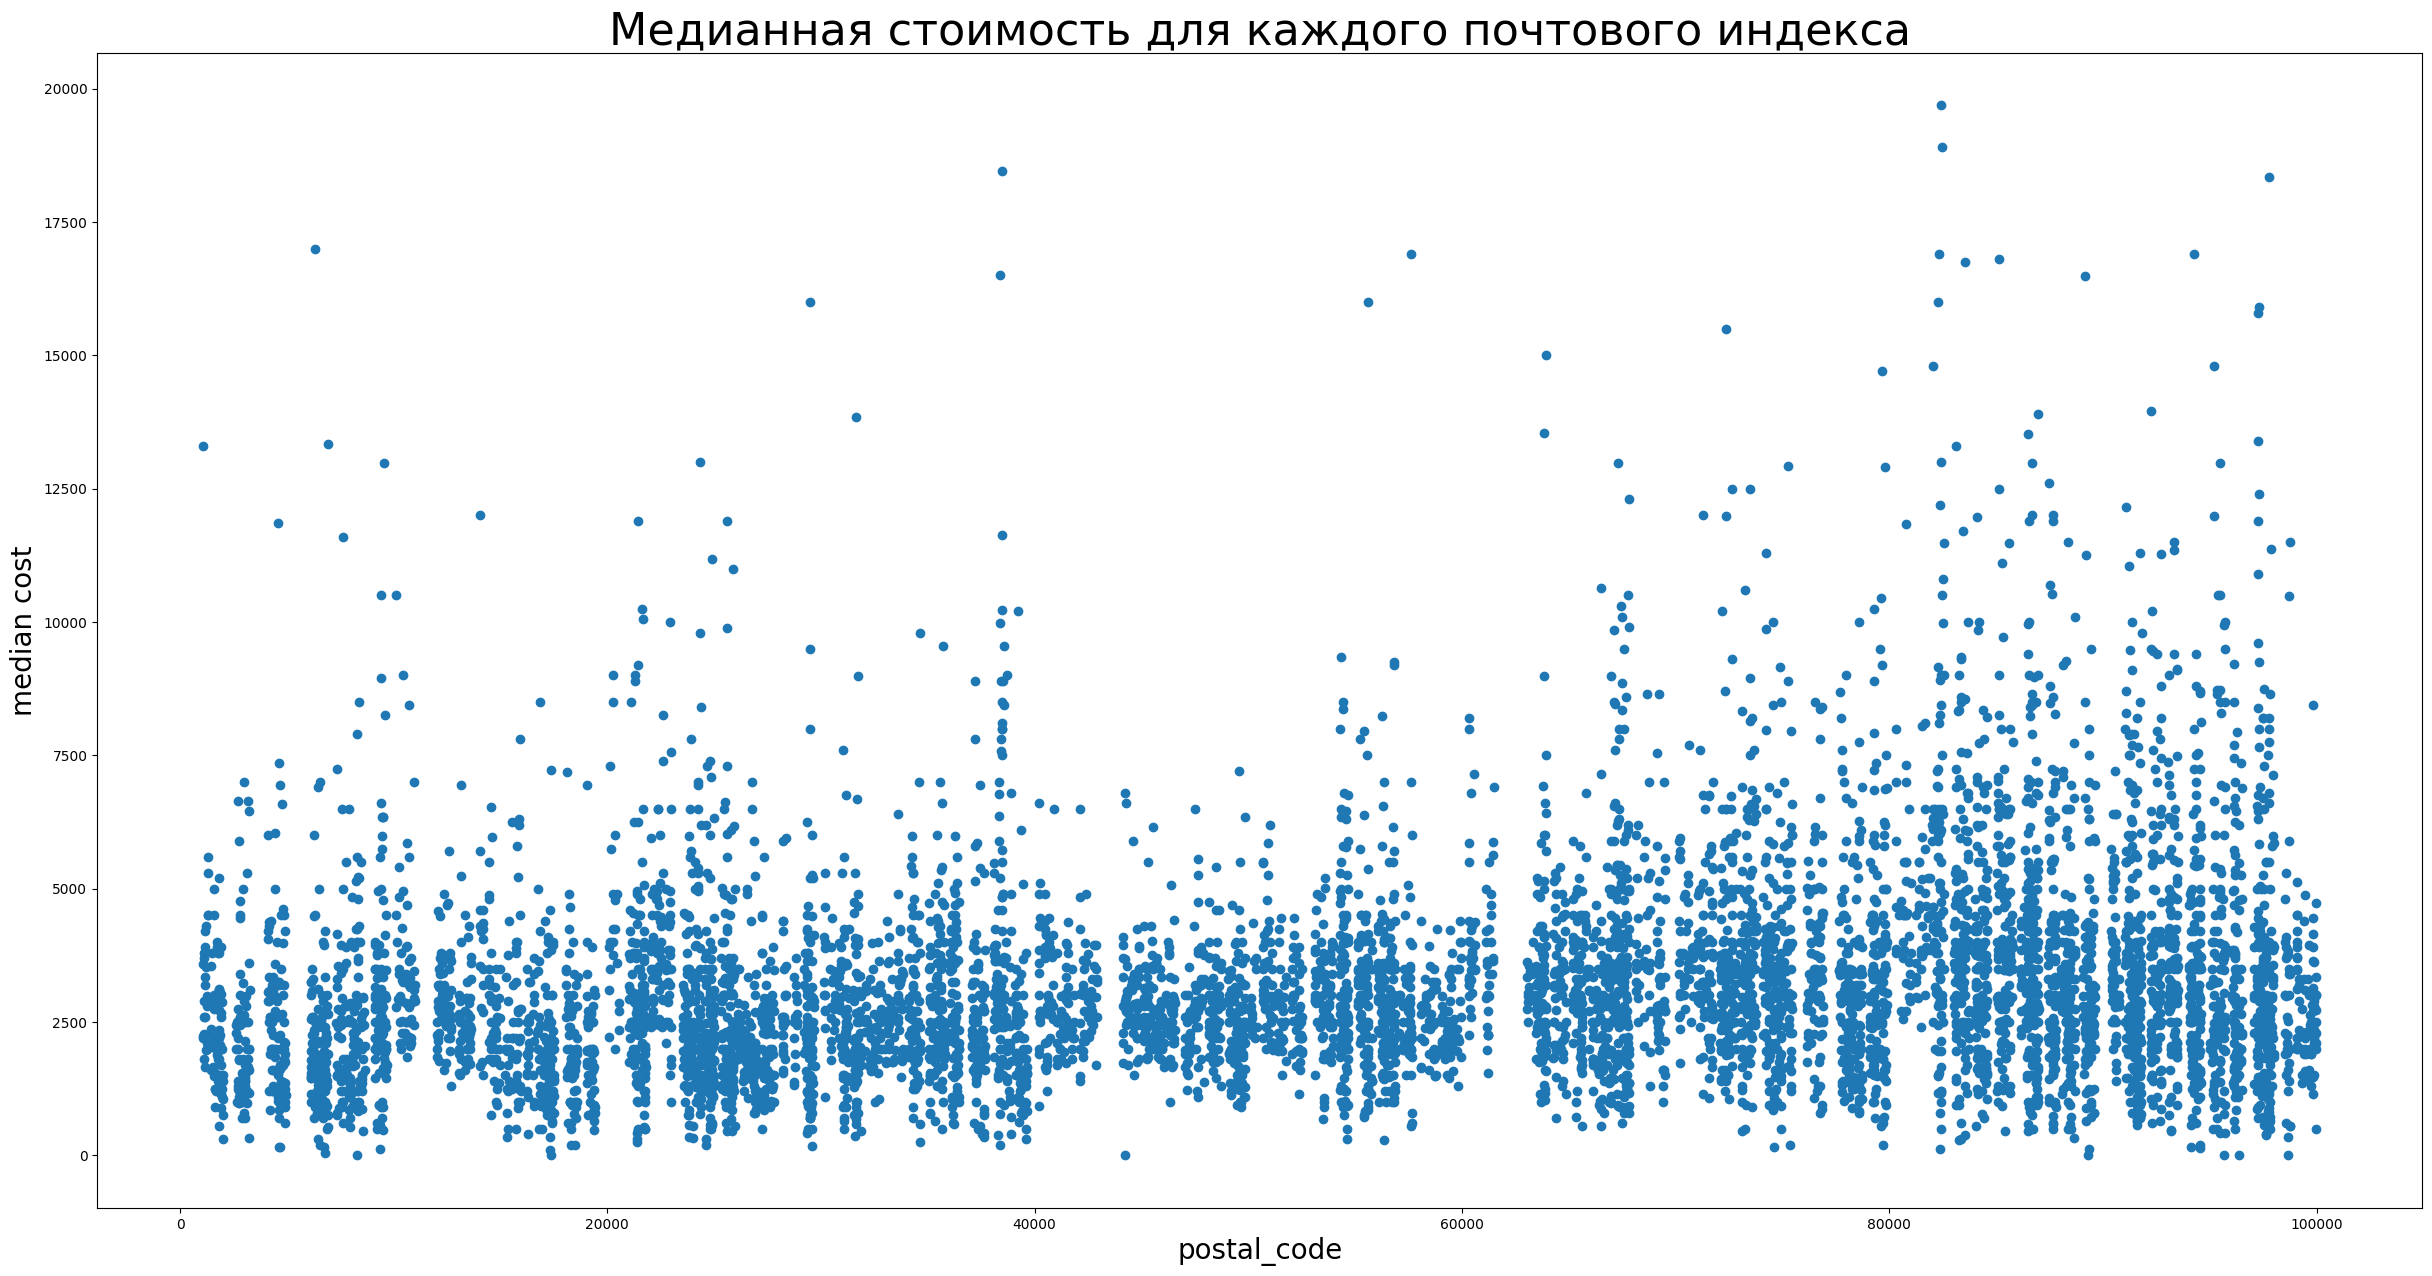

In [500]:
plt.figure(figsize=(30, 15))
plt.scatter(x=data.groupby('postal_code')['price'].median().sort_values().index, y=data.groupby('postal_code')['price'].median().sort_values())      
plt.xlabel("postal_code", fontsize=20)
plt.ylabel("median cost", fontsize=20)
plt.title('Медианная стоимость для каждого почтового индекса', fontsize=32)

plt.show()

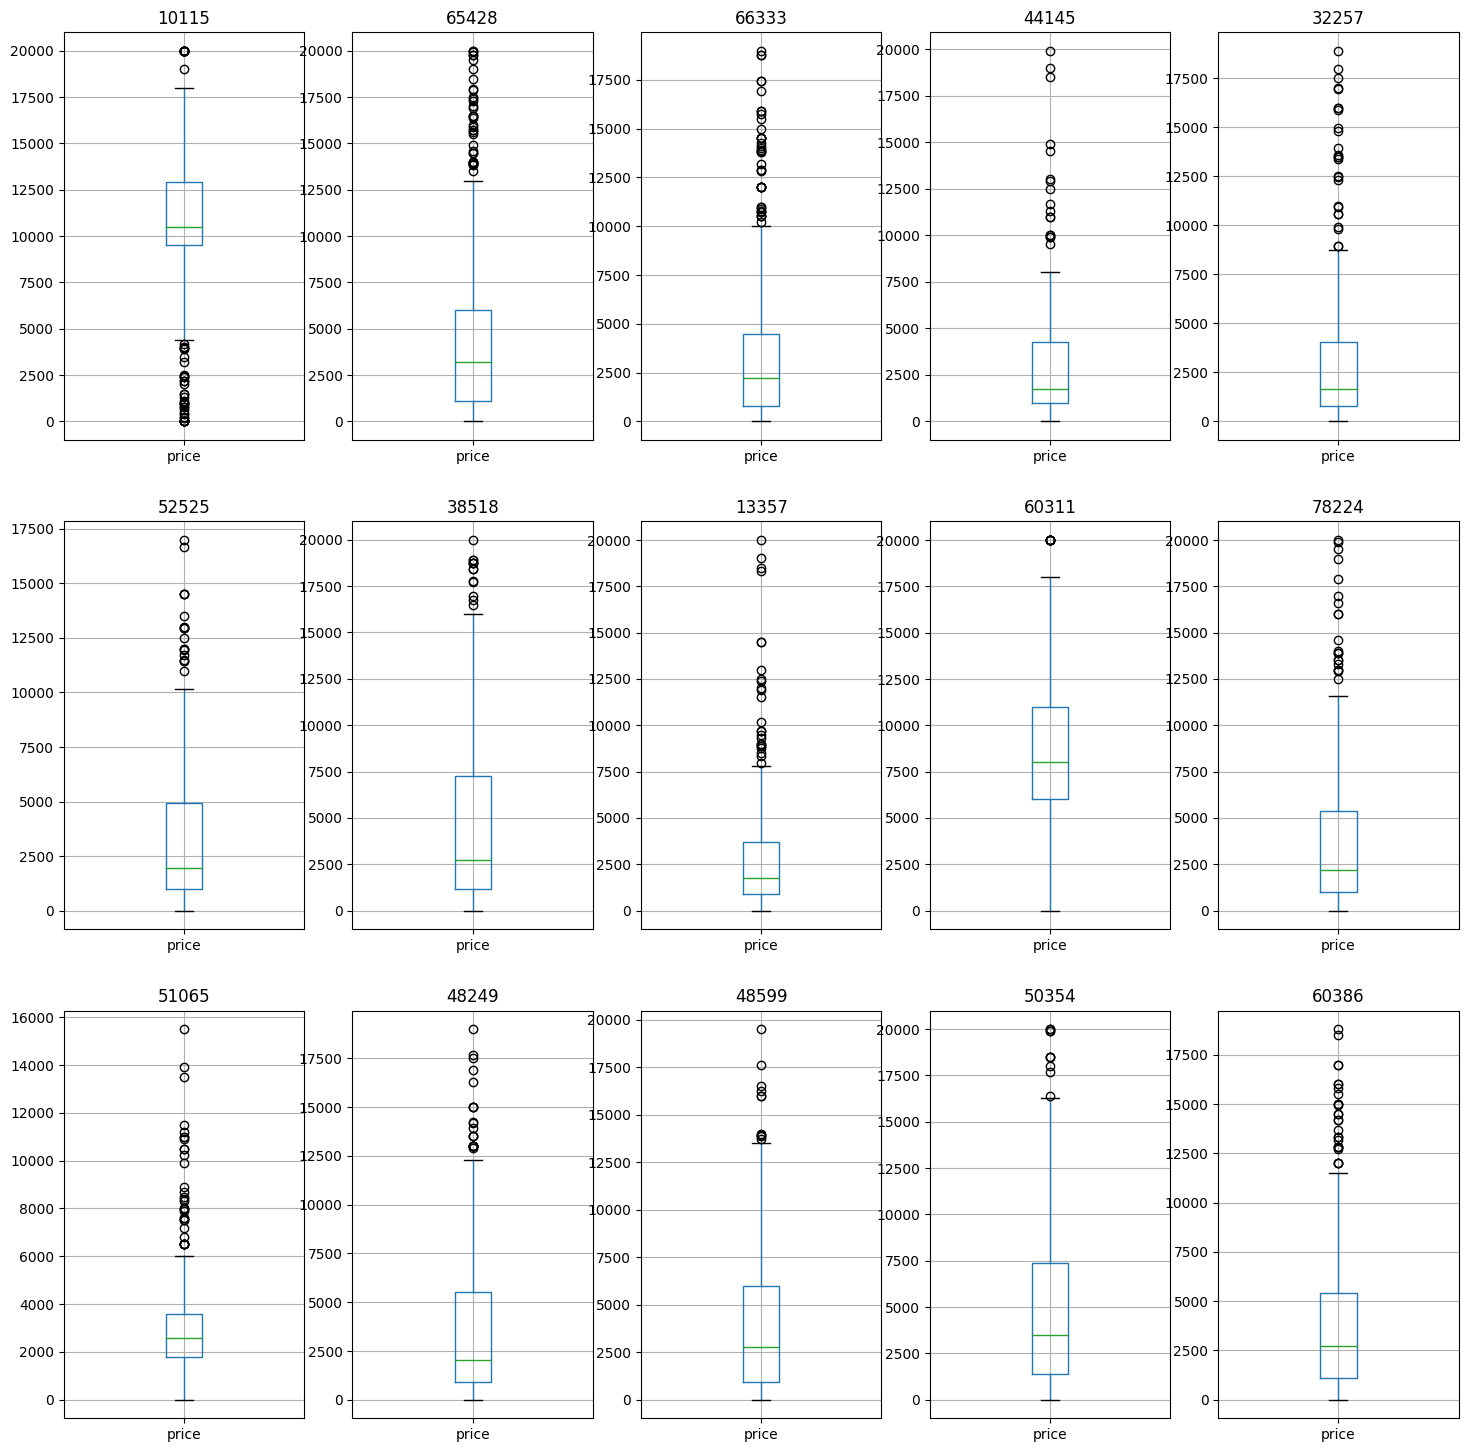

In [501]:
plt.rcParams["figure.figsize"] = (18,18) # Распределение цены для нескольких почтовых индексов
plt_index = 1
for postal in data.groupby('postal_code')['postal_code'].count().sort_values(ascending=False).index[:15]:
    plt.subplot(3, 5, plt_index)
    data[data['postal_code'] == postal].boxplot('price')
    plt.title(postal)
    plt_index = plt_index + 1

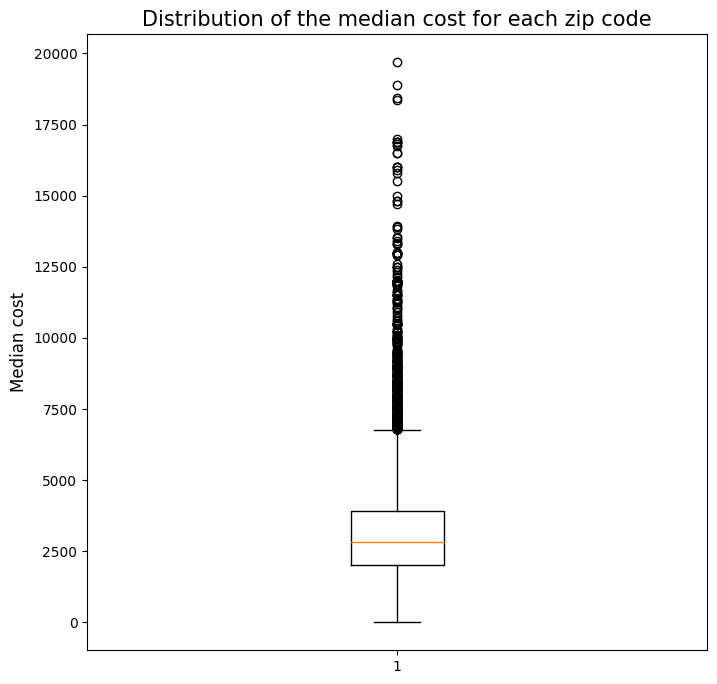

In [502]:
plt.rcParams["figure.figsize"] = (8,8) # Распределение медианной для каждого почтового индекса цены
plt.boxplot(data.groupby('postal_code')['price'].median())
plt.title('Distribution of the median cost for each zip code', fontsize=15)
plt.ylabel("Median cost", fontsize=12)
plt.show()

In [503]:
print(
      'Процент почтовых индексов со средней стоимостью выше средней:', 
      round(data.loc[data['price'] > 2500,'postal_code'].unique().shape[0]/data.shape[0]*100,2),'%'
     )



Процент почтовых индексов со средней стоимостью выше средней: 2.37 %


In [504]:
print('Коэффициент корреляции Пирсона для postal_code и price:', data['postal_code'].corr(data['price']))

Коэффициент корреляции Пирсона для postal_code и price: 0.07495302111886781


Средняя стоимость авто для разных почтовых индексов примерна одинакова, за исключением 2, 26%  почтовых индексов, которые имеют среднюю стоимость выше среднего. Эту фичу можно исключить при обучении модели.

In [505]:
data = data.drop(labels=['postal_code'], axis=1) 

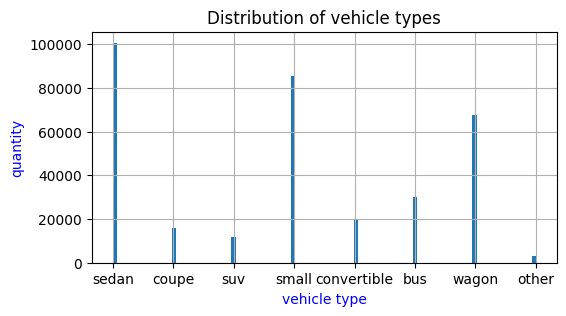

In [506]:
plt.figure(figsize=(6, 3))
data['vehicle_type'].hist(bins=100)
plt.title('Distribution of vehicle types')
plt.xlabel("vehicle type", color = 'blue')
plt.ylabel("quantity", color = 'blue')
plt.show()

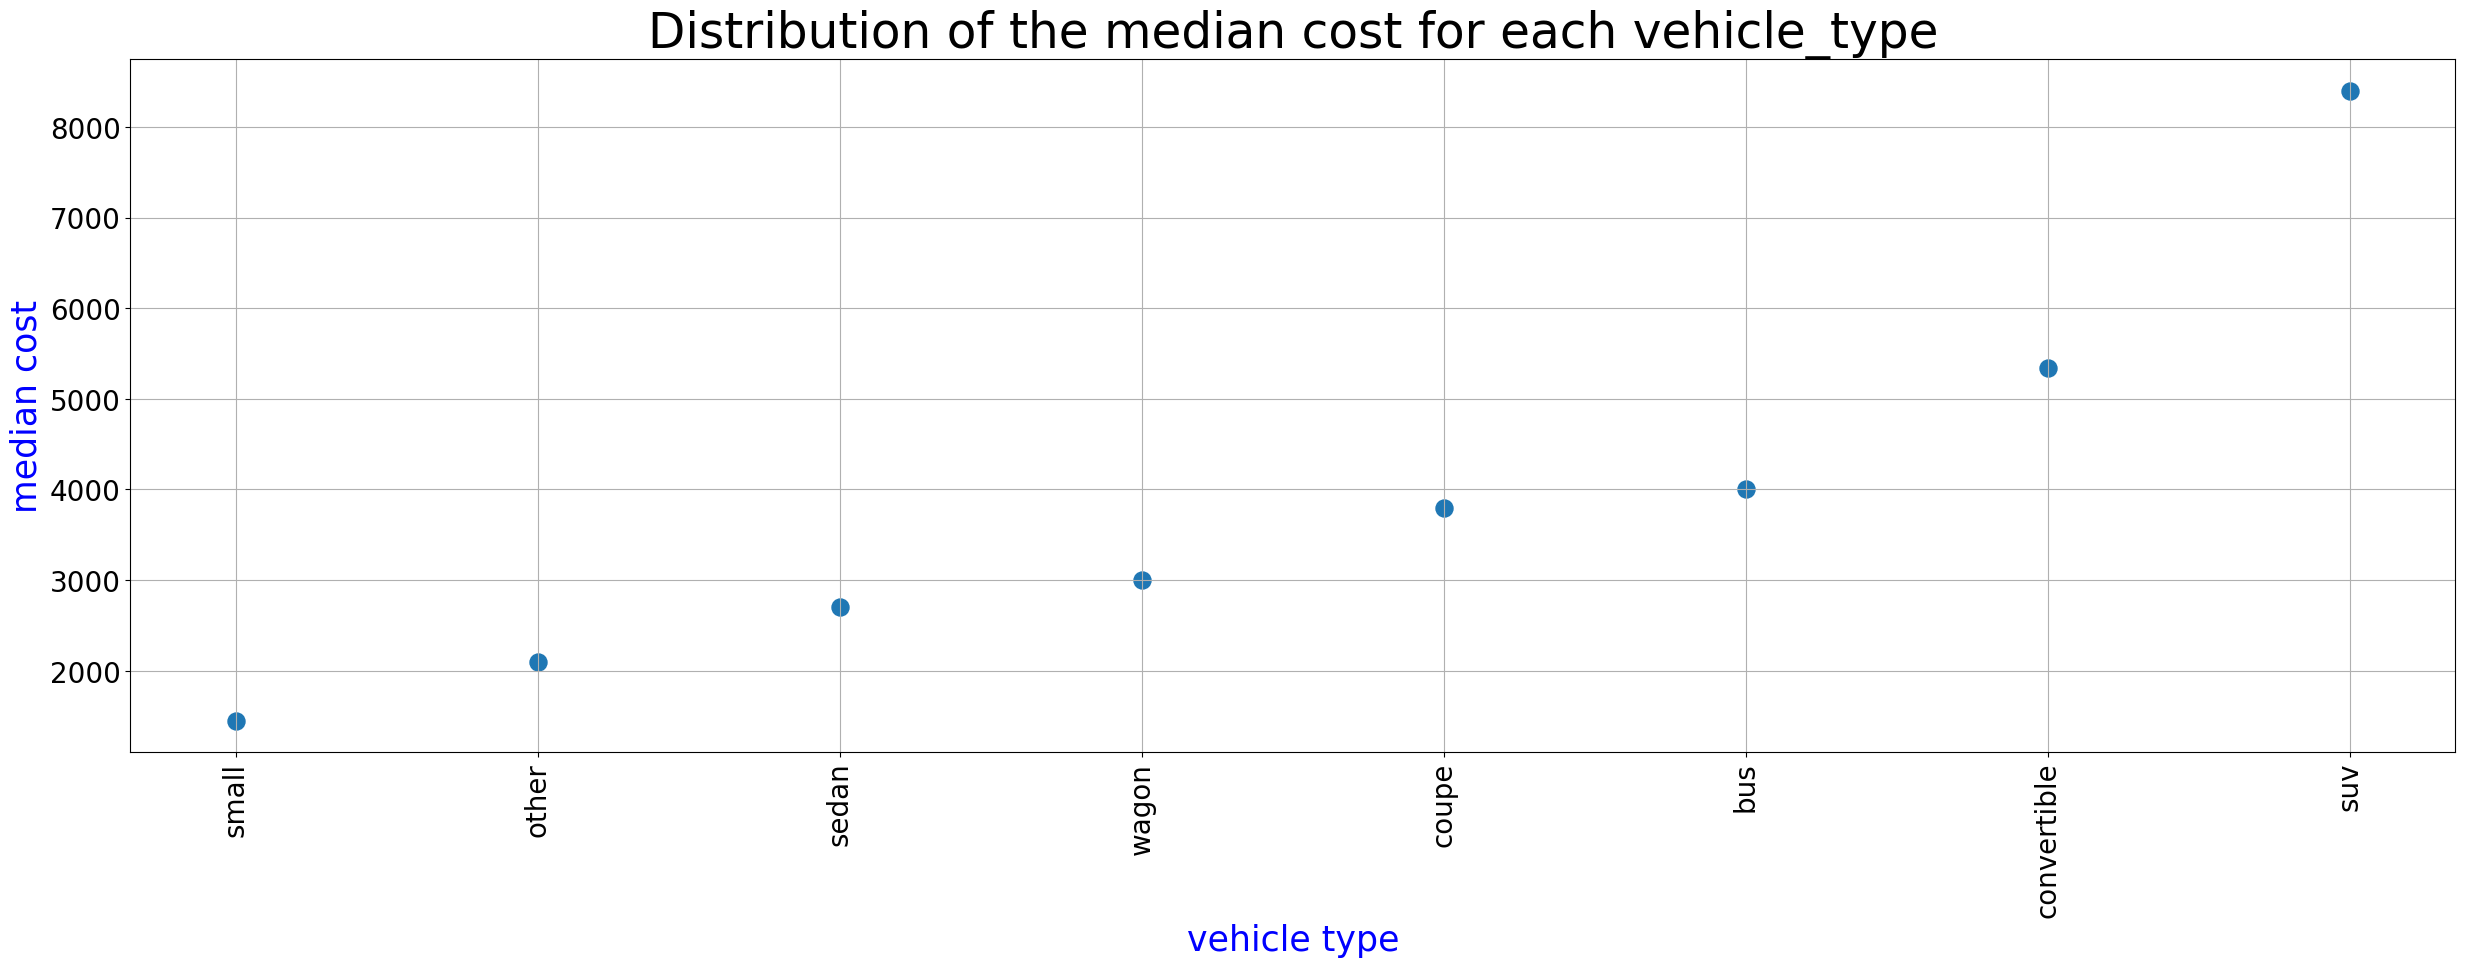

In [507]:
plt.figure(figsize=(30, 9))
plt.scatter(x=data.groupby('vehicle_type')['price'].median().sort_values().index, y=data.groupby('vehicle_type')['price'].median().sort_values(), s=150)      
plt.xlabel("vehicle type", fontsize=25, color = 'blue')
plt.ylabel("median cost", fontsize=25, color = 'blue')
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title('Distribution of the median cost for each vehicle_type', fontsize=35)
plt.xticks(data['vehicle_type'].unique(), rotation ='vertical')

plt.show()

Типы кузова coupe, suv можно добавить к категории other.

In [508]:
for vehicle in data['vehicle_type'].unique():
    if (vehicle != 'sedan') and (vehicle != 'small') and (vehicle != 'wagon') and (vehicle != 'bus') and (vehicle != 'other'):
        data.loc[data['vehicle_type'] == vehicle, 'vehicle_type'] = 'other'

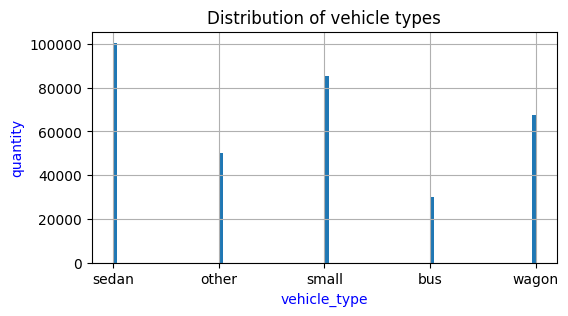

In [509]:
plt.figure(figsize=(6, 3))
plt.hist(data['vehicle_type'], bins=100)
plt.title('Distribution of vehicle types')
plt.xlabel("vehicle_type", color = 'blue')
plt.ylabel("quantity", color = 'blue')
plt.grid()
plt.show()

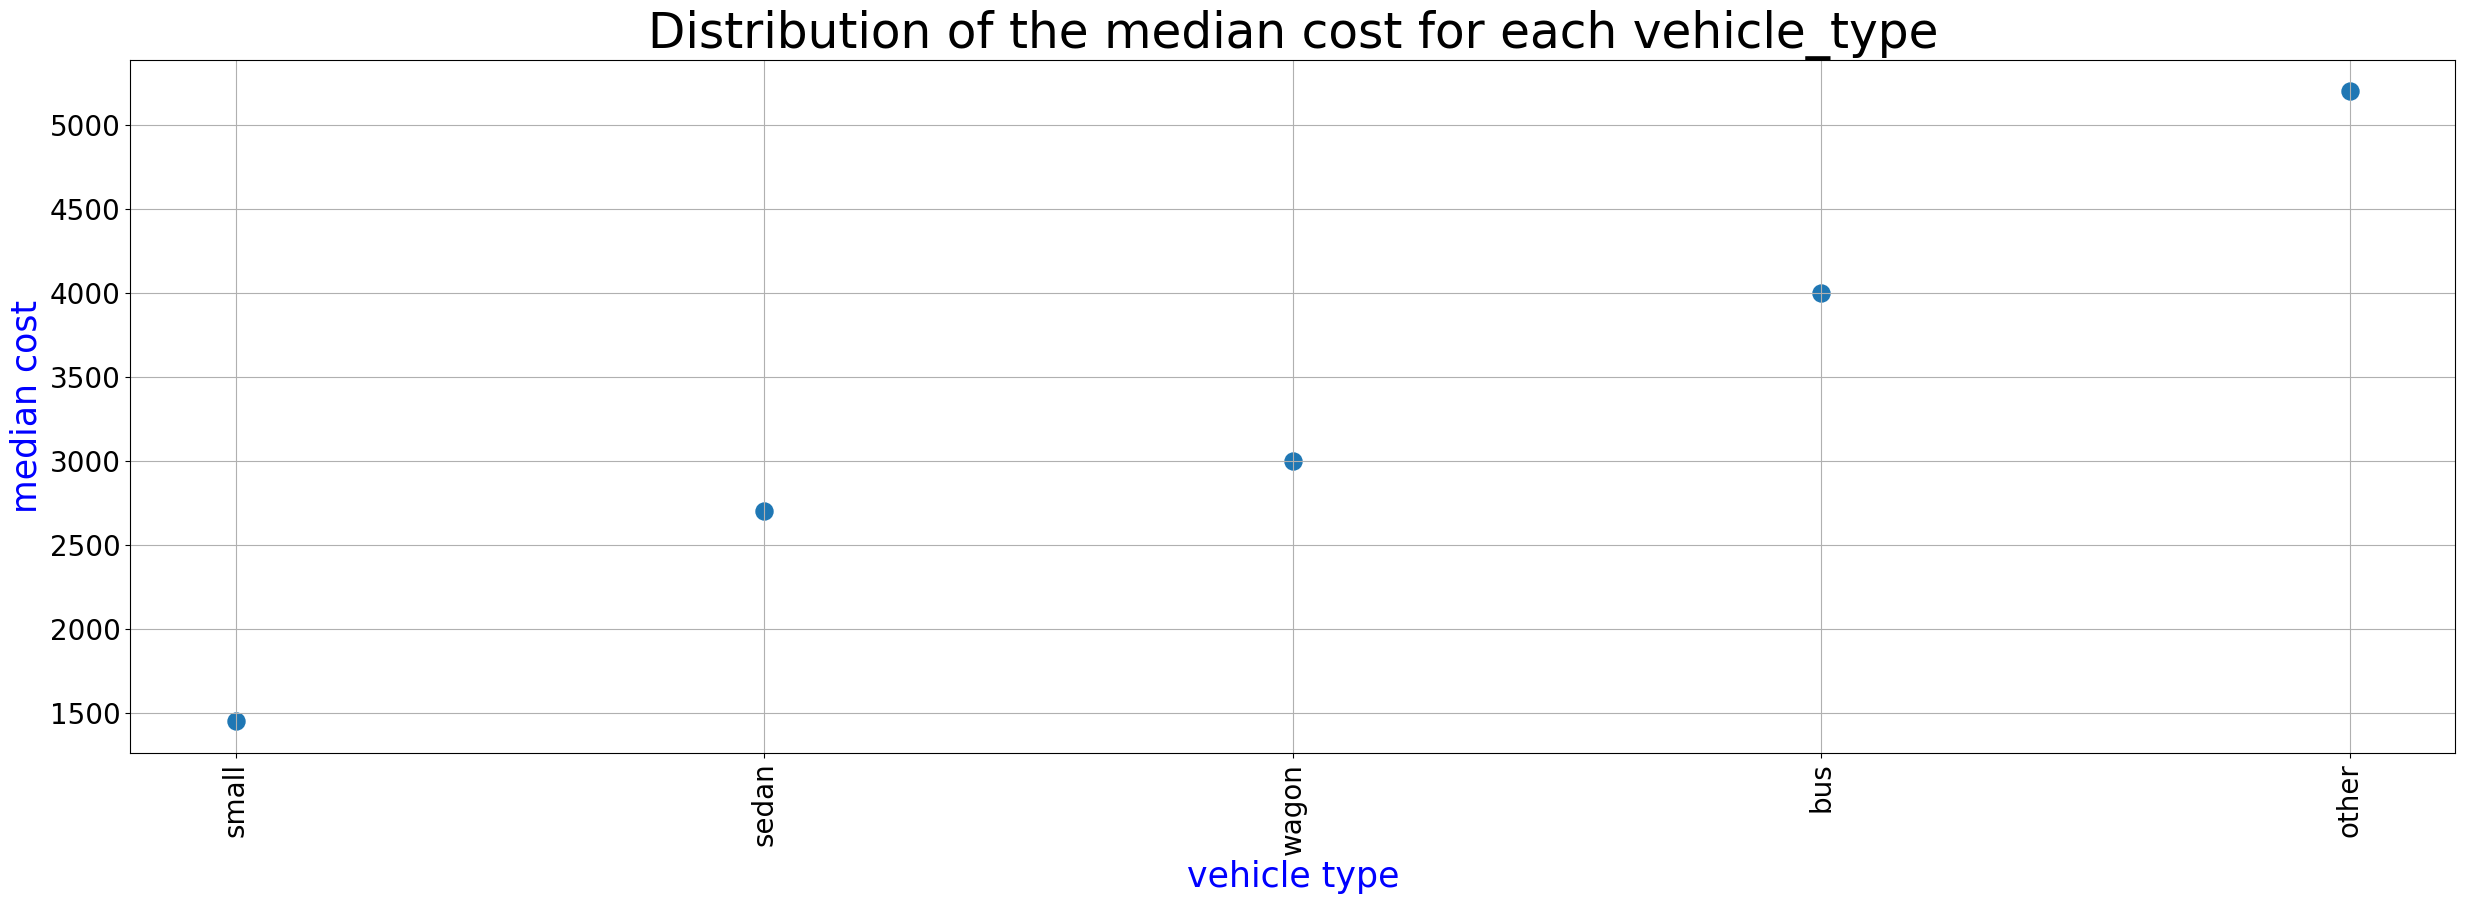

In [510]:
plt.figure(figsize=(30, 9))
plt.scatter(x=data.groupby('vehicle_type')['price'].median().sort_values().index, y=data.groupby('vehicle_type')['price'].median().sort_values(), s=150)      
plt.xlabel("vehicle type", fontsize=25, color = 'blue')
plt.ylabel("median cost", fontsize=25, color = 'blue')
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title('Distribution of the median cost for each vehicle_type', fontsize=35)
plt.xticks(data['vehicle_type'].unique(), rotation ='vertical')

plt.show()

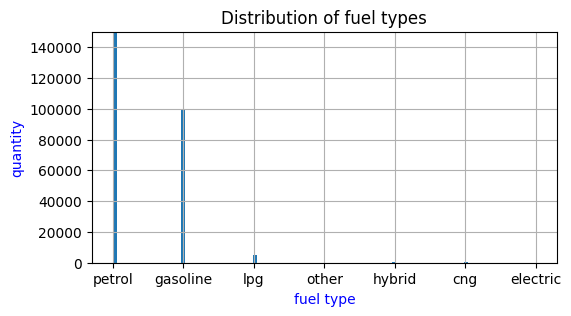

In [511]:
plt.figure(figsize=(6, 3))
data['fuel_type'].hist(bins=100)
plt.title('Distribution of fuel types')
plt.xlabel("fuel type", color = 'blue')
plt.ylabel("quantity", color = 'blue')
plt.ylim(0,150000)
plt.show()

Самые популярные типы топлива это petrol и gasoline. Остальные можно добавить к категории other.

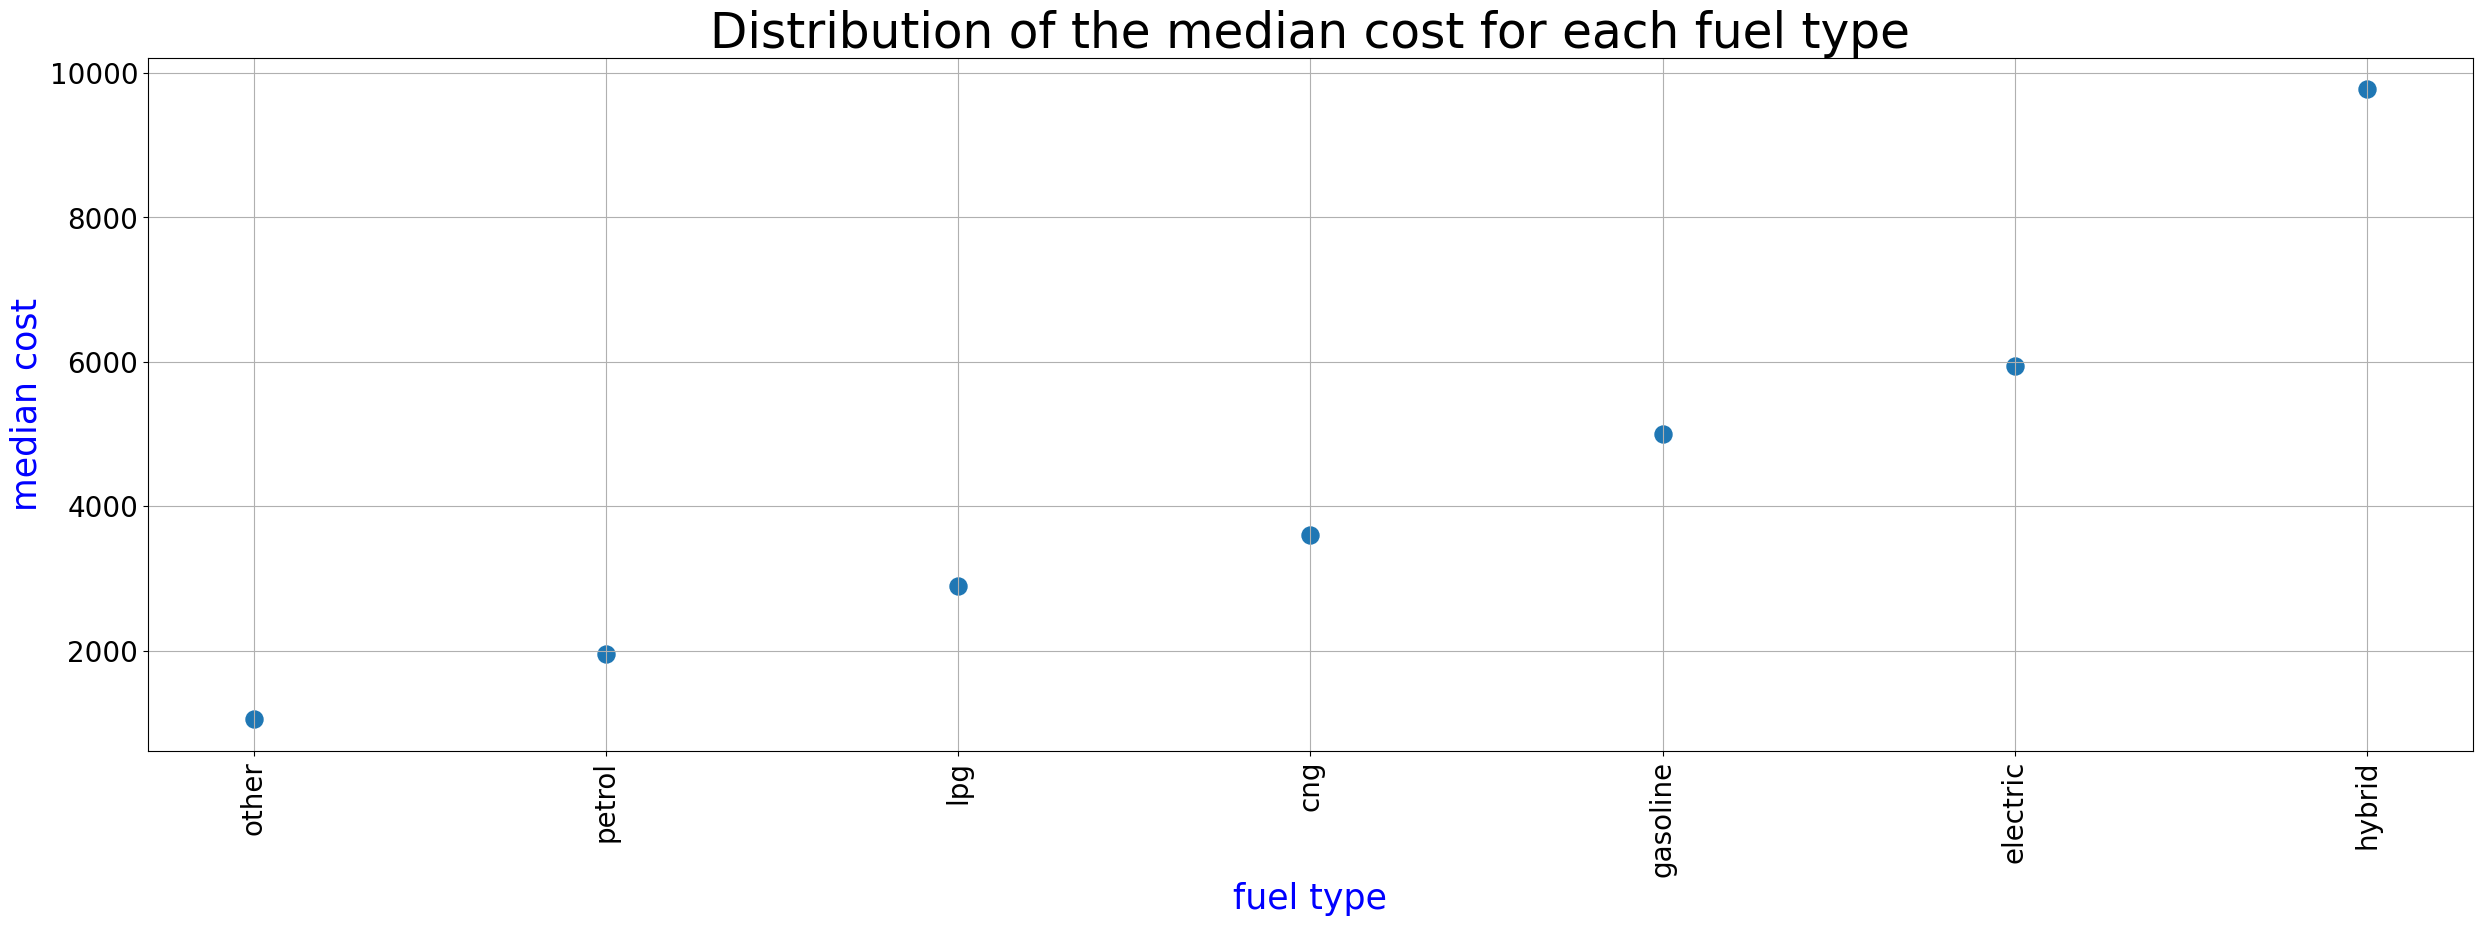

In [512]:

plt.figure(figsize=(30, 9))
plt.scatter(x=data.groupby('fuel_type')['price'].median().sort_values().index, y=data.groupby('fuel_type')['price'].median().sort_values(), s=150)      
plt.xlabel("fuel type", fontsize=25, color = 'blue')
plt.ylabel("median cost", fontsize=25, color = 'blue')
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title('Distribution of the median cost for each fuel type', fontsize=35)
plt.xticks(data['fuel_type'].unique(), rotation ='vertical')

plt.show()


In [513]:
for fuel in data['fuel_type'].unique():
    if (fuel != 'petrol') and (fuel != 'gasoline') and (fuel != 'other'):
        data.loc[data['fuel_type'] == fuel, 'fuel_type'] = 'other'

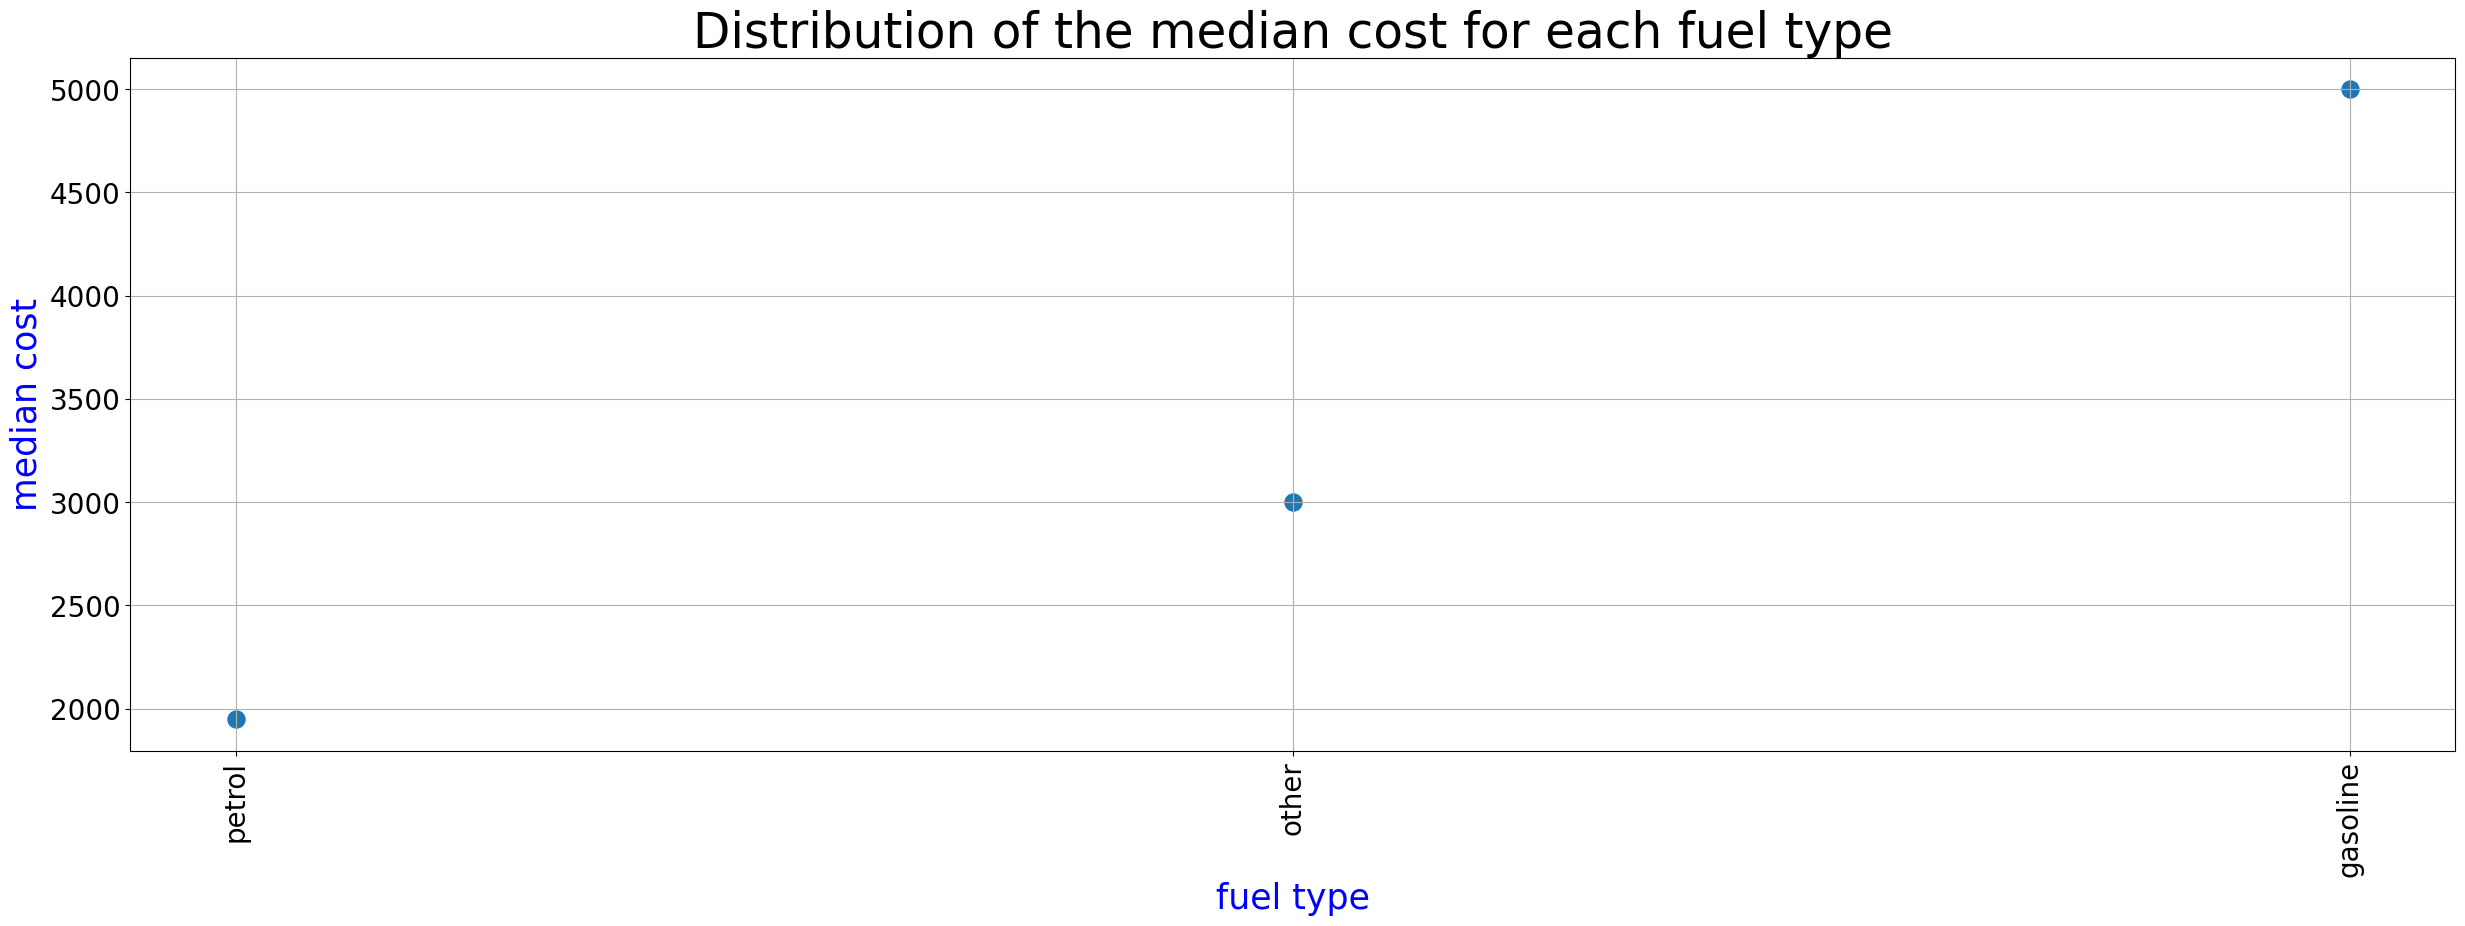

In [514]:

plt.figure(figsize=(30, 9))
plt.scatter(x=data.groupby('fuel_type')['price'].median().sort_values().index, y=data.groupby('fuel_type')['price'].median().sort_values(), s=150)      
plt.xlabel("fuel type", fontsize=25, color = 'blue')
plt.ylabel("median cost", fontsize=25, color = 'blue')
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title('Distribution of the median cost for each fuel type', fontsize=35)
plt.xticks(data['fuel_type'].unique(), rotation ='vertical')

plt.show()

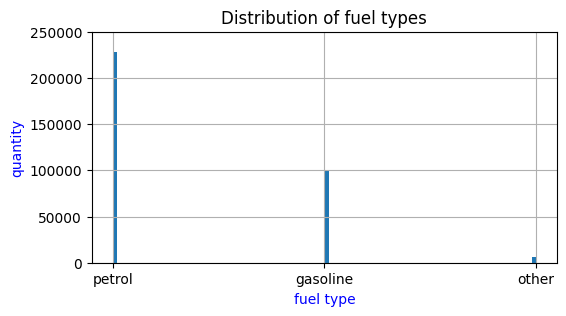

In [515]:
plt.figure(figsize=(6, 3))
data['fuel_type'].hist(bins=100)
plt.title('Distribution of fuel types')
plt.xlabel("fuel type", color = 'blue')
plt.ylabel("quantity", color = 'blue')
plt.ylim(0,250000)
plt.show()

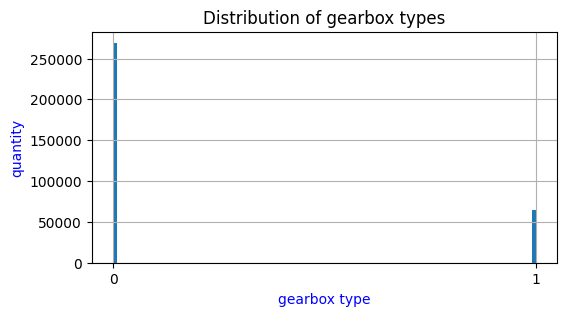

In [516]:
plt.figure(figsize=(6, 3))
data['gearbox'].hist(bins=100)
plt.title('Distribution of gearbox types')
plt.xlabel("gearbox type", color = 'blue')
plt.ylabel("quantity", color = 'blue')
plt.xticks(list(range(0,2,1)))

plt.show()

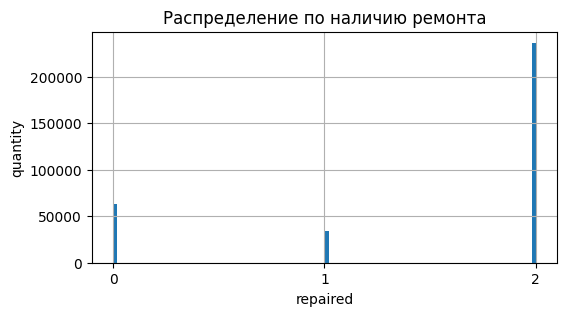

In [517]:
plt.figure(figsize=(6, 3))
data['repaired'].hist(bins=100)
plt.title('Распределение по наличию ремонта')
plt.xlabel("repaired")
plt.ylabel("quantity")
plt.xticks(list(range(0,3,1)))
plt.show()


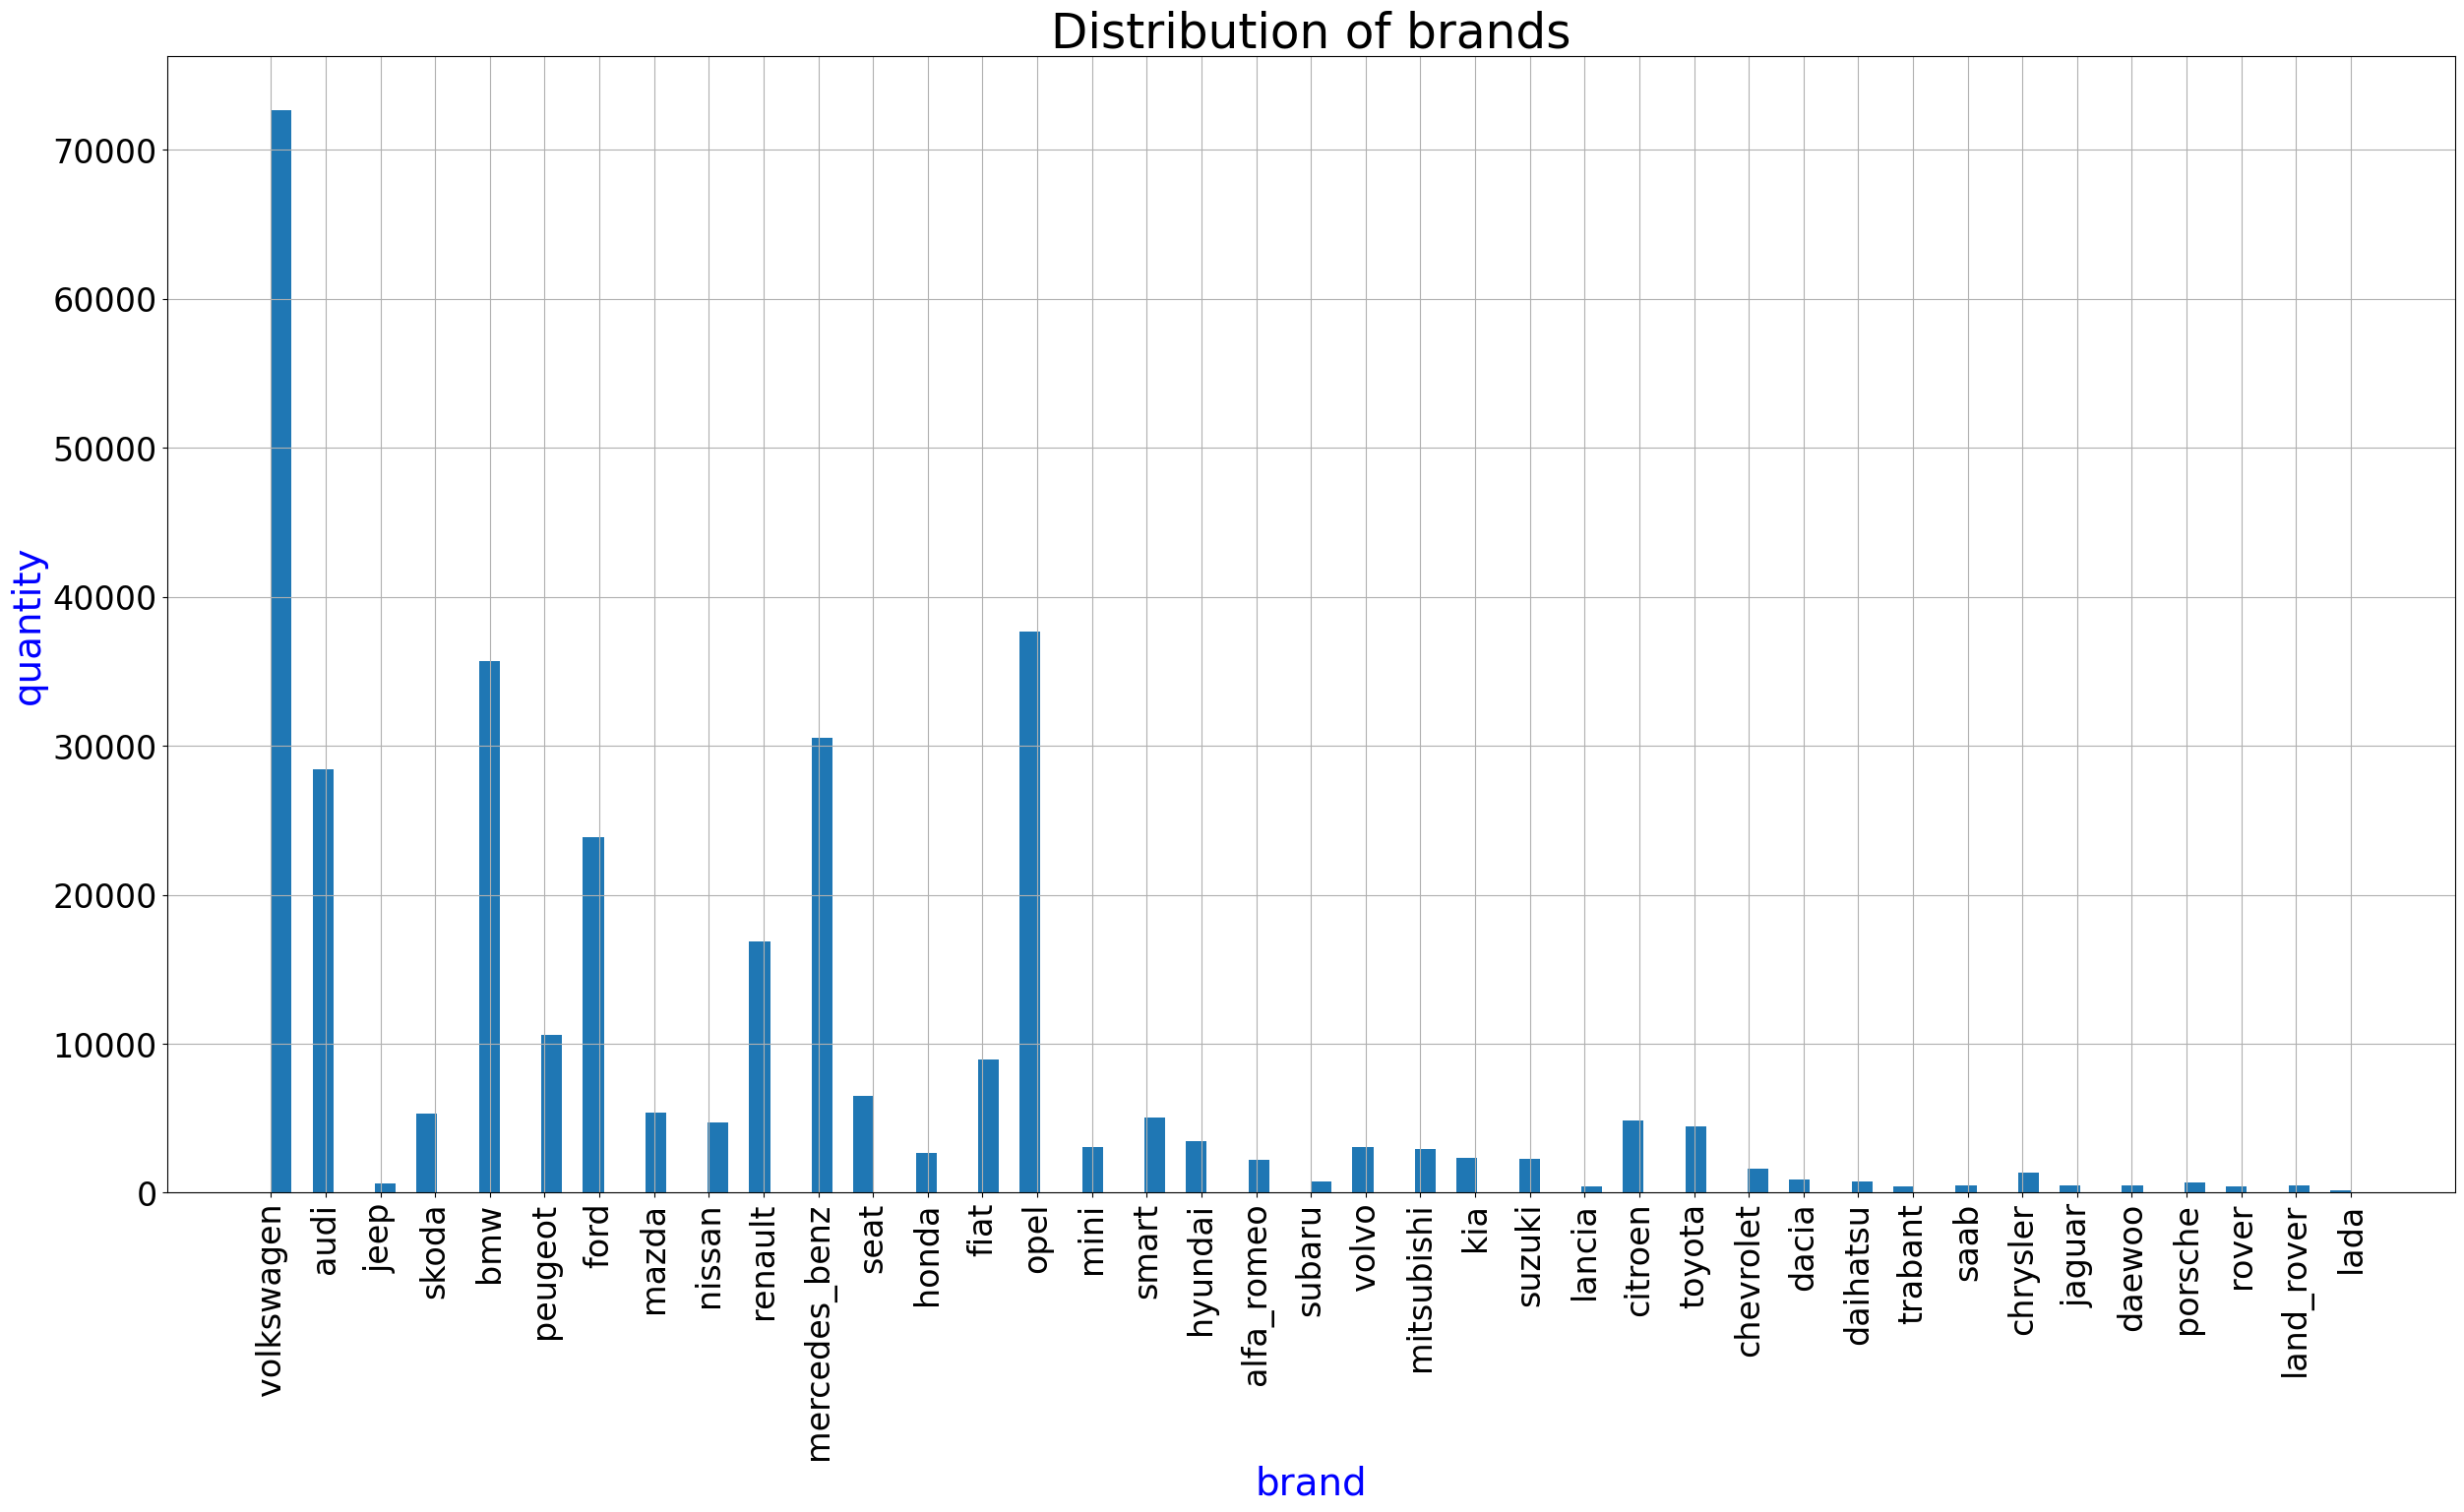

In [518]:
plt.figure(figsize=(30, 15))
data['brand'].hist(bins=100)
plt.title('Distribution of brands', fontsize=35)
plt.xlabel("brand", fontsize=28,  color = 'blue')
plt.ylabel("quantity", fontsize=28,  color = 'blue')
plt.tick_params(axis='both', which='major', labelsize=24) # Размер шрифта значений по осям
plt.xticks(data['brand'].unique(), rotation ='vertical')
plt.show()

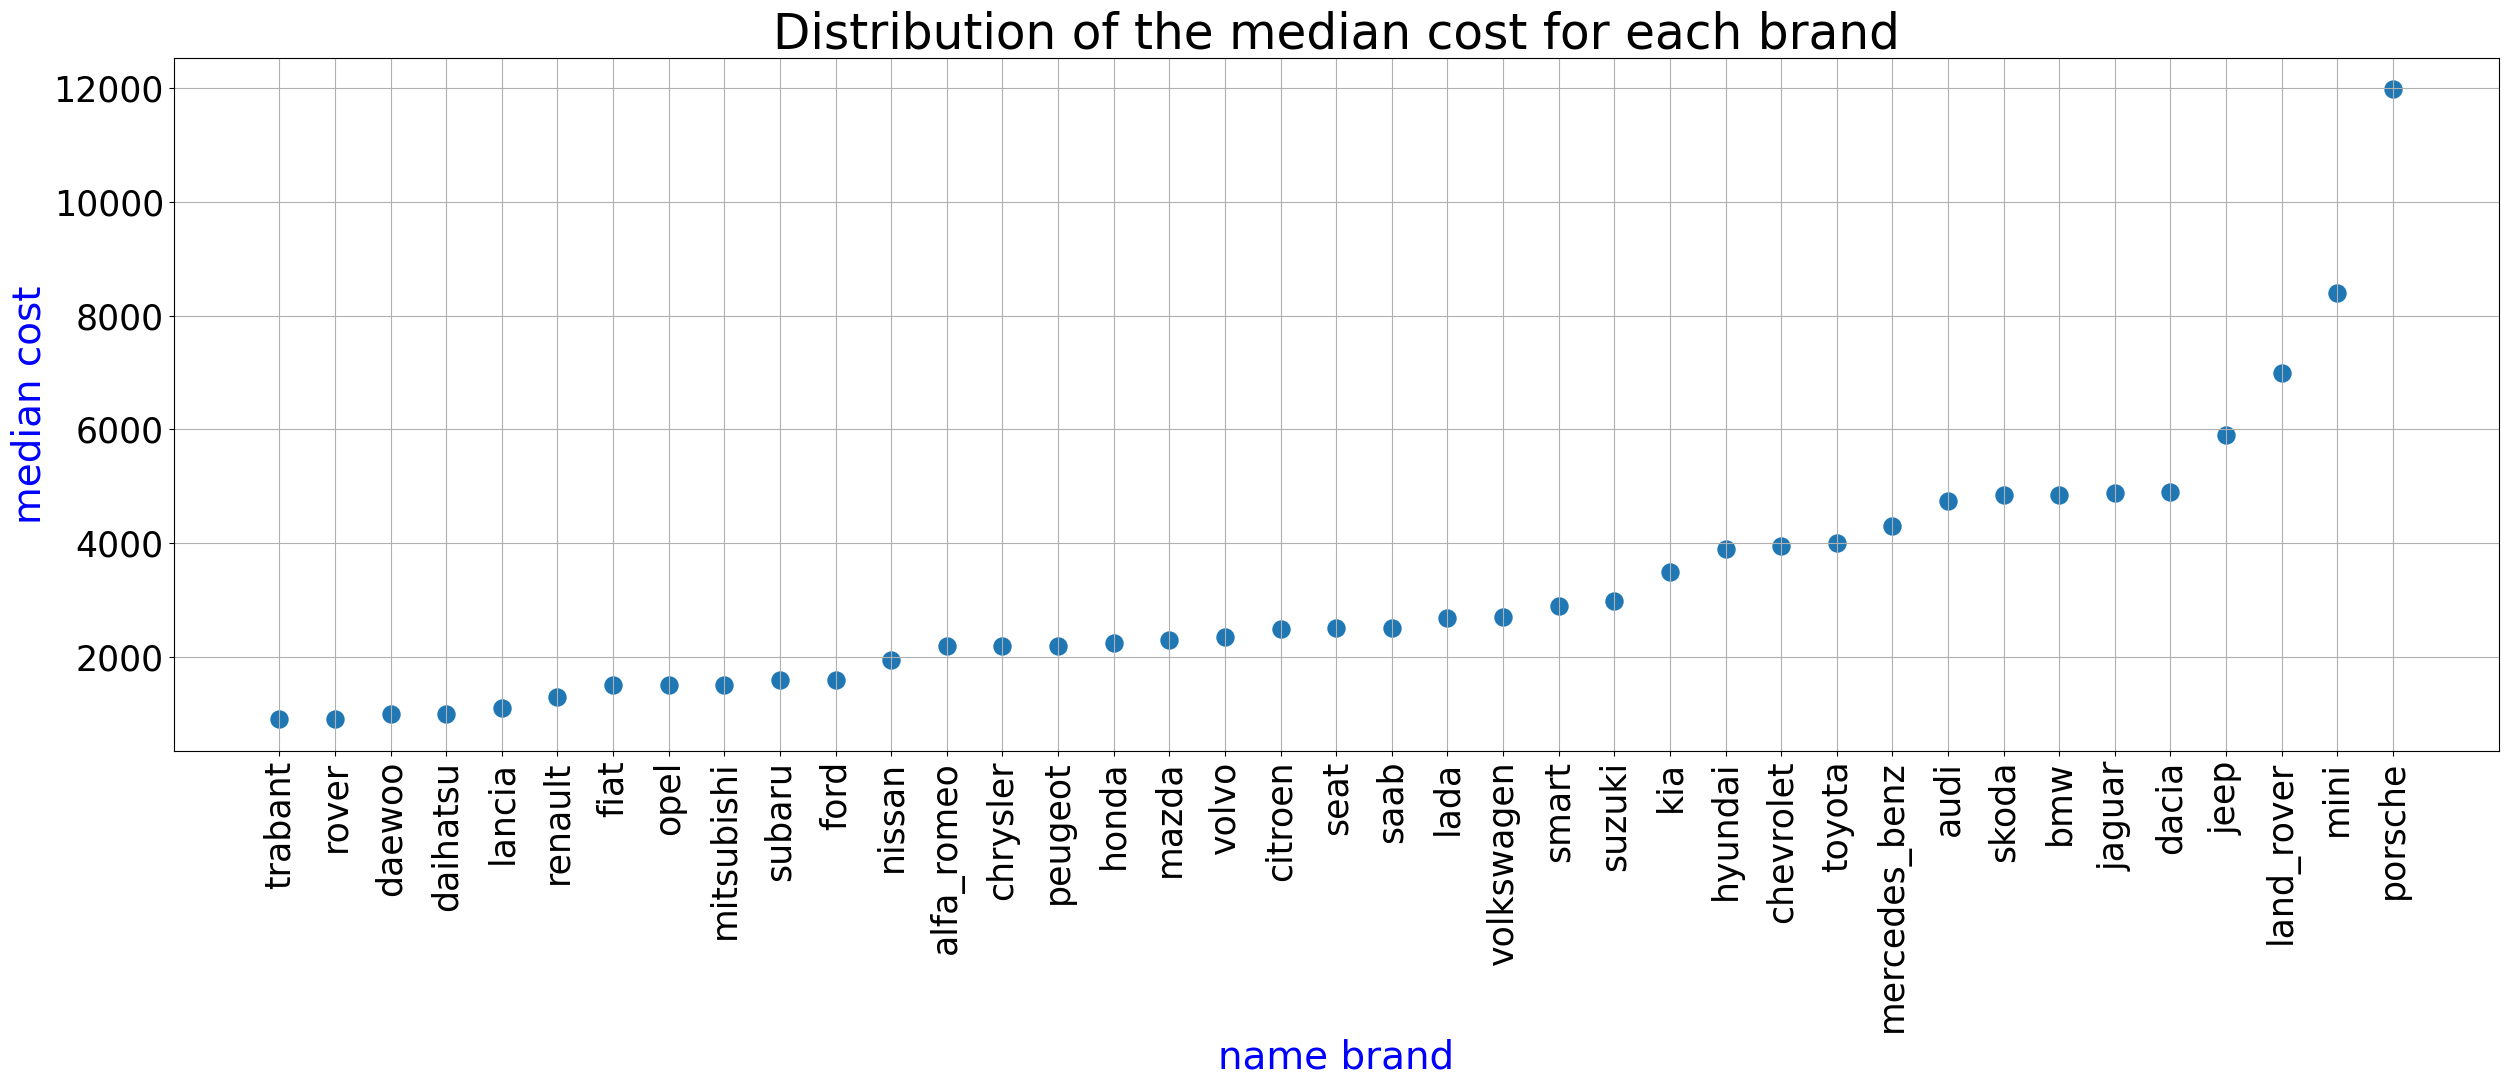

In [519]:
plt.figure(figsize=(30, 9))
plt.scatter(x=data.groupby('brand')['price'].median().sort_values().index, y=data.groupby('brand')['price'].median().sort_values(), s = 150)      
plt.xlabel("name brand", fontsize=28, color = 'blue')
plt.ylabel("median cost", fontsize=28, color = 'blue')
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=25)
plt.title('Distribution of the median cost for each brand', fontsize=35)
plt.xticks(data['brand'].unique(), rotation ='vertical')

plt.show()

Для каждого бренда медианная цена авто разная

In [520]:
data['model'].unique().shape

(249,)

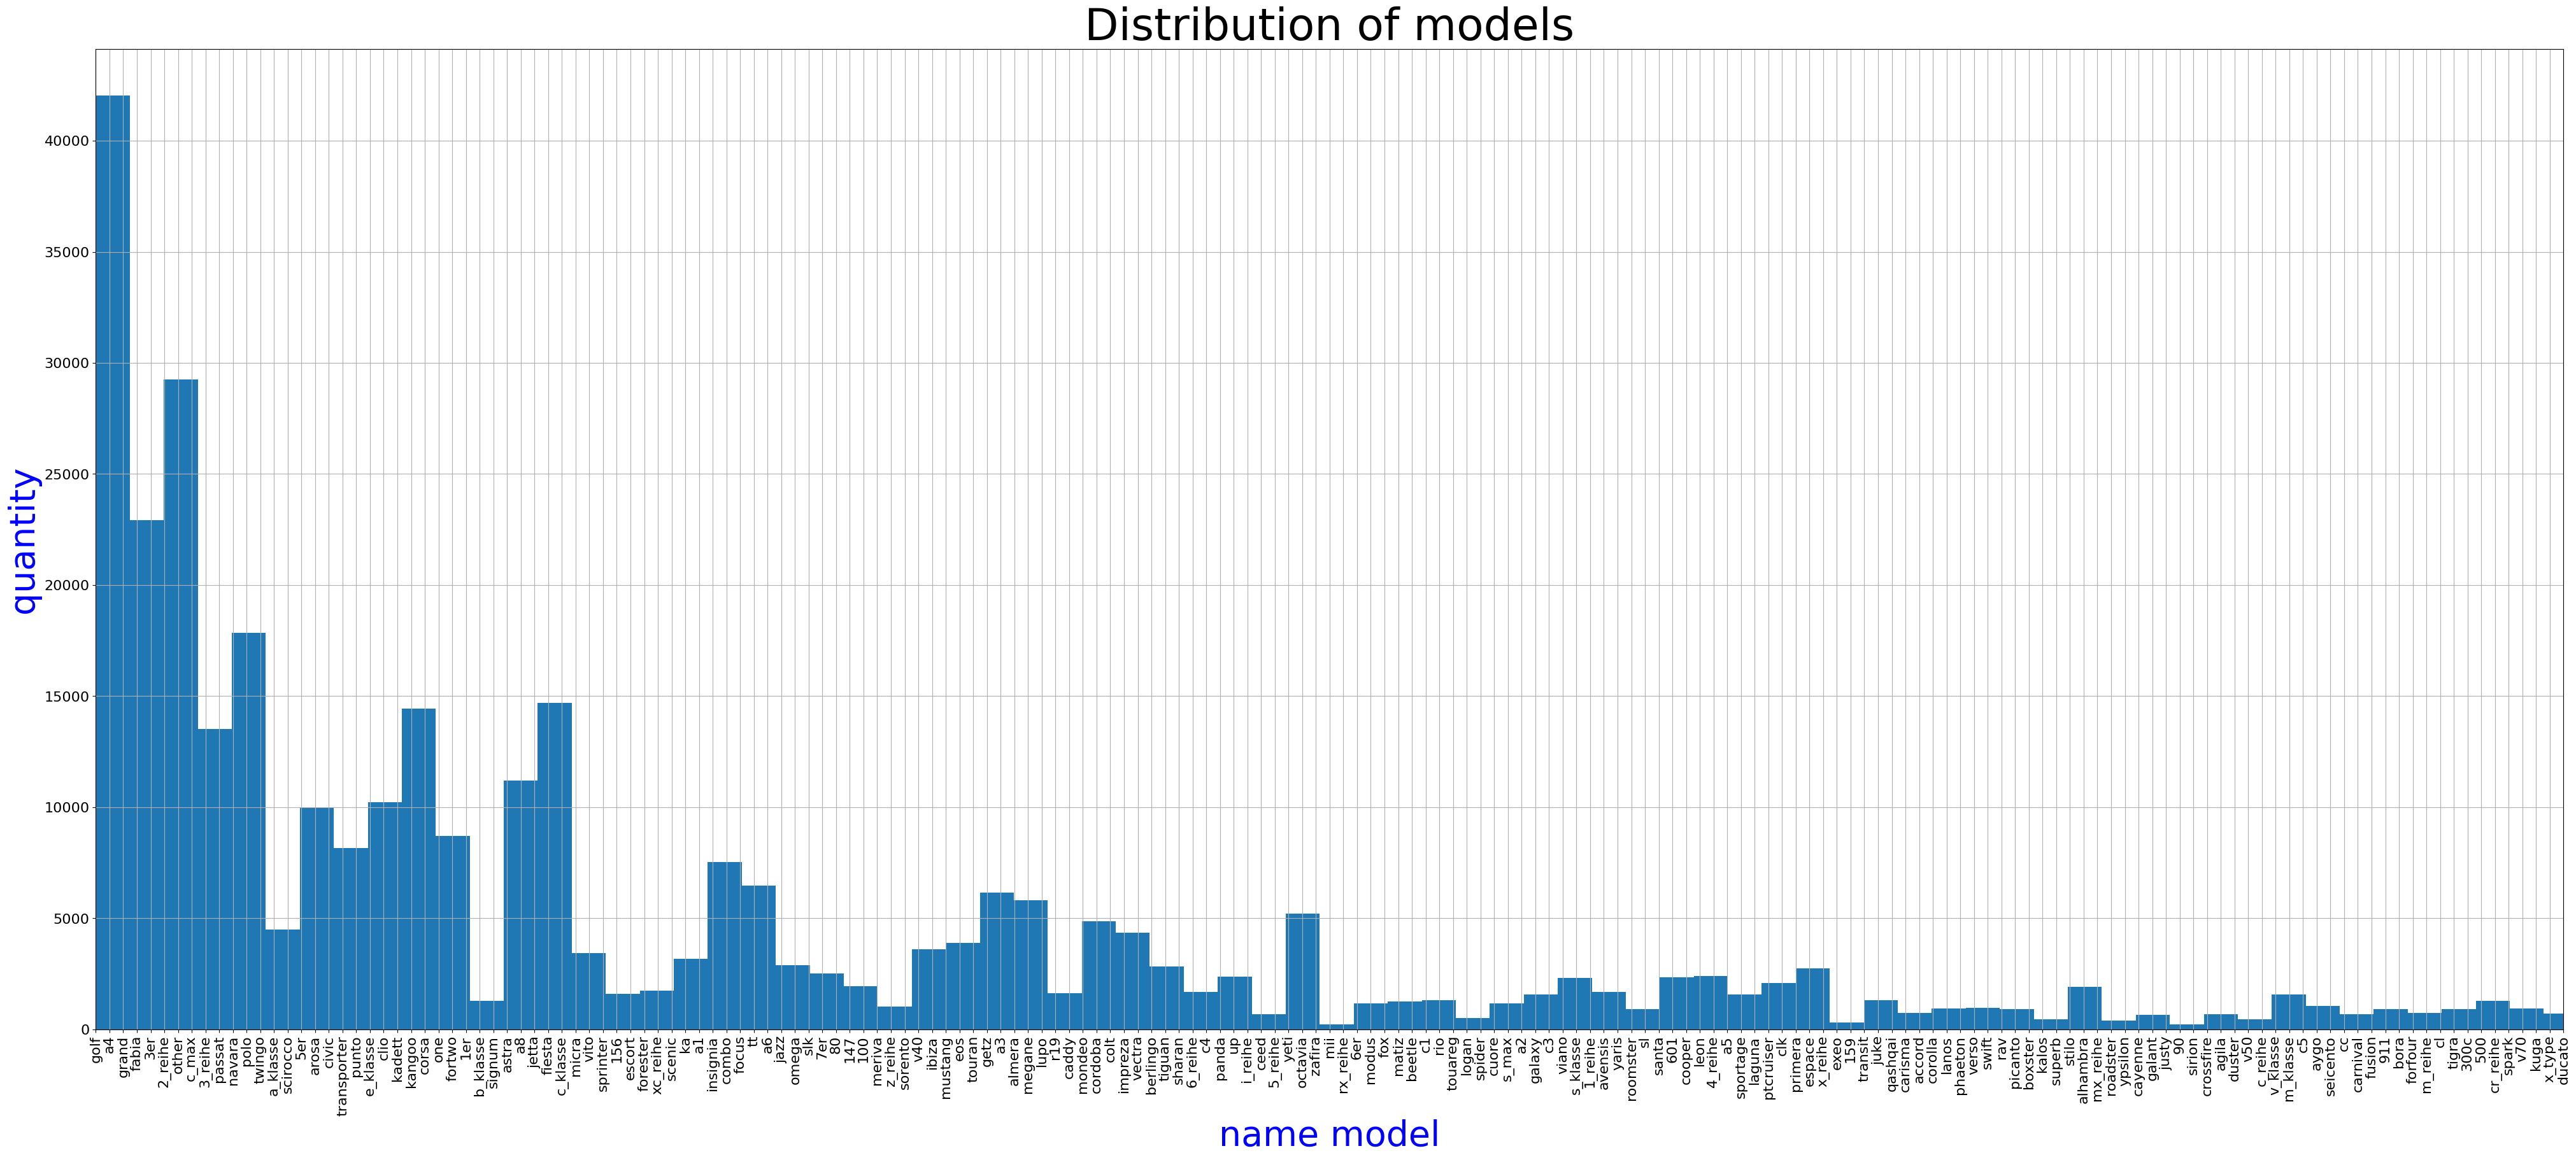

In [521]:
plt.figure(figsize=(50, 20))
data['model'].hist(bins=100)
plt.title('Distribution of models', fontsize=50)
plt.xlabel("name model", fontsize=40, color = 'blue')
plt.ylabel("quantity", fontsize=40, color = 'blue')
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xticks(data['model'].unique(), rotation ='vertical')
plt.xlim(0,180)
plt.show()

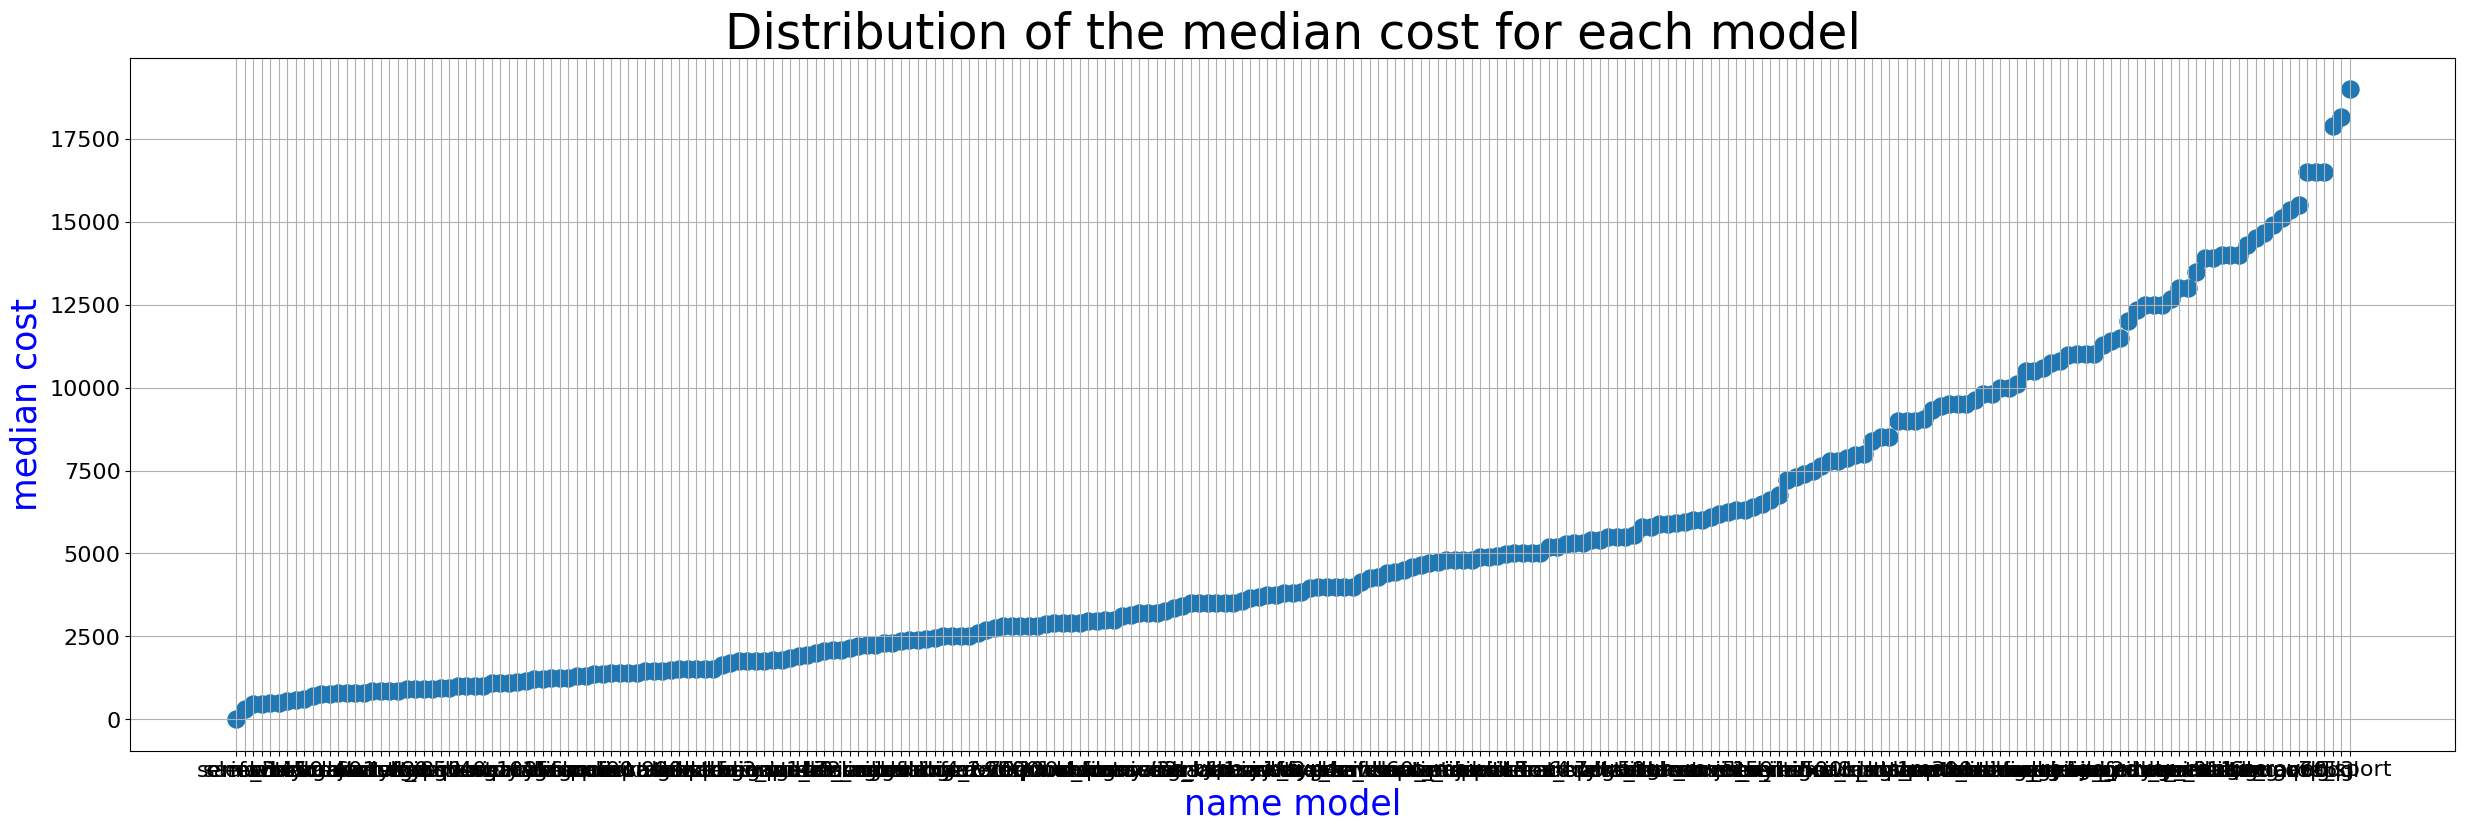

In [522]:
plt.figure(figsize=(30, 9))
plt.scatter(x=data.groupby('model')['price'].median().sort_values().index, y=data.groupby('model')['price'].median().sort_values(), s=150)      
plt.xlabel("name model", fontsize=25, color = 'blue')
plt.ylabel("median cost", fontsize=25, color = 'blue')
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=16)
plt.title('Distribution of the median cost for each model', fontsize=35)
#plt.xticks(data['model'].unique(), rotation ='vertical')

plt.show()

Для каждой модели медианная цена авто разная

In [523]:
ord_enc = OrdinalEncoder() # Кодирование категориальных признаков
data["model"] = ord_enc.fit_transform(data[["model"]])
data["brand"] = ord_enc.fit_transform(data[["brand"]])
data["fuel_type"] = ord_enc.fit_transform(data[["fuel_type"]])
data["vehicle_type"] = ord_enc.fit_transform(data[["vehicle_type"]])
data.shape

(333832, 10)

In [524]:
data.reset_index(drop=True)

price  vehicle_type  registration_year  gearbox  power  model  \
0         480           2.0               1993        0   90.0  116.0   
1       18300           1.0               2011        0  190.0   29.0   
2        9800           1.0               2004        1  163.0  117.0   
3        1500           3.0               2001        0   75.0  116.0   
4        3600           3.0               2008        0   69.0  101.0   
...       ...           ...                ...      ...    ...    ...   
333827   1150           0.0               2000        0  120.0  248.0   
333828      0           2.0               2005        0   75.0   78.0   
333829   1199           1.0               2000        1  101.0  106.0   
333830   9200           0.0               1996        0  102.0  223.0   
333831   3400           4.0               2002        0  100.0  116.0   

        kilometer  fuel_type  brand  repaired  
0          150000        2.0   37.0         0  
1          125000        0.0    1.0         1  
2          125000        0.0   14.0         0  
3          150000        2.0   37.0         2  
4           90000        0.0   31.0         2  
...           ...        ...    ...       ...  
333827     150000        2.0   24.0         2  
333828     150000        2.0   22.0         1  
333829     125000        2.0   32.0         2  
333830     150000        0.0   37.0         2  
333831     150000        0.0   37.0         0  

[333832 rows x 10 columns]

In [525]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 333832 entries, 0 to 354364
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              333832 non-null  int64  
 1   vehicle_type       333832 non-null  float64
 2   registration_year  333832 non-null  int64  
 3   gearbox            333832 non-null  int32  
 4   power              333832 non-null  float64
 5   model              333832 non-null  float64
 6   kilometer          333832 non-null  int64  
 7   fuel_type          333832 non-null  float64
 8   brand              333832 non-null  float64
 9   repaired           333832 non-null  int32  
dtypes: float64(5), int32(2), int64(3)
memory usage: 25.5 MB


In [526]:
data['power'] = np.int64(data['power']) # Изменение типов данных
data['brand'] = np.int64(data['brand'])
data['model'] = np.int64(data['model'])
data['fuel_type'] = np.int64(data['fuel_type'])
data['vehicle_type'] = np.int64(data['vehicle_type'])

Аномальные значения мощности заменены медианными для каждой модели значениями. Большая часть автомобилей имеют большой пробег, более 140000км. Изучены данные столбцов registration_year и registration_month. Большая часть данных соотвествует периоду с 1980 по 2018 годы. Аномальное значение месяца регистрации 0, медианная цена для этого месяца значительно ниже, чем для остальных. Причем для всех месяцев (кроме нулевого) медианная цена примерно одинаковая. Удалены столбцы с данными о месяцах регистрации автомобиля и почтовых индексах. Медианная цена для каждого бренда и модели разная, увеличивается монотонно от модели к модели (от бренда к бренду). Низкочастотные значения в столбцах fuel_type, vehicle_type отнесены к категории Other. Категориальные признаки закодированы с помощью OrdinalEncoder. 

## Анализ моделей

### Обучение и подбор гиперпараметров

In [527]:
# Разделение данных на выборки
data_train, data_valid_test = train_test_split(data, test_size=0.4, random_state=12345)
data_valid, data_test = train_test_split(data_valid_test, test_size=0.5, random_state=12345)

features_train = data_train.drop(['price'], axis=1)
target_train = data_train['price']
features_valid = data_valid.drop(['price'], axis=1)
target_valid = data_valid['price']
features_test = data_test.drop(['price'], axis=1)
target_test = data_test['price']

features = pd.concat([features_train, features_valid])
target = pd.concat([target_train, target_valid])

In [528]:
# Масштабирование численных признаков
cat_features = ['brand', 'model', 'gearbox','repaired', 'vehicle_type', 'fuel_type']

scaler = StandardScaler()

features_train_scaled = features_train.loc[:, ['registration_year', 'power', 'kilometer']]
features_valid_scaled = features_valid.loc[:, ['registration_year', 'power', 'kilometer']]
features_test_scaled = features_test.loc[:, ['registration_year', 'power', 'kilometer']]

scaler.fit(features_train_scaled)

features_train_scaled = scaler.transform(features_train_scaled)
features_valid_scaled = scaler.transform(features_valid_scaled)
features_test_scaled = scaler.transform(features_test_scaled)

In [529]:
features_train_scaled = pd.DataFrame(features_train_scaled, columns=['registration_year', 'power', 'kilometer'])
features_valid_scaled = pd.DataFrame(features_valid_scaled, columns=['registration_year', 'power', 'kilometer'])
features_test_scaled = pd.DataFrame(features_test_scaled, columns=['registration_year', 'power', 'kilometer'])

for cat in cat_features:
    features_train_scaled[cat] = np.int64(features_train[cat])
    features_valid_scaled[cat] = np.int64(features_valid[cat])
    features_test_scaled[cat] = np.int64(features_test[cat])

In [530]:
%%time
dummy_regr = DummyRegressor(strategy="median") # Константная модель
score = cross_val_score(dummy_regr, features, target, scoring='neg_mean_squared_error', cv=4).mean()
print("RMSE константной модели:", abs(score)**0.5)

RMSE константной модели: 4827.715853867991
CPU times: user 36.1 ms, sys: 8.47 ms, total: 44.5 ms
Wall time: 43.5 ms


In [531]:
%%time
model_linear_regression = LinearRegression() # Модель линейной регресии
model_linear_regression.fit(features_train_scaled, target_train)
predictions = model_linear_regression.predict(features_valid_scaled)
score = mean_squared_error(target_valid, predictions)
print("RMSE =", abs(score)**0.5)


RMSE = 3259.836980780221
CPU times: user 317 ms, sys: 31.7 ms, total: 349 ms
Wall time: 192 ms


In [532]:
%%time
best_est = 0 # Подбор гиперпараметров для  Модели случайного леса
best_depth = 0
min_score = 3500**2
best_model_forest_regressor = None
for est in range(10, 49, 4):
    for depth in range (3, 22,2):
        model_forest_regressor = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth)
        model_forest_regressor.fit(features_train, target_train)
        predictions = model_forest_regressor.predict(features_valid)
        score = mean_squared_error(target_valid, predictions)
        if abs(score) < abs(min_score):
            min_score = score
            best_depth = depth
            best_est = est
            best_model_forest_regressor = model_forest_regressor
print("RMSE наилучшей модели RandomForestRegressor:", (abs(min_score))**0.5, "Количество деревьев:", best_est, "Глубина дерева:", best_depth)


RMSE наилучшей модели RandomForestRegressor: 1719.953343140393 Количество деревьев: 46 Глубина дерева: 17
CPU times: user 8min 48s, sys: 2.48 s, total: 8min 50s
Wall time: 8min 50s


In [533]:
cat_features = ['brand', 'model', 'gearbox','repaired', 'vehicle_type', 'fuel_type']
for c in cat_features:
    features_train[c] = features_train[c].astype('category')
    features_valid[c] = features_valid[c].astype('category')
    features_test[c] = features_test[c].astype('category')

In [534]:
%%time
# Модель LGBMRegressor
cat_features = ['brand', 'model', 'gearbox','repaired', 'vehicle_type', 'fuel_type']
for c in cat_features:
    features_train[c] = features_train[c].astype('category')
    features_valid[c] = features_valid[c].astype('category')
    
best_est = 0 # Подбор гиперпараметров 
best_depth = 0
min_score = 2500**2
best_rate = 0
best_model_lgbm_regressor = None
for rate in [0.1, 0.3, 0.5]:
    for est in range(12, 56, 8):
        for depth in range(17,23,1):

            model_lgbm_regressor = lgb.LGBMRegressor(learning_rate=rate, max_depth=depth, n_estimators=est, random_state=42)
            model_lgbm_regressor.fit(features_train, target_train, categorical_feature = cat_features)

            predictions = model_lgbm_regressor.predict(features_valid)
            score = mean_squared_error(target_valid, predictions)

            if abs(score) < abs(min_score):
                min_score = score
                best_depth = depth
                best_est = est
                best_rate = rate
                best_model_lgbm_regressor = model_lgbm_regressor
                
print("RMSE =", abs(min_score)**0.5)
print("Количество деревьев:", best_est, "Глубина дерева:", best_depth,'Скорость:', best_rate)

/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in D

/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in D

/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in D

RMSE = 1715.4524059947878
Количество деревьев: 52 Глубина дерева: 17 Скорость: 0.3
CPU times: user 4min 2s, sys: 49.6 s, total: 4min 51s
Wall time: 1min 2s


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

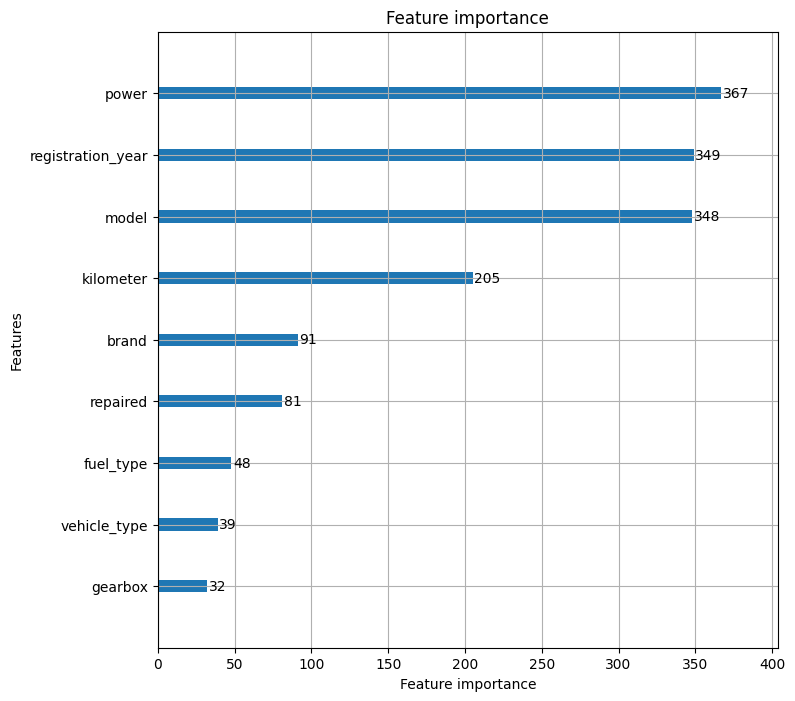

In [535]:
lgb.plot_importance(model_lgbm_regressor)    

In [536]:
%%time
# Модель CatBoostRegressor
best_est = 0 # Подбор гиперпараметров 
best_depth = 0
min_score = 2500**2
best_rate = 0
best_model_cat_boost_regressor = None
for rate in [0.3, 0.5, 0.6]:
    for est in range(14, 70, 8):
        for depth in range(2,17,2):
            model_cat_boost_regressor = CatBoostRegressor(
                                         learning_rate=rate,
                                         depth=depth,
                                         n_estimators=est,
                                         random_state=42
                                         )
            model_cat_boost_regressor.fit(features_train,
                                          target_train,
                                          cat_features = cat_features)
            predictions = model_cat_boost_regressor.predict(features_valid)
            score = mean_squared_error(target_valid, predictions)
            if abs(score) < abs(min_score):
                min_score = score
                best_depth = depth
                best_est = est
                best_rate = rate
                best_model_cat_boost_regressor = model_cat_boost_regressor
                
print("RMSE =", abs(min_score)**0.5)
print("Количество деревьев:", best_est, "Глубина дерева:", best_depth,'Скорость:', best_rate)                

0:	learn: 3909.9695921	total: 25.2ms	remaining: 327ms
1:	learn: 3535.9689141	total: 44.6ms	remaining: 268ms
2:	learn: 3237.0941776	total: 62.6ms	remaining: 230ms
3:	learn: 3041.2917116	total: 72.1ms	remaining: 180ms
4:	learn: 2900.3092261	total: 81.4ms	remaining: 147ms
5:	learn: 2790.3968069	total: 91.4ms	remaining: 122ms
6:	learn: 2696.8607965	total: 105ms	remaining: 105ms
7:	learn: 2615.0427727	total: 115ms	remaining: 86.2ms
8:	learn: 2552.8497267	total: 123ms	remaining: 68.5ms
9:	learn: 2489.9690535	total: 133ms	remaining: 53.1ms
10:	learn: 2451.6991839	total: 142ms	remaining: 38.8ms
11:	learn: 2408.3696319	total: 151ms	remaining: 25.2ms
12:	learn: 2375.5929530	total: 160ms	remaining: 12.3ms
13:	learn: 2344.2930159	total: 172ms	remaining: 0us
0:	learn: 3795.1919819	total: 28.2ms	remaining: 366ms
1:	learn: 3262.4180582	total: 53.1ms	remaining: 319ms
2:	learn: 2910.9208306	total: 66.5ms	remaining: 244ms
3:	learn: 2678.0355152	total: 81.1ms	remaining: 203ms
4:	learn: 2505.3551646	total

0:	learn: 3708.8297735	total: 18.9ms	remaining: 397ms
1:	learn: 3116.9000326	total: 35.8ms	remaining: 358ms
2:	learn: 2760.3653074	total: 50.5ms	remaining: 320ms
3:	learn: 2525.1810861	total: 66.6ms	remaining: 300ms
4:	learn: 2357.5156041	total: 82.3ms	remaining: 280ms
5:	learn: 2261.4110152	total: 96.5ms	remaining: 257ms
6:	learn: 2183.7845495	total: 113ms	remaining: 241ms
7:	learn: 2128.0782147	total: 129ms	remaining: 225ms
8:	learn: 2078.1994540	total: 144ms	remaining: 208ms
9:	learn: 2047.2843318	total: 159ms	remaining: 191ms
10:	learn: 2029.6214313	total: 176ms	remaining: 176ms
11:	learn: 2008.2375600	total: 192ms	remaining: 160ms
12:	learn: 1990.8745543	total: 206ms	remaining: 143ms
13:	learn: 1977.8789676	total: 225ms	remaining: 129ms
14:	learn: 1966.8880788	total: 241ms	remaining: 112ms
15:	learn: 1960.4730226	total: 258ms	remaining: 96.6ms
16:	learn: 1952.6730000	total: 275ms	remaining: 81ms
17:	learn: 1942.6264295	total: 292ms	remaining: 64.9ms
18:	learn: 1932.8522758	total: 

22:	learn: 2197.6380247	total: 210ms	remaining: 64ms
23:	learn: 2190.4719802	total: 221ms	remaining: 55.1ms
24:	learn: 2185.1588260	total: 229ms	remaining: 45.8ms
25:	learn: 2180.4842026	total: 238ms	remaining: 36.6ms
26:	learn: 2172.2350786	total: 247ms	remaining: 27.4ms
27:	learn: 2167.4669533	total: 255ms	remaining: 18.2ms
28:	learn: 2162.4630385	total: 264ms	remaining: 9.09ms
29:	learn: 2158.0790917	total: 272ms	remaining: 0us
0:	learn: 3795.1919819	total: 16.2ms	remaining: 471ms
1:	learn: 3262.4180582	total: 29.5ms	remaining: 413ms
2:	learn: 2910.9208306	total: 41.2ms	remaining: 371ms
3:	learn: 2678.0355152	total: 55ms	remaining: 358ms
4:	learn: 2505.3551646	total: 68.1ms	remaining: 340ms
5:	learn: 2403.2377233	total: 81.4ms	remaining: 325ms
6:	learn: 2319.6247047	total: 93.8ms	remaining: 308ms
7:	learn: 2260.1482576	total: 106ms	remaining: 292ms
8:	learn: 2215.6923001	total: 118ms	remaining: 275ms
9:	learn: 2173.1216312	total: 131ms	remaining: 263ms
10:	learn: 2150.3569227	total:

29:	learn: 1655.8726443	total: 1.17s	remaining: 0us
0:	learn: 3569.8568458	total: 107ms	remaining: 3.11s
1:	learn: 2937.0679528	total: 209ms	remaining: 2.92s
2:	learn: 2545.9579258	total: 307ms	remaining: 2.76s
3:	learn: 2312.5852517	total: 409ms	remaining: 2.66s
4:	learn: 2127.2215423	total: 507ms	remaining: 2.53s
5:	learn: 2016.3044285	total: 604ms	remaining: 2.42s
6:	learn: 1928.5670621	total: 701ms	remaining: 2.3s
7:	learn: 1875.7561318	total: 796ms	remaining: 2.19s
8:	learn: 1838.5598063	total: 894ms	remaining: 2.08s
9:	learn: 1800.2921015	total: 994ms	remaining: 1.99s
10:	learn: 1775.9012753	total: 1.09s	remaining: 1.88s
11:	learn: 1748.1973996	total: 1.19s	remaining: 1.78s
12:	learn: 1734.3196635	total: 1.29s	remaining: 1.69s
13:	learn: 1718.5064190	total: 1.39s	remaining: 1.59s
14:	learn: 1709.3258333	total: 1.51s	remaining: 1.51s
15:	learn: 1695.1989587	total: 1.61s	remaining: 1.41s
16:	learn: 1682.0187197	total: 1.71s	remaining: 1.31s
17:	learn: 1674.2439888	total: 1.82s	rema

24:	learn: 1894.9211951	total: 427ms	remaining: 222ms
25:	learn: 1890.5038061	total: 444ms	remaining: 205ms
26:	learn: 1888.1189133	total: 461ms	remaining: 188ms
27:	learn: 1883.9298530	total: 480ms	remaining: 171ms
28:	learn: 1881.0135164	total: 499ms	remaining: 155ms
29:	learn: 1878.3840800	total: 517ms	remaining: 138ms
30:	learn: 1875.3114864	total: 536ms	remaining: 121ms
31:	learn: 1871.5527660	total: 554ms	remaining: 104ms
32:	learn: 1868.5810378	total: 572ms	remaining: 86.6ms
33:	learn: 1864.0464931	total: 589ms	remaining: 69.3ms
34:	learn: 1862.7680232	total: 607ms	remaining: 52ms
35:	learn: 1859.9432163	total: 624ms	remaining: 34.7ms
36:	learn: 1853.1045049	total: 640ms	remaining: 17.3ms
37:	learn: 1850.0321172	total: 657ms	remaining: 0us
0:	learn: 3629.4778094	total: 23.4ms	remaining: 867ms
1:	learn: 3049.7861201	total: 44.1ms	remaining: 794ms
2:	learn: 2678.3798598	total: 64.8ms	remaining: 756ms
3:	learn: 2447.0359757	total: 86.2ms	remaining: 733ms
4:	learn: 2265.2218724	tota

25:	learn: 1615.4590535	total: 2.74s	remaining: 1.26s
26:	learn: 1605.9189823	total: 2.85s	remaining: 1.16s
27:	learn: 1598.8607391	total: 2.96s	remaining: 1.05s
28:	learn: 1593.9896290	total: 3.06s	remaining: 950ms
29:	learn: 1589.5507584	total: 3.16s	remaining: 844ms
30:	learn: 1584.8782392	total: 3.27s	remaining: 737ms
31:	learn: 1581.8183014	total: 3.37s	remaining: 633ms
32:	learn: 1578.8108938	total: 3.48s	remaining: 528ms
33:	learn: 1575.6736858	total: 3.6s	remaining: 424ms
34:	learn: 1570.7258261	total: 3.71s	remaining: 318ms
35:	learn: 1564.3134100	total: 3.81s	remaining: 212ms
36:	learn: 1554.0073269	total: 3.92s	remaining: 106ms
37:	learn: 1549.7574505	total: 4.03s	remaining: 0us
0:	learn: 3559.6419957	total: 572ms	remaining: 21.1s
1:	learn: 2926.1590297	total: 1.11s	remaining: 19.9s
2:	learn: 2540.3297532	total: 1.6s	remaining: 18.7s
3:	learn: 2292.4266586	total: 2.1s	remaining: 17.8s
4:	learn: 2101.0731320	total: 2.59s	remaining: 17.1s
5:	learn: 1967.3852001	total: 3.1s	rem

13:	learn: 1977.8789676	total: 264ms	remaining: 604ms
14:	learn: 1966.8880788	total: 282ms	remaining: 583ms
15:	learn: 1960.4730226	total: 300ms	remaining: 562ms
16:	learn: 1952.6730000	total: 317ms	remaining: 540ms
17:	learn: 1942.6264295	total: 334ms	remaining: 520ms
18:	learn: 1932.8522758	total: 350ms	remaining: 498ms
19:	learn: 1923.8059197	total: 370ms	remaining: 481ms
20:	learn: 1914.8115188	total: 386ms	remaining: 460ms
21:	learn: 1910.0742031	total: 403ms	remaining: 439ms
22:	learn: 1902.8190694	total: 419ms	remaining: 419ms
23:	learn: 1898.9296392	total: 437ms	remaining: 401ms
24:	learn: 1894.9211951	total: 455ms	remaining: 382ms
25:	learn: 1890.5038061	total: 472ms	remaining: 363ms
26:	learn: 1888.1189133	total: 496ms	remaining: 349ms
27:	learn: 1883.9298530	total: 513ms	remaining: 330ms
28:	learn: 1881.0135164	total: 533ms	remaining: 312ms
29:	learn: 1878.3840800	total: 549ms	remaining: 293ms
30:	learn: 1875.3114864	total: 566ms	remaining: 274ms
31:	learn: 1871.5527660	tota

33:	learn: 1636.2681295	total: 1.45s	remaining: 510ms
34:	learn: 1633.4815510	total: 1.48s	remaining: 466ms
35:	learn: 1626.8869392	total: 1.52s	remaining: 423ms
36:	learn: 1623.5682718	total: 1.56s	remaining: 379ms
37:	learn: 1620.3617277	total: 1.59s	remaining: 336ms
38:	learn: 1613.6003433	total: 1.63s	remaining: 293ms
39:	learn: 1610.7527459	total: 1.67s	remaining: 251ms
40:	learn: 1606.9803925	total: 1.71s	remaining: 208ms
41:	learn: 1603.6290577	total: 1.75s	remaining: 166ms
42:	learn: 1598.5535479	total: 1.78s	remaining: 124ms
43:	learn: 1593.0938214	total: 1.82s	remaining: 82.7ms
44:	learn: 1589.4761749	total: 1.85s	remaining: 41.2ms
45:	learn: 1586.0554673	total: 1.89s	remaining: 0us
0:	learn: 3569.8568458	total: 118ms	remaining: 5.29s
1:	learn: 2937.0679528	total: 223ms	remaining: 4.91s
2:	learn: 2545.9579258	total: 322ms	remaining: 4.62s
3:	learn: 2312.5852517	total: 422ms	remaining: 4.43s
4:	learn: 2127.2215423	total: 520ms	remaining: 4.26s
5:	learn: 2016.3044285	total: 632

0:	learn: 3795.1919819	total: 15.7ms	remaining: 832ms
1:	learn: 3262.4180582	total: 30ms	remaining: 781ms
2:	learn: 2910.9208306	total: 42.2ms	remaining: 718ms
3:	learn: 2678.0355152	total: 56ms	remaining: 700ms
4:	learn: 2505.3551646	total: 68.4ms	remaining: 670ms
5:	learn: 2403.2377233	total: 79.3ms	remaining: 634ms
6:	learn: 2319.6247047	total: 91.2ms	remaining: 612ms
7:	learn: 2260.1482576	total: 104ms	remaining: 596ms
8:	learn: 2215.6923001	total: 116ms	remaining: 580ms
9:	learn: 2173.1216312	total: 129ms	remaining: 567ms
10:	learn: 2150.3569227	total: 141ms	remaining: 553ms
11:	learn: 2128.7534172	total: 152ms	remaining: 533ms
12:	learn: 2111.0043727	total: 167ms	remaining: 525ms
13:	learn: 2091.1974561	total: 180ms	remaining: 513ms
14:	learn: 2081.5298161	total: 193ms	remaining: 501ms
15:	learn: 2069.3966577	total: 206ms	remaining: 490ms
16:	learn: 2062.4129633	total: 220ms	remaining: 479ms
17:	learn: 2047.2571062	total: 232ms	remaining: 465ms
18:	learn: 2034.4855162	total: 245m

44:	learn: 1756.7390234	total: 884ms	remaining: 177ms
45:	learn: 1753.3083901	total: 903ms	remaining: 157ms
46:	learn: 1751.6904070	total: 923ms	remaining: 138ms
47:	learn: 1748.9788885	total: 943ms	remaining: 118ms
48:	learn: 1747.3460977	total: 963ms	remaining: 98.2ms
49:	learn: 1745.7620154	total: 984ms	remaining: 78.7ms
50:	learn: 1744.4551287	total: 1s	remaining: 58.9ms
51:	learn: 1740.7908827	total: 1.02s	remaining: 39.3ms
52:	learn: 1739.6661003	total: 1.04s	remaining: 19.6ms
53:	learn: 1737.8097057	total: 1.06s	remaining: 0us
0:	learn: 3596.0148665	total: 24.8ms	remaining: 1.32s
1:	learn: 2993.7216640	total: 49.9ms	remaining: 1.3s
2:	learn: 2618.4782030	total: 71.7ms	remaining: 1.22s
3:	learn: 2380.7330915	total: 96.5ms	remaining: 1.21s
4:	learn: 2208.0903841	total: 121ms	remaining: 1.18s
5:	learn: 2105.2042333	total: 142ms	remaining: 1.14s
6:	learn: 2023.2231969	total: 165ms	remaining: 1.1s
7:	learn: 1974.3102400	total: 185ms	remaining: 1.06s
8:	learn: 1930.2271380	total: 208m

35:	learn: 1564.3134100	total: 3.68s	remaining: 1.84s
36:	learn: 1554.0073269	total: 3.78s	remaining: 1.74s
37:	learn: 1549.7574505	total: 3.88s	remaining: 1.64s
38:	learn: 1540.6515750	total: 3.98s	remaining: 1.53s
39:	learn: 1534.8853059	total: 4.08s	remaining: 1.43s
40:	learn: 1524.3707190	total: 4.19s	remaining: 1.33s
41:	learn: 1520.2267547	total: 4.29s	remaining: 1.22s
42:	learn: 1515.6895995	total: 4.38s	remaining: 1.12s
43:	learn: 1513.0822642	total: 4.5s	remaining: 1.02s
44:	learn: 1507.0753166	total: 4.61s	remaining: 923ms
45:	learn: 1503.9151142	total: 4.72s	remaining: 820ms
46:	learn: 1496.4188176	total: 4.82s	remaining: 718ms
47:	learn: 1492.7487185	total: 4.96s	remaining: 621ms
48:	learn: 1488.4112490	total: 5.06s	remaining: 517ms
49:	learn: 1485.3562156	total: 5.17s	remaining: 414ms
50:	learn: 1483.2781515	total: 5.27s	remaining: 310ms
51:	learn: 1477.1220086	total: 5.38s	remaining: 207ms
52:	learn: 1472.6954595	total: 5.49s	remaining: 104ms
53:	learn: 1468.9329070	total

33:	learn: 1939.8311266	total: 433ms	remaining: 357ms
34:	learn: 1935.3653579	total: 446ms	remaining: 344ms
35:	learn: 1931.5134060	total: 457ms	remaining: 330ms
36:	learn: 1929.0521954	total: 470ms	remaining: 317ms
37:	learn: 1927.1241893	total: 483ms	remaining: 305ms
38:	learn: 1922.7373168	total: 495ms	remaining: 292ms
39:	learn: 1920.2874942	total: 508ms	remaining: 279ms
40:	learn: 1915.8000101	total: 521ms	remaining: 267ms
41:	learn: 1913.3024044	total: 534ms	remaining: 254ms
42:	learn: 1910.4483428	total: 546ms	remaining: 241ms
43:	learn: 1907.7379439	total: 558ms	remaining: 228ms
44:	learn: 1905.1737379	total: 570ms	remaining: 215ms
45:	learn: 1900.8133390	total: 583ms	remaining: 203ms
46:	learn: 1898.4249821	total: 595ms	remaining: 190ms
47:	learn: 1895.9196688	total: 608ms	remaining: 177ms
48:	learn: 1893.6084252	total: 621ms	remaining: 165ms
49:	learn: 1890.8204594	total: 633ms	remaining: 152ms
50:	learn: 1887.9644110	total: 646ms	remaining: 139ms
51:	learn: 1885.4155918	tota

0:	learn: 3596.0148665	total: 26.9ms	remaining: 1.64s
1:	learn: 2993.7216640	total: 51.5ms	remaining: 1.54s
2:	learn: 2618.4782030	total: 73.4ms	remaining: 1.44s
3:	learn: 2380.7330915	total: 99.4ms	remaining: 1.44s
4:	learn: 2208.0903841	total: 122ms	remaining: 1.39s
5:	learn: 2105.2042333	total: 143ms	remaining: 1.33s
6:	learn: 2023.2231969	total: 164ms	remaining: 1.29s
7:	learn: 1974.3102400	total: 190ms	remaining: 1.28s
8:	learn: 1930.2271380	total: 212ms	remaining: 1.25s
9:	learn: 1904.1258714	total: 236ms	remaining: 1.23s
10:	learn: 1887.1732793	total: 260ms	remaining: 1.21s
11:	learn: 1869.9323069	total: 284ms	remaining: 1.18s
12:	learn: 1858.3417865	total: 308ms	remaining: 1.16s
13:	learn: 1848.6881263	total: 333ms	remaining: 1.14s
14:	learn: 1840.1849101	total: 358ms	remaining: 1.12s
15:	learn: 1835.2469319	total: 383ms	remaining: 1.1s
16:	learn: 1819.4143165	total: 405ms	remaining: 1.07s
17:	learn: 1812.6124527	total: 430ms	remaining: 1.05s
18:	learn: 1799.0388803	total: 452m

31:	learn: 1581.8183014	total: 3.25s	remaining: 3.05s
32:	learn: 1578.8108938	total: 3.35s	remaining: 2.94s
33:	learn: 1575.6736858	total: 3.45s	remaining: 2.84s
34:	learn: 1570.7258261	total: 3.56s	remaining: 2.74s
35:	learn: 1564.3134100	total: 3.66s	remaining: 2.64s
36:	learn: 1554.0073269	total: 3.75s	remaining: 2.54s
37:	learn: 1549.7574505	total: 3.86s	remaining: 2.44s
38:	learn: 1540.6515750	total: 3.96s	remaining: 2.33s
39:	learn: 1534.8853059	total: 4.05s	remaining: 2.23s
40:	learn: 1524.3707190	total: 4.15s	remaining: 2.13s
41:	learn: 1520.2267547	total: 4.25s	remaining: 2.02s
42:	learn: 1515.6895995	total: 4.35s	remaining: 1.92s
43:	learn: 1513.0822642	total: 4.46s	remaining: 1.82s
44:	learn: 1507.0753166	total: 4.56s	remaining: 1.72s
45:	learn: 1503.9151142	total: 4.65s	remaining: 1.62s
46:	learn: 1496.4188176	total: 4.76s	remaining: 1.52s
47:	learn: 1492.7487185	total: 4.87s	remaining: 1.42s
48:	learn: 1488.4112490	total: 4.98s	remaining: 1.32s
49:	learn: 1485.3562156	tota

10:	learn: 1805.9058460	total: 260ms	remaining: 71ms
11:	learn: 1793.6536843	total: 284ms	remaining: 47.3ms
12:	learn: 1785.6041839	total: 311ms	remaining: 23.9ms
13:	learn: 1773.9985873	total: 335ms	remaining: 0us
0:	learn: 3039.0878457	total: 44.8ms	remaining: 583ms
1:	learn: 2396.1432779	total: 89.7ms	remaining: 538ms
2:	learn: 2100.3149370	total: 129ms	remaining: 474ms
3:	learn: 1954.5205309	total: 170ms	remaining: 425ms
4:	learn: 1897.6359274	total: 206ms	remaining: 371ms
5:	learn: 1855.3754854	total: 243ms	remaining: 324ms
6:	learn: 1827.2809997	total: 279ms	remaining: 279ms
7:	learn: 1812.8751322	total: 316ms	remaining: 237ms
8:	learn: 1789.1496312	total: 352ms	remaining: 196ms
9:	learn: 1777.1052719	total: 389ms	remaining: 156ms
10:	learn: 1766.8739330	total: 426ms	remaining: 116ms
11:	learn: 1747.1198499	total: 466ms	remaining: 77.6ms
12:	learn: 1737.1498432	total: 505ms	remaining: 38.8ms
13:	learn: 1727.0421260	total: 544ms	remaining: 0us
0:	learn: 3016.0962267	total: 103ms	r

0:	learn: 3039.0878457	total: 38.2ms	remaining: 802ms
1:	learn: 2396.1432779	total: 74.4ms	remaining: 744ms
2:	learn: 2100.3149370	total: 111ms	remaining: 703ms
3:	learn: 1954.5205309	total: 149ms	remaining: 670ms
4:	learn: 1897.6359274	total: 184ms	remaining: 627ms
5:	learn: 1855.3754854	total: 220ms	remaining: 587ms
6:	learn: 1827.2809997	total: 256ms	remaining: 549ms
7:	learn: 1812.8751322	total: 292ms	remaining: 510ms
8:	learn: 1789.1496312	total: 328ms	remaining: 473ms
9:	learn: 1777.1052719	total: 363ms	remaining: 435ms
10:	learn: 1766.8739330	total: 401ms	remaining: 401ms
11:	learn: 1747.1198499	total: 441ms	remaining: 368ms
12:	learn: 1737.1498432	total: 481ms	remaining: 333ms
13:	learn: 1727.0421260	total: 521ms	remaining: 298ms
14:	learn: 1712.1961002	total: 557ms	remaining: 260ms
15:	learn: 1700.3167395	total: 593ms	remaining: 222ms
16:	learn: 1688.0564615	total: 631ms	remaining: 186ms
17:	learn: 1679.0851811	total: 670ms	remaining: 149ms
18:	learn: 1668.0038538	total: 708ms

0:	learn: 3119.9728614	total: 22.1ms	remaining: 641ms
1:	learn: 2498.1857324	total: 42ms	remaining: 587ms
2:	learn: 2211.0090158	total: 61.5ms	remaining: 553ms
3:	learn: 2091.1647707	total: 80.6ms	remaining: 524ms
4:	learn: 2021.0462565	total: 99.3ms	remaining: 497ms
5:	learn: 1987.9270993	total: 118ms	remaining: 472ms
6:	learn: 1957.2016403	total: 138ms	remaining: 455ms
7:	learn: 1937.5417319	total: 158ms	remaining: 434ms
8:	learn: 1918.4059111	total: 176ms	remaining: 411ms
9:	learn: 1896.2019755	total: 195ms	remaining: 390ms
10:	learn: 1882.7733152	total: 216ms	remaining: 372ms
11:	learn: 1873.3349780	total: 236ms	remaining: 354ms
12:	learn: 1863.8857639	total: 256ms	remaining: 334ms
13:	learn: 1853.9128543	total: 274ms	remaining: 314ms
14:	learn: 1848.8009033	total: 295ms	remaining: 295ms
15:	learn: 1841.4221481	total: 313ms	remaining: 274ms
16:	learn: 1834.4602830	total: 335ms	remaining: 256ms
17:	learn: 1826.3687125	total: 354ms	remaining: 236ms
18:	learn: 1819.5622354	total: 374m

22:	learn: 2126.4670838	total: 210ms	remaining: 137ms
23:	learn: 2118.1817559	total: 221ms	remaining: 129ms
24:	learn: 2110.2353993	total: 229ms	remaining: 119ms
25:	learn: 2105.9958980	total: 238ms	remaining: 110ms
26:	learn: 2098.2394321	total: 246ms	remaining: 100ms
27:	learn: 2091.4069134	total: 255ms	remaining: 91ms
28:	learn: 2084.6126070	total: 264ms	remaining: 81.8ms
29:	learn: 2079.3576074	total: 272ms	remaining: 72.5ms
30:	learn: 2074.1940614	total: 280ms	remaining: 63.2ms
31:	learn: 2068.8342568	total: 289ms	remaining: 54.1ms
32:	learn: 2064.3255572	total: 297ms	remaining: 45ms
33:	learn: 2059.2279576	total: 306ms	remaining: 36ms
34:	learn: 2056.2836102	total: 314ms	remaining: 27ms
35:	learn: 2052.0844294	total: 323ms	remaining: 17.9ms
36:	learn: 2048.5193910	total: 331ms	remaining: 8.95ms
37:	learn: 2044.9497195	total: 339ms	remaining: 0us
0:	learn: 3397.8695305	total: 14.5ms	remaining: 537ms
1:	learn: 2820.0473428	total: 29.3ms	remaining: 528ms
2:	learn: 2531.4755088	total

27:	learn: 1688.0906422	total: 678ms	remaining: 242ms
28:	learn: 1688.0888906	total: 689ms	remaining: 214ms
29:	learn: 1685.7398425	total: 712ms	remaining: 190ms
30:	learn: 1682.7094583	total: 736ms	remaining: 166ms
31:	learn: 1676.5078909	total: 760ms	remaining: 142ms
32:	learn: 1673.3520067	total: 785ms	remaining: 119ms
33:	learn: 1670.7217824	total: 814ms	remaining: 95.7ms
34:	learn: 1665.1481077	total: 839ms	remaining: 71.9ms
35:	learn: 1660.3959546	total: 864ms	remaining: 48ms
36:	learn: 1656.1005791	total: 888ms	remaining: 24ms
37:	learn: 1651.5381715	total: 911ms	remaining: 0us
0:	learn: 3039.0878457	total: 40.4ms	remaining: 1.5s
1:	learn: 2396.1432779	total: 77.3ms	remaining: 1.39s
2:	learn: 2100.3149370	total: 113ms	remaining: 1.32s
3:	learn: 1954.5205309	total: 152ms	remaining: 1.29s
4:	learn: 1897.6359274	total: 185ms	remaining: 1.22s
5:	learn: 1855.3754854	total: 222ms	remaining: 1.18s
6:	learn: 1827.2809997	total: 257ms	remaining: 1.14s
7:	learn: 1812.8751322	total: 298ms	

0:	learn: 3397.8695305	total: 15.2ms	remaining: 686ms
1:	learn: 2820.0473428	total: 29.1ms	remaining: 640ms
2:	learn: 2531.4755088	total: 40.8ms	remaining: 585ms
3:	learn: 2354.0104384	total: 55.4ms	remaining: 581ms
4:	learn: 2267.3741190	total: 69.1ms	remaining: 567ms
5:	learn: 2218.5419621	total: 82.4ms	remaining: 549ms
6:	learn: 2180.4302322	total: 94.2ms	remaining: 525ms
7:	learn: 2146.7730751	total: 107ms	remaining: 510ms
8:	learn: 2120.5416843	total: 120ms	remaining: 493ms
9:	learn: 2100.4922894	total: 132ms	remaining: 475ms
10:	learn: 2086.8202350	total: 144ms	remaining: 459ms
11:	learn: 2066.0732302	total: 156ms	remaining: 443ms
12:	learn: 2048.8308515	total: 169ms	remaining: 428ms
13:	learn: 2036.8781493	total: 181ms	remaining: 413ms
14:	learn: 2028.2726682	total: 193ms	remaining: 399ms
15:	learn: 2019.1366720	total: 206ms	remaining: 386ms
16:	learn: 2014.4526268	total: 219ms	remaining: 374ms
17:	learn: 2005.0610556	total: 232ms	remaining: 361ms
18:	learn: 1999.3193675	total: 

18:	learn: 1735.8977163	total: 470ms	remaining: 669ms
19:	learn: 1728.0664826	total: 495ms	remaining: 644ms
20:	learn: 1721.3319608	total: 521ms	remaining: 621ms
21:	learn: 1717.7669648	total: 545ms	remaining: 594ms
22:	learn: 1711.9202977	total: 568ms	remaining: 568ms
23:	learn: 1706.2598185	total: 591ms	remaining: 541ms
24:	learn: 1701.9784293	total: 614ms	remaining: 516ms
25:	learn: 1697.1116850	total: 639ms	remaining: 491ms
26:	learn: 1691.5185654	total: 665ms	remaining: 468ms
27:	learn: 1688.0906422	total: 700ms	remaining: 450ms
28:	learn: 1688.0888906	total: 712ms	remaining: 417ms
29:	learn: 1685.7398425	total: 739ms	remaining: 394ms
30:	learn: 1682.7094583	total: 764ms	remaining: 370ms
31:	learn: 1676.5078909	total: 792ms	remaining: 346ms
32:	learn: 1673.3520067	total: 818ms	remaining: 322ms
33:	learn: 1670.7217824	total: 850ms	remaining: 300ms
34:	learn: 1665.1481077	total: 878ms	remaining: 276ms
35:	learn: 1660.3959546	total: 907ms	remaining: 252ms
36:	learn: 1656.1005791	tota

33:	learn: 1399.5474859	total: 17.7s	remaining: 6.24s
34:	learn: 1393.3974430	total: 18.2s	remaining: 5.71s
35:	learn: 1387.3801354	total: 18.8s	remaining: 5.21s
36:	learn: 1382.2863445	total: 19.3s	remaining: 4.68s
37:	learn: 1378.0220500	total: 19.8s	remaining: 4.16s
38:	learn: 1372.2002380	total: 20.3s	remaining: 3.64s
39:	learn: 1360.4477304	total: 20.8s	remaining: 3.12s
40:	learn: 1353.2177286	total: 21.3s	remaining: 2.6s
41:	learn: 1344.8035262	total: 21.8s	remaining: 2.07s
42:	learn: 1340.2671942	total: 22.3s	remaining: 1.55s
43:	learn: 1336.5220071	total: 22.9s	remaining: 1.04s
44:	learn: 1331.5640872	total: 23.4s	remaining: 520ms
45:	learn: 1329.5921256	total: 23.9s	remaining: 0us
0:	learn: 3584.1799378	total: 9.37ms	remaining: 496ms
1:	learn: 3207.0880391	total: 20.3ms	remaining: 528ms
2:	learn: 2910.5035029	total: 31.2ms	remaining: 530ms
3:	learn: 2724.0540078	total: 40.2ms	remaining: 503ms
4:	learn: 2604.7811425	total: 49.8ms	remaining: 488ms
5:	learn: 2501.8409393	total: 5

39:	learn: 1800.2313514	total: 647ms	remaining: 227ms
40:	learn: 1798.0892633	total: 672ms	remaining: 213ms
41:	learn: 1795.8233304	total: 689ms	remaining: 197ms
42:	learn: 1794.8179415	total: 706ms	remaining: 180ms
43:	learn: 1792.1338778	total: 721ms	remaining: 164ms
44:	learn: 1789.4350311	total: 737ms	remaining: 147ms
45:	learn: 1786.7097321	total: 752ms	remaining: 131ms
46:	learn: 1784.0891627	total: 768ms	remaining: 114ms
47:	learn: 1782.4061386	total: 785ms	remaining: 98.1ms
48:	learn: 1780.8246989	total: 800ms	remaining: 81.6ms
49:	learn: 1780.1019902	total: 817ms	remaining: 65.4ms
50:	learn: 1778.1033835	total: 834ms	remaining: 49.1ms
51:	learn: 1776.4062142	total: 857ms	remaining: 33ms
52:	learn: 1774.8046889	total: 875ms	remaining: 16.5ms
53:	learn: 1774.2909809	total: 891ms	remaining: 0us
0:	learn: 3119.9728614	total: 21.6ms	remaining: 1.15s
1:	learn: 2498.1857324	total: 42.5ms	remaining: 1.11s
2:	learn: 2211.0090158	total: 62.2ms	remaining: 1.06s
3:	learn: 2091.1647707	tot

30:	learn: 1587.7858250	total: 1.17s	remaining: 865ms
31:	learn: 1580.8593209	total: 1.2s	remaining: 825ms
32:	learn: 1577.7563262	total: 1.24s	remaining: 787ms
33:	learn: 1572.7650271	total: 1.27s	remaining: 750ms
34:	learn: 1568.6195062	total: 1.31s	remaining: 713ms
35:	learn: 1562.4870585	total: 1.35s	remaining: 676ms
36:	learn: 1558.6360581	total: 1.39s	remaining: 639ms
37:	learn: 1554.1123223	total: 1.43s	remaining: 602ms
38:	learn: 1551.3109365	total: 1.47s	remaining: 565ms
39:	learn: 1545.3048318	total: 1.51s	remaining: 527ms
40:	learn: 1539.3450979	total: 1.54s	remaining: 489ms
41:	learn: 1535.3861236	total: 1.58s	remaining: 451ms
42:	learn: 1532.4782677	total: 1.62s	remaining: 414ms
43:	learn: 1529.7781252	total: 1.66s	remaining: 376ms
44:	learn: 1523.4406163	total: 1.69s	remaining: 339ms
45:	learn: 1516.9528738	total: 1.73s	remaining: 301ms
46:	learn: 1514.7379446	total: 1.77s	remaining: 263ms
47:	learn: 1511.1159085	total: 1.8s	remaining: 225ms
48:	learn: 1506.0799510	total:

22:	learn: 2126.4670838	total: 213ms	remaining: 360ms
23:	learn: 2118.1817559	total: 222ms	remaining: 351ms
24:	learn: 2110.2353993	total: 231ms	remaining: 342ms
25:	learn: 2105.9958980	total: 240ms	remaining: 332ms
26:	learn: 2098.2394321	total: 248ms	remaining: 322ms
27:	learn: 2091.4069134	total: 257ms	remaining: 312ms
28:	learn: 2084.6126070	total: 265ms	remaining: 301ms
29:	learn: 2079.3576074	total: 273ms	remaining: 291ms
30:	learn: 2074.1940614	total: 282ms	remaining: 282ms
31:	learn: 2068.8342568	total: 290ms	remaining: 272ms
32:	learn: 2064.3255572	total: 298ms	remaining: 262ms
33:	learn: 2059.2279576	total: 307ms	remaining: 253ms
34:	learn: 2056.2836102	total: 315ms	remaining: 243ms
35:	learn: 2052.0844294	total: 324ms	remaining: 234ms
36:	learn: 2048.5193910	total: 332ms	remaining: 224ms
37:	learn: 2044.9497195	total: 340ms	remaining: 215ms
38:	learn: 2042.5754317	total: 348ms	remaining: 205ms
39:	learn: 2039.7789500	total: 357ms	remaining: 196ms
40:	learn: 2036.6637102	tota

51:	learn: 1776.4062142	total: 859ms	remaining: 165ms
52:	learn: 1774.8046889	total: 876ms	remaining: 149ms
53:	learn: 1774.2909809	total: 893ms	remaining: 132ms
54:	learn: 1772.2086299	total: 908ms	remaining: 116ms
55:	learn: 1771.2447353	total: 925ms	remaining: 99.1ms
56:	learn: 1769.3407067	total: 940ms	remaining: 82.5ms
57:	learn: 1766.4523755	total: 955ms	remaining: 65.9ms
58:	learn: 1765.3289861	total: 971ms	remaining: 49.4ms
59:	learn: 1762.5628201	total: 986ms	remaining: 32.9ms
60:	learn: 1761.0739703	total: 1s	remaining: 16.4ms
61:	learn: 1758.6816730	total: 1.02s	remaining: 0us
0:	learn: 3119.9728614	total: 22.1ms	remaining: 1.35s
1:	learn: 2498.1857324	total: 42.6ms	remaining: 1.28s
2:	learn: 2211.0090158	total: 61.8ms	remaining: 1.22s
3:	learn: 2091.1647707	total: 82.1ms	remaining: 1.19s
4:	learn: 2021.0462565	total: 101ms	remaining: 1.15s
5:	learn: 1987.9270993	total: 120ms	remaining: 1.12s
6:	learn: 1957.2016403	total: 142ms	remaining: 1.11s
7:	learn: 1937.5417319	total: 

18:	learn: 1668.0038538	total: 718ms	remaining: 1.62s
19:	learn: 1659.6760304	total: 754ms	remaining: 1.58s
20:	learn: 1654.2555046	total: 792ms	remaining: 1.55s
21:	learn: 1644.5736725	total: 832ms	remaining: 1.51s
22:	learn: 1639.6592205	total: 870ms	remaining: 1.48s
23:	learn: 1632.6936795	total: 908ms	remaining: 1.44s
24:	learn: 1625.9654088	total: 948ms	remaining: 1.4s
25:	learn: 1621.2741397	total: 987ms	remaining: 1.37s
26:	learn: 1611.2687401	total: 1.02s	remaining: 1.33s
27:	learn: 1605.3872530	total: 1.06s	remaining: 1.29s
28:	learn: 1597.9885776	total: 1.1s	remaining: 1.25s
29:	learn: 1592.7893447	total: 1.14s	remaining: 1.21s
30:	learn: 1587.7858250	total: 1.18s	remaining: 1.18s
31:	learn: 1580.8593209	total: 1.22s	remaining: 1.14s
32:	learn: 1577.7563262	total: 1.25s	remaining: 1.1s
33:	learn: 1572.7650271	total: 1.29s	remaining: 1.06s
34:	learn: 1568.6195062	total: 1.33s	remaining: 1.03s
35:	learn: 1562.4870585	total: 1.37s	remaining: 990ms
36:	learn: 1558.6360581	total: 

47:	learn: 1319.8448377	total: 24.6s	remaining: 7.19s
48:	learn: 1317.9282847	total: 25.1s	remaining: 6.67s
49:	learn: 1314.8223302	total: 25.7s	remaining: 6.18s
50:	learn: 1311.4877462	total: 26.3s	remaining: 5.68s
51:	learn: 1307.4040846	total: 26.9s	remaining: 5.16s
52:	learn: 1304.4387012	total: 27.4s	remaining: 4.65s
53:	learn: 1298.9230047	total: 27.9s	remaining: 4.13s
54:	learn: 1294.6780615	total: 28.4s	remaining: 3.61s
55:	learn: 1287.0911674	total: 28.9s	remaining: 3.1s
56:	learn: 1285.0069231	total: 29.4s	remaining: 2.58s
57:	learn: 1282.9311881	total: 29.9s	remaining: 2.06s
58:	learn: 1276.3576202	total: 30.4s	remaining: 1.55s
59:	learn: 1274.2421748	total: 30.9s	remaining: 1.03s
60:	learn: 1269.7095311	total: 31.4s	remaining: 515ms
61:	learn: 1266.0015362	total: 32s	remaining: 0us
0:	learn: 3454.0897850	total: 10.7ms	remaining: 139ms
1:	learn: 3065.8427811	total: 22.6ms	remaining: 136ms
2:	learn: 2831.9365099	total: 34.2ms	remaining: 125ms
3:	learn: 2654.9123438	total: 43.

16:	learn: 2002.3121242	total: 224ms	remaining: 65.9ms
17:	learn: 1991.4222937	total: 236ms	remaining: 52.5ms
18:	learn: 1986.9544639	total: 249ms	remaining: 39.4ms
19:	learn: 1968.6224697	total: 261ms	remaining: 26.1ms
20:	learn: 1963.5615474	total: 274ms	remaining: 13ms
21:	learn: 1957.4507589	total: 287ms	remaining: 0us
0:	learn: 3066.7953032	total: 21ms	remaining: 441ms
1:	learn: 2464.1486001	total: 40.1ms	remaining: 401ms
2:	learn: 2236.4361781	total: 55.7ms	remaining: 353ms
3:	learn: 2162.8801751	total: 74.4ms	remaining: 335ms
4:	learn: 2101.0251924	total: 90.2ms	remaining: 307ms
5:	learn: 2059.5882493	total: 108ms	remaining: 288ms
6:	learn: 2030.6031005	total: 126ms	remaining: 270ms
7:	learn: 2001.8604851	total: 141ms	remaining: 247ms
8:	learn: 1985.1566940	total: 158ms	remaining: 228ms
9:	learn: 1971.1038057	total: 174ms	remaining: 208ms
10:	learn: 1959.7739490	total: 190ms	remaining: 190ms
11:	learn: 1951.3566682	total: 207ms	remaining: 172ms
12:	learn: 1943.4686699	total: 225

23:	learn: 2110.9065464	total: 221ms	remaining: 55.3ms
24:	learn: 2104.8933423	total: 231ms	remaining: 46.1ms
25:	learn: 2097.0243267	total: 239ms	remaining: 36.8ms
26:	learn: 2094.3026841	total: 247ms	remaining: 27.5ms
27:	learn: 2081.9531246	total: 256ms	remaining: 18.3ms
28:	learn: 2077.5020569	total: 265ms	remaining: 9.12ms
29:	learn: 2074.0351077	total: 273ms	remaining: 0us
0:	learn: 3236.2980316	total: 15.6ms	remaining: 452ms
1:	learn: 2690.6505360	total: 30.3ms	remaining: 424ms
2:	learn: 2434.6860803	total: 44.1ms	remaining: 397ms
3:	learn: 2296.4555836	total: 56.8ms	remaining: 369ms
4:	learn: 2239.5145519	total: 69.4ms	remaining: 347ms
5:	learn: 2192.7794284	total: 81.6ms	remaining: 326ms
6:	learn: 2168.9498851	total: 95.3ms	remaining: 313ms
7:	learn: 2138.8831664	total: 109ms	remaining: 299ms
8:	learn: 2103.7796446	total: 123ms	remaining: 286ms
9:	learn: 2079.1708392	total: 136ms	remaining: 272ms
10:	learn: 2063.7400877	total: 150ms	remaining: 258ms
11:	learn: 2049.8462023	tot

0:	learn: 2779.4969861	total: 98.9ms	remaining: 2.87s
1:	learn: 2206.4339983	total: 200ms	remaining: 2.8s
2:	learn: 1969.0403056	total: 307ms	remaining: 2.76s
3:	learn: 1865.5914708	total: 421ms	remaining: 2.73s
4:	learn: 1792.5841404	total: 543ms	remaining: 2.71s
5:	learn: 1762.8891866	total: 652ms	remaining: 2.61s
6:	learn: 1734.9614725	total: 755ms	remaining: 2.48s
7:	learn: 1715.6643943	total: 857ms	remaining: 2.36s
8:	learn: 1686.7757800	total: 957ms	remaining: 2.23s
9:	learn: 1685.9426523	total: 969ms	remaining: 1.94s
10:	learn: 1668.7471509	total: 1.07s	remaining: 1.84s
11:	learn: 1640.6294945	total: 1.17s	remaining: 1.75s
12:	learn: 1629.1442101	total: 1.27s	remaining: 1.66s
13:	learn: 1619.5185299	total: 1.37s	remaining: 1.56s
14:	learn: 1603.6758744	total: 1.48s	remaining: 1.48s
15:	learn: 1592.4856412	total: 1.59s	remaining: 1.39s
16:	learn: 1580.2627115	total: 1.69s	remaining: 1.29s
17:	learn: 1571.3207005	total: 1.8s	remaining: 1.2s
18:	learn: 1559.3021898	total: 1.9s	rema

25:	learn: 1836.8667257	total: 432ms	remaining: 200ms
26:	learn: 1833.4362987	total: 448ms	remaining: 183ms
27:	learn: 1829.9769084	total: 464ms	remaining: 166ms
28:	learn: 1826.8262930	total: 481ms	remaining: 149ms
29:	learn: 1824.6671360	total: 497ms	remaining: 133ms
30:	learn: 1819.1486930	total: 514ms	remaining: 116ms
31:	learn: 1817.3103443	total: 530ms	remaining: 99.4ms
32:	learn: 1812.5826313	total: 547ms	remaining: 82.9ms
33:	learn: 1809.4855116	total: 562ms	remaining: 66.2ms
34:	learn: 1805.0882340	total: 578ms	remaining: 49.6ms
35:	learn: 1801.9160473	total: 594ms	remaining: 33ms
36:	learn: 1800.3810329	total: 610ms	remaining: 16.5ms
37:	learn: 1796.5742155	total: 625ms	remaining: 0us
0:	learn: 2905.8014093	total: 22.7ms	remaining: 841ms
1:	learn: 2358.7202208	total: 45.8ms	remaining: 824ms
2:	learn: 2142.3203000	total: 67.6ms	remaining: 789ms
3:	learn: 2041.9375934	total: 85.5ms	remaining: 726ms
4:	learn: 1986.5044223	total: 105ms	remaining: 691ms
5:	learn: 1953.1305886	tota

27:	learn: 1484.7518994	total: 2.79s	remaining: 997ms
28:	learn: 1479.0501589	total: 2.89s	remaining: 898ms
29:	learn: 1473.5909331	total: 2.99s	remaining: 798ms
30:	learn: 1469.2225389	total: 3.1s	remaining: 700ms
31:	learn: 1461.7768237	total: 3.2s	remaining: 600ms
32:	learn: 1457.5925470	total: 3.3s	remaining: 500ms
33:	learn: 1453.6152326	total: 3.4s	remaining: 400ms
34:	learn: 1450.4022288	total: 3.5s	remaining: 300ms
35:	learn: 1446.3785808	total: 3.61s	remaining: 200ms
36:	learn: 1436.8742974	total: 3.71s	remaining: 100ms
37:	learn: 1432.5094554	total: 3.81s	remaining: 0us
0:	learn: 2756.6825810	total: 579ms	remaining: 21.4s
1:	learn: 2180.5772412	total: 1.12s	remaining: 20.2s
2:	learn: 1941.1612260	total: 1.71s	remaining: 19.9s
3:	learn: 1829.2668025	total: 2.2s	remaining: 18.7s
4:	learn: 1774.5507955	total: 2.73s	remaining: 18s
5:	learn: 1734.0960981	total: 3.23s	remaining: 17.2s
6:	learn: 1690.7794091	total: 3.75s	remaining: 16.6s
7:	learn: 1662.9637221	total: 4.3s	remaining:

21:	learn: 1863.0823820	total: 444ms	remaining: 484ms
22:	learn: 1856.2831930	total: 461ms	remaining: 461ms
23:	learn: 1846.6724691	total: 478ms	remaining: 438ms
24:	learn: 1840.8724200	total: 494ms	remaining: 415ms
25:	learn: 1836.8667257	total: 512ms	remaining: 394ms
26:	learn: 1833.4362987	total: 528ms	remaining: 371ms
27:	learn: 1829.9769084	total: 544ms	remaining: 350ms
28:	learn: 1826.8262930	total: 561ms	remaining: 329ms
29:	learn: 1824.6671360	total: 579ms	remaining: 309ms
30:	learn: 1819.1486930	total: 595ms	remaining: 288ms
31:	learn: 1817.3103443	total: 612ms	remaining: 268ms
32:	learn: 1812.5826313	total: 628ms	remaining: 248ms
33:	learn: 1809.4855116	total: 647ms	remaining: 228ms
34:	learn: 1805.0882340	total: 665ms	remaining: 209ms
35:	learn: 1801.9160473	total: 683ms	remaining: 190ms
36:	learn: 1800.3810329	total: 700ms	remaining: 170ms
37:	learn: 1796.5742155	total: 716ms	remaining: 151ms
38:	learn: 1792.5838787	total: 733ms	remaining: 132ms
39:	learn: 1788.5335261	tota

39:	learn: 1522.6299244	total: 1.59s	remaining: 239ms
40:	learn: 1517.9727071	total: 1.64s	remaining: 200ms
41:	learn: 1513.7193169	total: 1.68s	remaining: 160ms
42:	learn: 1510.4059080	total: 1.72s	remaining: 120ms
43:	learn: 1507.9260839	total: 1.76s	remaining: 80.3ms
44:	learn: 1504.3081088	total: 1.8s	remaining: 40.1ms
45:	learn: 1500.6475190	total: 1.84s	remaining: 0us
0:	learn: 2779.4969861	total: 112ms	remaining: 5.06s
1:	learn: 2206.4339983	total: 223ms	remaining: 4.91s
2:	learn: 1969.0403056	total: 321ms	remaining: 4.6s
3:	learn: 1865.5914708	total: 422ms	remaining: 4.42s
4:	learn: 1792.5841404	total: 522ms	remaining: 4.28s
5:	learn: 1762.8891866	total: 632ms	remaining: 4.21s
6:	learn: 1734.9614725	total: 744ms	remaining: 4.14s
7:	learn: 1715.6643943	total: 856ms	remaining: 4.07s
8:	learn: 1686.7757800	total: 962ms	remaining: 3.95s
9:	learn: 1685.9426523	total: 973ms	remaining: 3.5s
10:	learn: 1668.7471509	total: 1.07s	remaining: 3.42s
11:	learn: 1640.6294945	total: 1.17s	rema

0:	learn: 3236.2980316	total: 16.3ms	remaining: 865ms
1:	learn: 2690.6505360	total: 31ms	remaining: 806ms
2:	learn: 2434.6860803	total: 44.9ms	remaining: 763ms
3:	learn: 2296.4555836	total: 57.9ms	remaining: 723ms
4:	learn: 2239.5145519	total: 70.6ms	remaining: 692ms
5:	learn: 2192.7794284	total: 82.9ms	remaining: 663ms
6:	learn: 2168.9498851	total: 96.8ms	remaining: 650ms
7:	learn: 2138.8831664	total: 110ms	remaining: 634ms
8:	learn: 2103.7796446	total: 123ms	remaining: 615ms
9:	learn: 2079.1708392	total: 137ms	remaining: 601ms
10:	learn: 2063.7400877	total: 149ms	remaining: 584ms
11:	learn: 2049.8462023	total: 162ms	remaining: 566ms
12:	learn: 2038.9705474	total: 175ms	remaining: 551ms
13:	learn: 2029.4536709	total: 189ms	remaining: 539ms
14:	learn: 2020.5678549	total: 201ms	remaining: 523ms
15:	learn: 2010.4100320	total: 215ms	remaining: 511ms
16:	learn: 2002.3121242	total: 228ms	remaining: 496ms
17:	learn: 1991.4222937	total: 240ms	remaining: 480ms
18:	learn: 1986.9544639	total: 25

49:	learn: 1689.8070675	total: 1.05s	remaining: 84ms
50:	learn: 1688.5986096	total: 1.07s	remaining: 63ms
51:	learn: 1687.2405083	total: 1.09s	remaining: 41.9ms
52:	learn: 1685.9003436	total: 1.11s	remaining: 21ms
53:	learn: 1683.4254547	total: 1.13s	remaining: 0us
0:	learn: 2835.9660847	total: 25.6ms	remaining: 1.36s
1:	learn: 2281.0329303	total: 53.1ms	remaining: 1.38s
2:	learn: 2068.8704832	total: 78.7ms	remaining: 1.34s
3:	learn: 1973.1656821	total: 102ms	remaining: 1.27s
4:	learn: 1925.2854425	total: 126ms	remaining: 1.24s
5:	learn: 1901.3437638	total: 154ms	remaining: 1.23s
6:	learn: 1867.9068553	total: 177ms	remaining: 1.19s
7:	learn: 1847.1899893	total: 201ms	remaining: 1.15s
8:	learn: 1833.5684540	total: 225ms	remaining: 1.13s
9:	learn: 1821.7017594	total: 252ms	remaining: 1.11s
10:	learn: 1811.3560779	total: 276ms	remaining: 1.08s
11:	learn: 1798.4984436	total: 298ms	remaining: 1.04s
12:	learn: 1786.6625237	total: 323ms	remaining: 1.02s
13:	learn: 1775.4620041	total: 346ms	re

41:	learn: 1415.6993182	total: 4.36s	remaining: 1.25s
42:	learn: 1412.9113706	total: 4.47s	remaining: 1.14s
43:	learn: 1409.0357520	total: 4.57s	remaining: 1.04s
44:	learn: 1403.4439678	total: 4.67s	remaining: 934ms
45:	learn: 1396.5887512	total: 4.78s	remaining: 831ms
46:	learn: 1390.3241719	total: 4.91s	remaining: 731ms
47:	learn: 1386.8452526	total: 5.02s	remaining: 627ms
48:	learn: 1380.7827162	total: 5.12s	remaining: 523ms
49:	learn: 1376.7700915	total: 5.23s	remaining: 418ms
50:	learn: 1374.8166693	total: 5.32s	remaining: 313ms
51:	learn: 1369.7804068	total: 5.43s	remaining: 209ms
52:	learn: 1366.3023629	total: 5.53s	remaining: 104ms
53:	learn: 1359.3866353	total: 5.63s	remaining: 0us
0:	learn: 2756.6825810	total: 575ms	remaining: 30.5s
1:	learn: 2180.5772412	total: 1.11s	remaining: 29s
2:	learn: 1941.1612260	total: 1.65s	remaining: 28s
3:	learn: 1829.2668025	total: 2.34s	remaining: 29.3s
4:	learn: 1774.5507955	total: 2.88s	remaining: 28.3s
5:	learn: 1734.0960981	total: 3.4s	rema

29:	learn: 1912.2384667	total: 424ms	remaining: 453ms
30:	learn: 1907.9143269	total: 438ms	remaining: 438ms
31:	learn: 1903.9879713	total: 451ms	remaining: 423ms
32:	learn: 1900.9772112	total: 463ms	remaining: 407ms
33:	learn: 1896.3544163	total: 475ms	remaining: 391ms
34:	learn: 1892.6812717	total: 486ms	remaining: 375ms
35:	learn: 1887.6822630	total: 501ms	remaining: 362ms
36:	learn: 1884.5072913	total: 513ms	remaining: 347ms
37:	learn: 1881.8096871	total: 525ms	remaining: 332ms
38:	learn: 1878.4891510	total: 538ms	remaining: 317ms
39:	learn: 1876.1875241	total: 550ms	remaining: 303ms
40:	learn: 1874.0730206	total: 563ms	remaining: 288ms
41:	learn: 1870.9637190	total: 576ms	remaining: 274ms
42:	learn: 1869.0186661	total: 588ms	remaining: 260ms
43:	learn: 1866.2415088	total: 599ms	remaining: 245ms
44:	learn: 1863.8599354	total: 612ms	remaining: 231ms
45:	learn: 1861.8566205	total: 624ms	remaining: 217ms
46:	learn: 1860.6042350	total: 637ms	remaining: 203ms
47:	learn: 1857.9039206	tota

0:	learn: 2835.9660847	total: 25.4ms	remaining: 1.55s
1:	learn: 2281.0329303	total: 50.3ms	remaining: 1.51s
2:	learn: 2068.8704832	total: 74ms	remaining: 1.46s
3:	learn: 1973.1656821	total: 95.9ms	remaining: 1.39s
4:	learn: 1925.2854425	total: 120ms	remaining: 1.37s
5:	learn: 1901.3437638	total: 146ms	remaining: 1.36s
6:	learn: 1867.9068553	total: 169ms	remaining: 1.32s
7:	learn: 1847.1899893	total: 192ms	remaining: 1.3s
8:	learn: 1833.5684540	total: 217ms	remaining: 1.27s
9:	learn: 1821.7017594	total: 243ms	remaining: 1.26s
10:	learn: 1811.3560779	total: 268ms	remaining: 1.24s
11:	learn: 1798.4984436	total: 291ms	remaining: 1.21s
12:	learn: 1786.6625237	total: 316ms	remaining: 1.19s
13:	learn: 1775.4620041	total: 338ms	remaining: 1.16s
14:	learn: 1768.3075798	total: 363ms	remaining: 1.14s
15:	learn: 1758.2628959	total: 385ms	remaining: 1.1s
16:	learn: 1752.0831227	total: 409ms	remaining: 1.08s
17:	learn: 1744.5229073	total: 434ms	remaining: 1.06s
18:	learn: 1730.5942933	total: 459ms	r

30:	learn: 1469.2225389	total: 3.11s	remaining: 3.11s
31:	learn: 1461.7768237	total: 3.22s	remaining: 3.02s
32:	learn: 1457.5925470	total: 3.32s	remaining: 2.91s
33:	learn: 1453.6152326	total: 3.42s	remaining: 2.82s
34:	learn: 1450.4022288	total: 3.53s	remaining: 2.72s
35:	learn: 1446.3785808	total: 3.63s	remaining: 2.62s
36:	learn: 1436.8742974	total: 3.73s	remaining: 2.52s
37:	learn: 1432.5094554	total: 3.83s	remaining: 2.42s
38:	learn: 1429.2407410	total: 3.94s	remaining: 2.32s
39:	learn: 1423.8347374	total: 4.04s	remaining: 2.22s
40:	learn: 1419.4322499	total: 4.14s	remaining: 2.12s
41:	learn: 1415.6993182	total: 4.24s	remaining: 2.02s
42:	learn: 1412.9113706	total: 4.34s	remaining: 1.92s
43:	learn: 1409.0357520	total: 4.45s	remaining: 1.82s
44:	learn: 1403.4439678	total: 4.55s	remaining: 1.72s
45:	learn: 1396.5887512	total: 4.65s	remaining: 1.62s
46:	learn: 1390.3241719	total: 4.75s	remaining: 1.52s
47:	learn: 1386.8452526	total: 4.85s	remaining: 1.41s
48:	learn: 1380.7827162	tota

### Тестирование моделей

In [537]:
%%time
predictions = best_model_lgbm_regressor.predict(features_test)
score = mean_squared_error(target_test, predictions)
print("RMSE =", abs(score)**0.5)

RMSE = 1697.268762161099
CPU times: user 200 ms, sys: 25.3 ms, total: 225 ms
Wall time: 50.7 ms


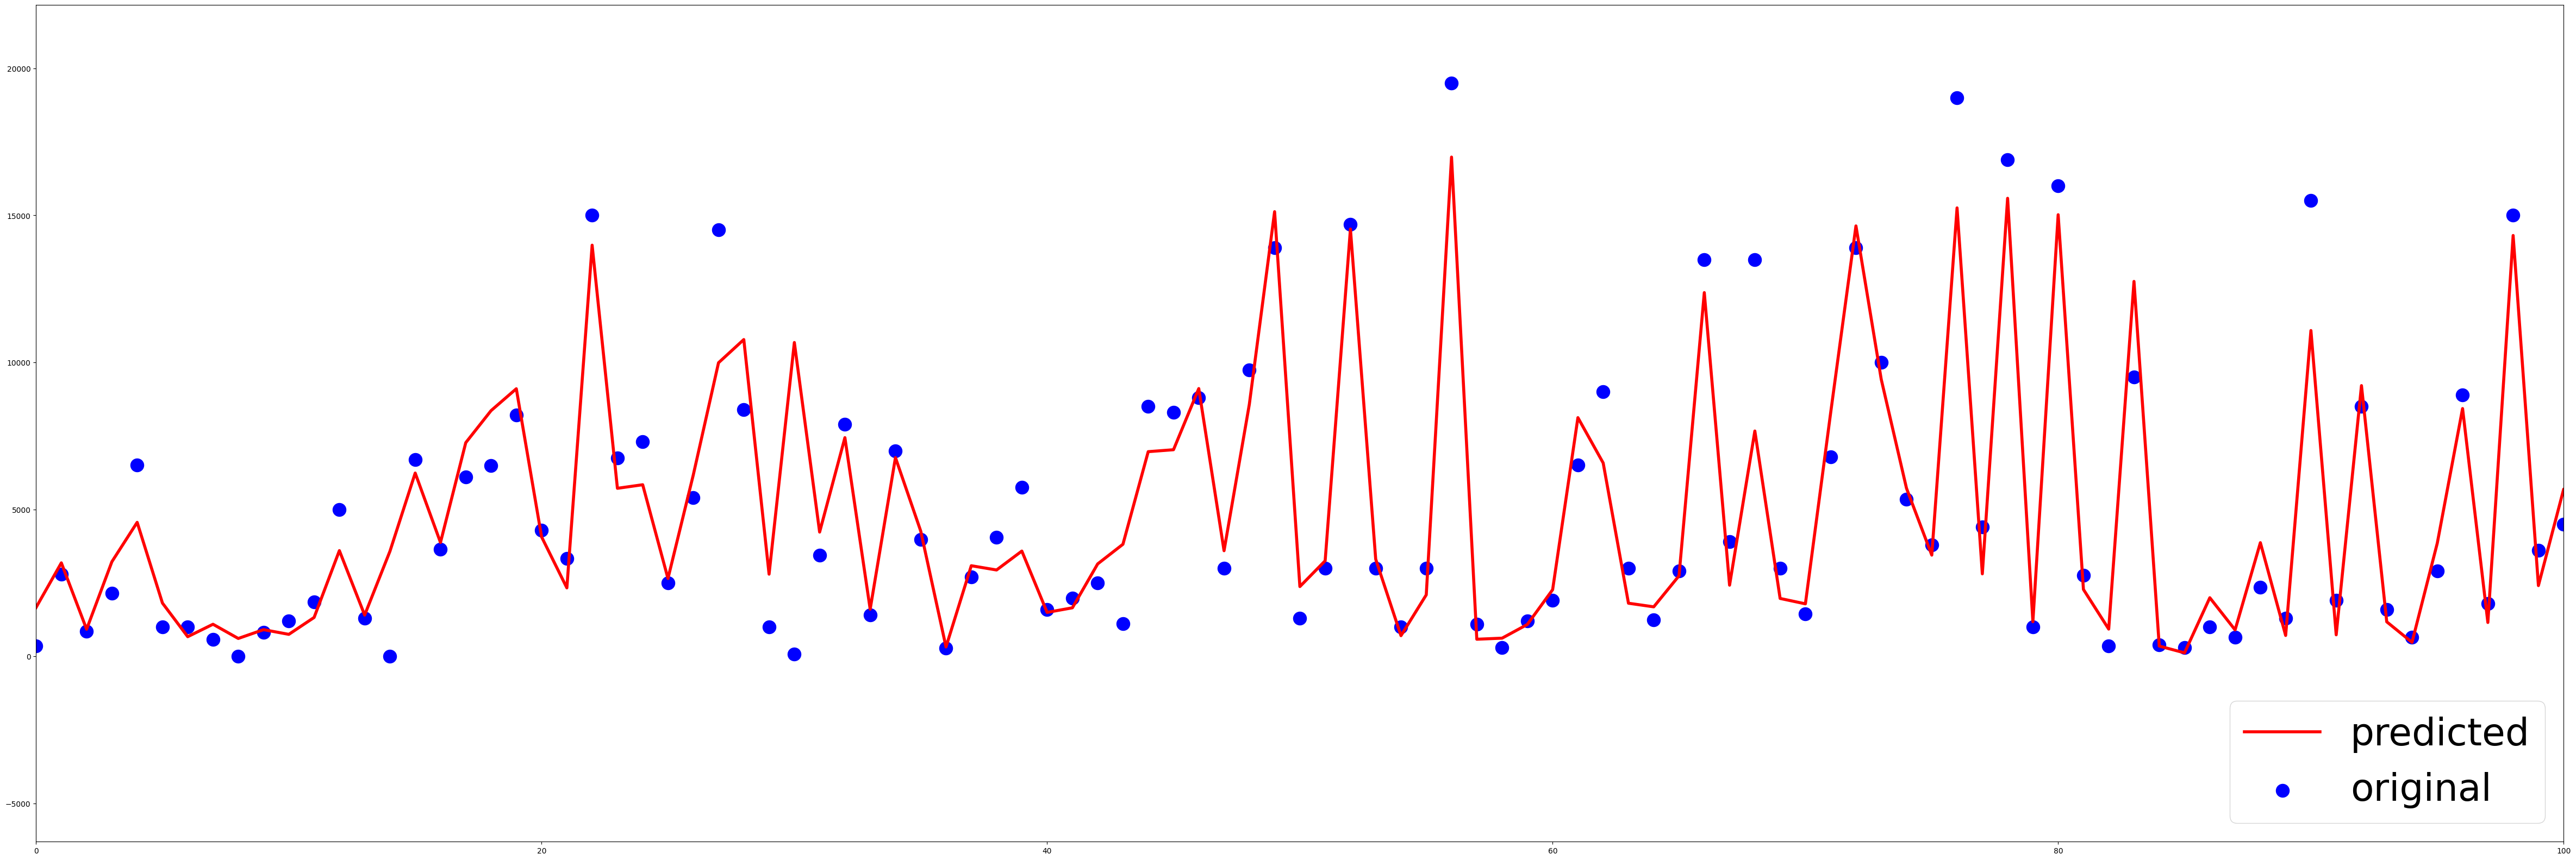

In [539]:
plt.figure(figsize=(60, 20))
x_ax = range(len(features_test))
plt.scatter(x_ax, target_test, s=300, color="blue", label="original")
plt.plot(x_ax, predictions, lw=4, color="red", label="predicted")
plt.xlim(0,100)
plt.legend(fontsize=50, loc='lower right')

plt.show()

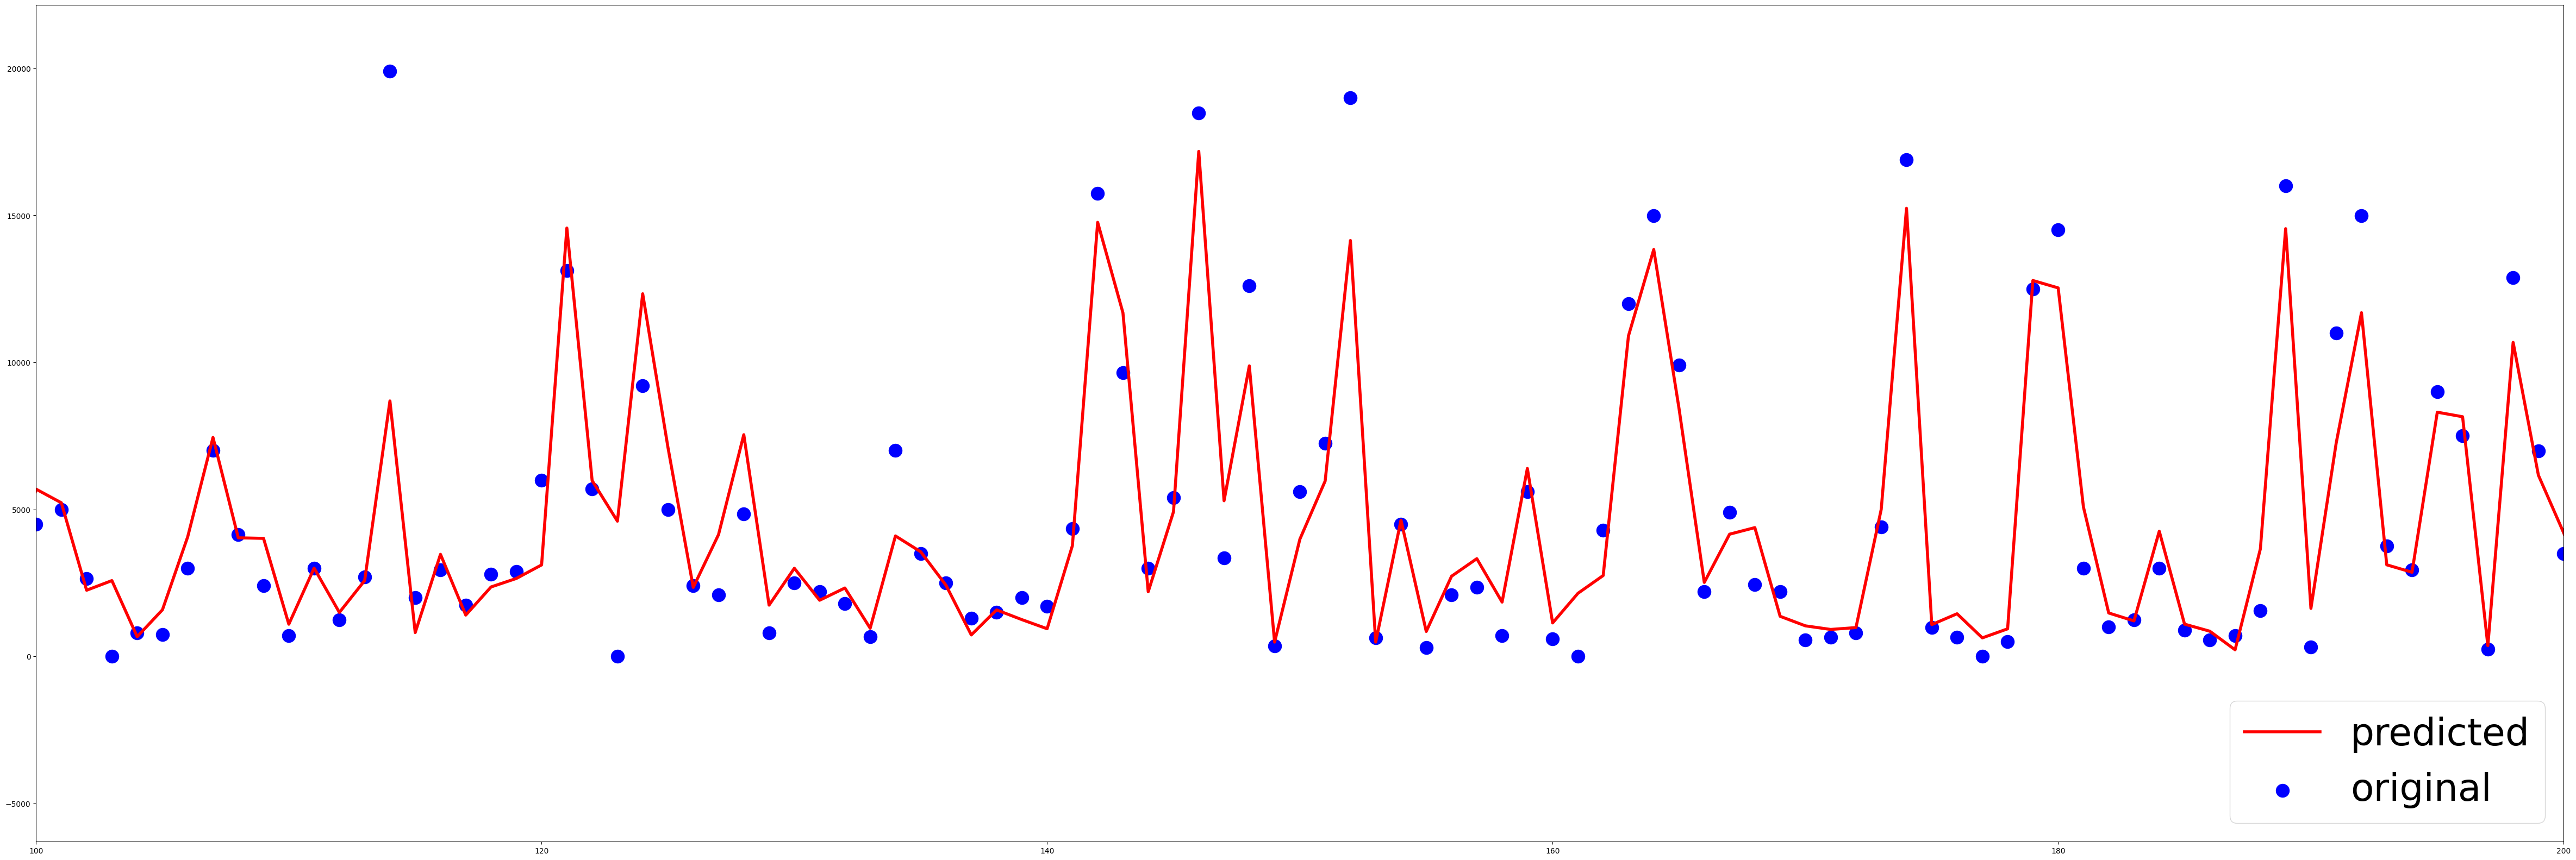

In [540]:
plt.figure(figsize=(60, 20))
x_ax = range(len(features_test))
plt.scatter(x_ax, target_test, s=300, color="blue", label="original")
plt.plot(x_ax, predictions, lw=4, color="red", label="predicted")
plt.xlim(100,200)
plt.legend(fontsize=50, loc='lower right')

plt.show()

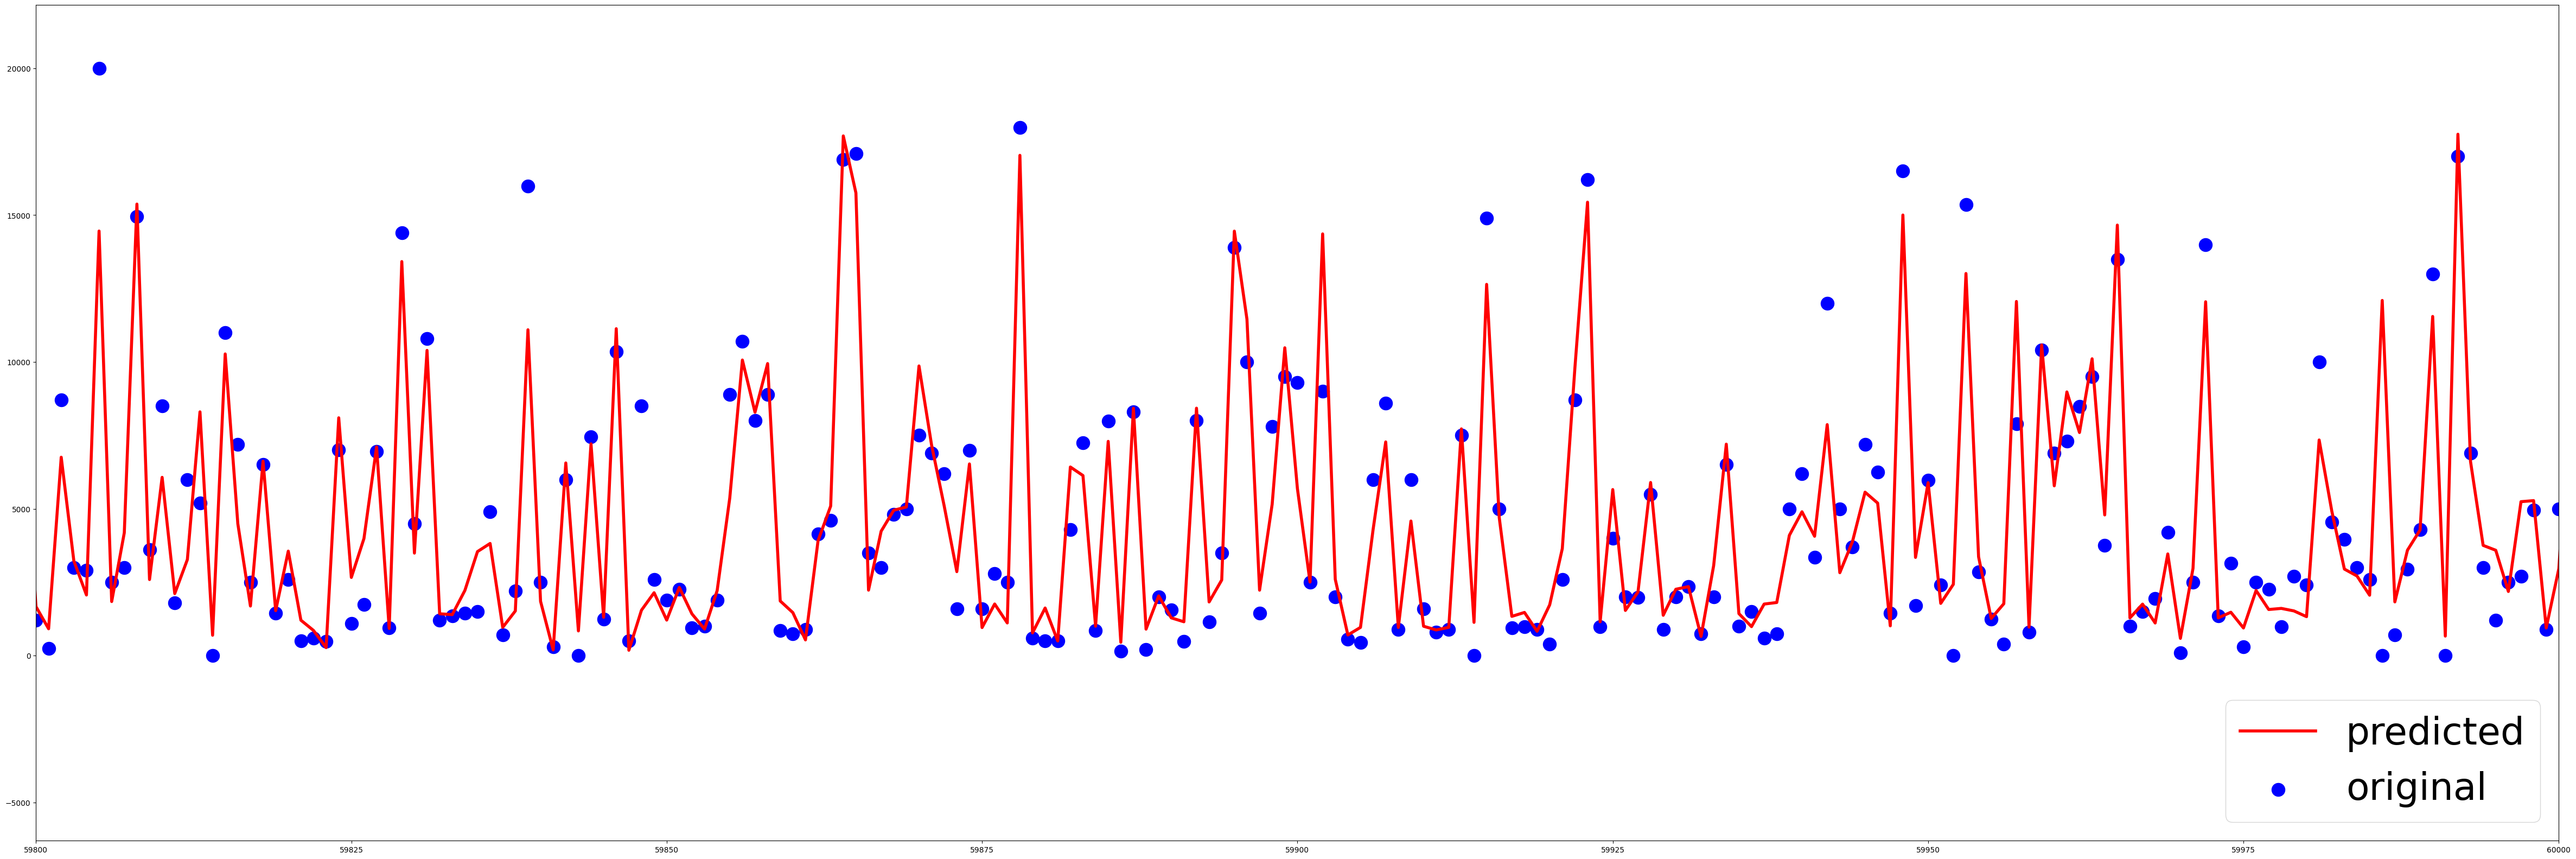

In [541]:
plt.figure(figsize=(60, 20))
x_ax = range(len(features_test))
plt.scatter(x_ax, target_test, s=300, color="blue", label="original")
plt.plot(x_ax, predictions, lw=4, color="red", label="predicted")
plt.xlim(59800,60000)
plt.legend(fontsize=50, loc='lower right')

plt.show()

## Общий вывод

<p>Изучили данные о технических характеристиках, комплектации и ценах автомобилей. Провели предобработку данных: привели названия столбцов к нижнему регистру, удалили неиформативные признаки (last_seen, number_of_pictures, date_crawled, date_created), явные дубликаты, выбросы и пропуски. Пропуски заполнили медианными значениями по моделям или бренду автомобиля, для repaired нулями. Аномальные значения мощности заменены медианными для каждой модели значениями. </p>
<p>Провели исследовательский анализ. Выяснили, что большая часть автомобилей имеют большой пробег, более 140000км. Изучили данные столбцов registration_year и registration_month. Большая часть данных соотвествует периоду с 1980 по 2018 годы. Аномальное значение месяца регистрации 0, медианная цена для этого месяца значительно ниже, чем для остальных. Причем для всех месяцев (кроме нулевого) медианная цена примерно одинаковая. Удалены столбцы с данными о месяцах регистрации автомобиля и почтовых индексах. Медианная цена для каждого бренда и модели разная, увеличивается монотонно от модели к модели (от бренда к бренду). Низкочастотные значения в столбцах fuel_type, vehicle_type отнесли к категории Other. Категориальные признаки закодировали с помощью OrdinalEncoder. </p>

<p>Обучили модели - Линейная регрессия, Случайный лес, CatBoostRegressor, LGBMRegressor - и подобрали гиперпараметры. Протестировали модели и проанализировали результаты. </p>
<p>Наилучшие RMSE показали LGBMRegressor (Количество деревьев: 52 Глубина дерева: 17 Скорость: 0.3), CatBoostRegressor(Количество деревьев: 62 Глубина дерева: 16 Скорость: 0.3) и модель случайного леса (Количество деревьев: 46 Глубина дерева: 19), но модель случайного леса (9 мин 35 с) и CatBoostRegressor(17 мин 13 с) значительно уступает в скорости обучения LGBMRegressor(1 мин 7 с - обучение, 38 мс - предсказание), поэтому <b> наилучшей моделью является модель LGBMRegressor, именно ее следует использовать заказчику. RMSE = 1697 </b> </p>
 